In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

import gc
import re
import os
import warnings
warnings.filterwarnings('ignore')

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter
import time

/Users/v0h0041/Documents/kaggle/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [47]:
def label_enc(x):
    values = x.unique()
    lb_enc = defaultdict(np.int32)
    for i, v in enumerate(values):
        lb_enc[v] = i
    return lb_enc, values

def one_hot_enc(df, x):
    values = df[x].unique()
    #values_dict = {v:i for i, v in enumerate(values)}
    
    for v in values:
        df[f'{x}_{v}'] = np.where(df[x] == v, 1, 0)
        df[f'{x}_{v}'] = df[f'{x}_{v}'].astype('int8')
        
        
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).std()

def load_data(train_data_path):
    
    # loading all datasets
    campaign_data = pd.read_csv(os.path.join(train_data_path, 'campaign_data.csv'))
    customer_demographics = pd.read_csv(os.path.join(train_data_path, 'customer_demographics.csv'))
    item_data = pd.read_csv(os.path.join(train_data_path, 'item_data.csv'))
    
    # load train data
    df_train = pd.read_csv(os.path.join(train_data_path, 'train.csv'))
    df_test = pd.read_csv('../input/test_QyjYwdj.csv')
    
    # convert to datetime format
    campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], dayfirst=True)
    campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], dayfirst=True)
    
    df_train = df_train.join(customer_demographics.set_index('customer_id'), on='customer_id', how='left')
    df_test = df_test.join(customer_demographics.set_index('customer_id'), on='customer_id', how='left')
    
    df_train = df_train.join(campaign_data.set_index('campaign_id'), on='campaign_id', how='left', rsuffix='_campaign')
    df_test = df_test.join(campaign_data.set_index('campaign_id'), on='campaign_id', how='left', rsuffix='_campaign')
    
    df_train['duration_of_campaign'] = (df_train['start_date'] - df_train['end_date']).apply(lambda x: x.days)
    df_test['duration_of_campaign'] = (df_test['start_date'] - df_test['end_date']).apply(lambda x: x.days)

    del campaign_data, customer_demographics, item_data
    gc.collect()
   
    df_val = df_train.loc[df_train['campaign_id'].isin({11, 12, 13})].reset_index(drop=True)
    df_train = df_train.loc[~df_train['campaign_id'].isin({11, 12, 13})].reset_index(drop=True)
    
    return df_train, df_val, df_test

In [3]:
train_data_path = '../input/train_AUpWtIz/'
df_train, df_val, df_test = load_data(train_data_path)

In [48]:
def get_redemption_mean(df_tr, df_v, df_te, alpha=5):
    
    folds = StratifiedKFold(n_splits=10, random_state=111, shuffle=True)
    customer_redemption_mean = np.zeros(len(df_tr))
    
    for tr_idx, val_idx in folds.split(df_tr, df_tr['redemption_status']):
        
        X_tr, X_val = df_tr.loc[tr_idx], df_tr.loc[val_idx]

        grp_obj = mean_likelihood(X_tr, 'customer_id', 'redemption_status', alpha=alpha)
        grp_obj.columns = ['customer_redemption_status_mean']
        
        customer_redemption_mean[val_idx] = X_val.join(grp_obj
                                                       , on='customer_id'
                                                       , how='left'
                                                      , rsuffix='_cust_mean')['customer_redemption_status_mean']
        
    df_tr['customer_redemption_status_mean'] = customer_redemption_mean
    
    grp_obj = mean_likelihood(df_tr, 'customer_id', 'redemption_status', alpha=alpha)
    grp_obj.columns = ['customer_redemption_status_mean']
    
    df_v = df_v.join(grp_obj, on='customer_id', how='left', rsuffix='_cust_mean')
    df_v['customer_redemption_status_mean'].fillna(df_tr['redemption_status'].mean(), inplace=True)
        
    df_temp = pd.concat([df_tr, df_v], axis=0)
    grp_obj = mean_likelihood(df_temp, 'customer_id', 'redemption_status', alpha=alpha)
    grp_obj.columns = ['customer_redemption_status_mean']
    
    df_te = df_te.join(grp_obj, on='customer_id', how='left', rsuffix='_cust_mean')
    df_te.rename(columns = {'redemption_status': 'customer_redemption_status_mean'}, inplace=True)
    df_te['customer_redemption_status_mean'].fillna(df_tr['redemption_status'].mean(), inplace=True)
    
    return df_tr, df_v, df_te

df_train, df_val, df_test = get_redemption_mean(df_train, df_val, df_test, alpha=15)
df_train['customer_redemption_status_mean'].fillna(df_train['redemption_status'].mean(), inplace=True)

KeyboardInterrupt: 

In [5]:
def list_intersection(a, b):
    if len(a)>len(b):
        a,b = b,a
    a_count = Counter(a)
    b_count = Counter(b)
    return sum(min(b_count[ak], av) for ak,av in a_count.items())

def list_union(a, b):
    if len(a)>len(b):
        a,b = b,a
    a_count = Counter(a)
    b_count = Counter(b)
    new_dict_union = {}
    new_dict_union = {ak:av for ak, av in a_count.items()}
    for ak, av in b_count.items():
        if ak not in new_dict_union:
            new_dict_union[ak]= av
        else:
            new_dict_union[ak] = new_dict_union[ak]+av 
    return sum(new_dict_union[ak] for ak in new_dict_union.keys())


In [6]:
def load_transaction_old(df, apply_list=True):
    
    start_time = time.time()
    customer_transaction = pd.read_csv(os.path.join(train_data_path, 'customer_transaction_data.csv'))
    coupon_item_data = pd.read_csv(os.path.join(train_data_path, 'coupon_item_mapping.csv'))
    customer_transaction['date'] = pd.to_datetime(customer_transaction['date'])
    
    coupon_item = coupon_item_data.groupby('coupon_id')['item_id'].apply(list)
    item_data = pd.read_csv(os.path.join(train_data_path, 'item_data.csv'))
    
    print('joining datasets and filtering')
    df_trans = df[['customer_id', 'campaign_id', 'coupon_id', 'start_date']].join(customer_transaction.set_index('customer_id')
                         , on='customer_id', how='left', rsuffix='_transaction')
    
    df_trans = df_trans.loc[df_trans['start_date'] > df_trans['date']].reset_index(drop=True)
    
    df_trans = df_trans.join(item_data.set_index('item_id'), on='item_id', how='left', rsuffix='_item')
    
#    print('One hot encoding')
    
#     one_hot_enc(df_trans, 'category')
#     one_hot_enc(df_trans, 'brand_type')
    
    agg = dict()
    # need to add features regading other_discount and coupon_discount
#    agg['other_discount'] = ['median', 'std', 'min', 'max']
#    agg['coupon_discount'] = ['median', 'std', 'min', 'max']
    for col in df_trans.columns:
#         if ('category_' in col) | ('brand_type_' in col):
#             agg[col] = 'sum'
        if col == 'item_id':
            agg[col] = list
        elif '_discount' in col:
            agg[col] = 'mean'
    
    print('Group by')
    df_trans_obj = df_trans.groupby(['customer_id', 'campaign_id', 'coupon_id']).agg(agg)
    
    print('joining the datasets')
    df = df.join(df_trans_obj, on=['customer_id', 'campaign_id', 'coupon_id'], how='left', rsuffix='_history')
    df = df.join(coupon_item, on='coupon_id', how='left', rsuffix='_coupon')
    
    del customer_transaction, coupon_item_data
    gc.collect()

        
    df['item_id_intersection_item_id_coupon_list'] = df.apply(lambda x: list_intersection(x.item_id, x.item_id_coupon)
                                                     , axis=1)
    df['item_id_union_item_id_coupon_list'] = df.apply(lambda x: list_union(x.item_id, x.item_id_coupon)
                                                     , axis=1)

    df['item_id_ratio_item_id_coupon_list'] = df['item_id_intersection_item_id_coupon_list']/ \
                                            df['item_id_union_item_id_coupon_list']

    df['item_id_intersection_item_id_coupon'] = df.apply(lambda x: len(set(x.item_id).intersection(x.item_id_coupon))
                                                     , axis=1)

    df['item_id_union_item_id_coupon'] = df.apply(lambda x: len(set(x.item_id).union(x.item_id_coupon))
                                                     , axis=1)
    df['item_id_ratio_item_id_coupon'] = df['item_id_intersection_item_id_coupon']/ \
                                            df['item_id_union_item_id_coupon']
 
    
    df_trans_obj = df_trans.loc[df_trans['coupon_discount'] < 0].groupby(['customer_id'
                                                                          , 'campaign_id'
                                                                         , 'coupon_id']).agg(agg)
    df = df.join(df_trans_obj, on=['customer_id'
                                   , 'campaign_id'
                                  , 'coupon_id']
                 , how='left', rsuffix='_active_coupon')
    
    
    df['item_id_active_coupon'].fillna(-1, inplace=True)

    df['item_id_intersection_item_id_active_list'] = df.apply(lambda x: list_intersection(x.item_id_coupon, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_item_id_active_list'] = df.apply(lambda x: list_union(x.item_id_coupon, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)

    df['item_id_intersection_prec_list'] = df.apply(lambda x: list_intersection(x.item_id, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_prec_list'] = df.apply(lambda x: list_union(x.item_id, x.item_id_active_coupon) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)



    df['item_id_ratio_item_id_active_list'] = df['item_id_intersection_item_id_active_list']/ \
                                                df['item_id_union_item_id_active_list']

    df.loc[df.item_id_intersection_item_id_active_list == -1, 'item_id_ratio_item_id_active_list'] = -1

    df['item_id_ratio_prec_list'] = df['item_id_intersection_prec_list']/df['item_id_union_prec_list']

    df['item_id_intersection_item_id_active'] = df.apply(lambda x: len(set(x.item_id_coupon).intersection(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_item_id_active'] = df.apply(lambda x: len(set(x.item_id_coupon).union(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)

    df['item_id_intersection_prec'] = df.apply(lambda x: len(set(x.item_id).intersection(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)
    df['item_id_union_prec'] = df.apply(lambda x: len(set(x.item_id).union(x.item_id_active_coupon)) if x.item_id_active_coupon != -1 else -1
                                                    , axis = 1)

    df['item_id_ratio_item_id_active'] = df['item_id_intersection_item_id_active']/df['item_id_union_item_id_active']
    df.loc[df.item_id_intersection_item_id_active == -1, 'item_id_ratio_item_id_active'] = -1

    df['item_id_ratio_prec'] = df['item_id_intersection_prec']/df['item_id_union_prec']
    
    print('Done in time :', time.time()-start_time)
    return df

In [9]:
def load_transaction(df, apply_list=True):
    
    start_time = time.time()
    customer_transaction = pd.read_csv(os.path.join(train_data_path, 'customer_transaction_data.csv'))
    
    coupon_item_data = pd.read_csv(os.path.join(train_data_path, 'coupon_item_mapping.csv'))
    
    customer_transaction['date'] = pd.to_datetime(customer_transaction['date'])
    
    item_data = pd.read_csv(os.path.join(train_data_path, 'item_data.csv'))
    
    coupon_item_data= coupon_item_data.merge(item_data, on = 'item_id', how = 'left')
    
    coupon_item = coupon_item_data.groupby('coupon_id').agg({'item_id':list,
                                                             'brand':list,
                                                             'brand_type':list,
                                                             'category':list}).reset_index()

    print('joining datasets and filtering')
#     print(df.columns)
    
    df_trans = df[['customer_id', 'campaign_id', 'coupon_id', 'start_date']].join(customer_transaction.set_index('customer_id')
                         , on='customer_id', how='left', rsuffix='_transaction')
    
    df_trans = df_trans.loc[df_trans['start_date'] > df_trans['date']].reset_index(drop=True)
    
    df_trans = df_trans.join(item_data.set_index('item_id'), on='item_id', how='left', rsuffix='_item')
    
#    print('One hot encoding')
    
#     one_hot_enc(df_trans, 'category')
#     one_hot_enc(df_trans, 'brand_type')
    
    agg = dict()
    # need to add features regading other_discount and coupon_discount
#    agg['other_discount'] = ['median', 'std', 'min', 'max']
#    agg['coupon_discount'] = ['median', 'std', 'min', 'max']

    for col in df_trans.columns:
        if col in ['item_id','brand','brand_type','category']:
            agg[col] = list
        elif '_discount' in col:
            agg[col] = 'mean'

    
    print('Group by')
    df_trans_obj = df_trans.groupby(['customer_id', 'campaign_id', 'coupon_id']).agg(agg)

    print('joining the datasets')
    df = df.join(df_trans_obj, on=['customer_id', 'campaign_id', 'coupon_id'], how='left', rsuffix='_history')
#     print(df.columns)
    
    df = df.join(coupon_item.set_index('coupon_id'), on='coupon_id', how='left', rsuffix='_coupon')
    
    del customer_transaction, coupon_item_data
    gc.collect()
    
    for col in ['item_id','brand','brand_type','category']:
        df[col+'_coupon'].fillna(-1, inplace=True)
        df[col].fillna(-1, inplace=True)
        def inon(x, y):
            if y != -1 and x != -1:
                return list_intersection(x, y)
            else:
                return -1
            
        def anon(x, y):
            if y != -1 and x != -1:
                return list_union(x, y)
            elif x==-1 and y ==-1:
                return -1
            elif y == -1:
                return -1
            else:
                return -1


        df[col+'_intersection_'+col+'_coupon_list'] = df.apply(lambda x: inon(x[col], x[col+'_coupon'])
                                                         , axis=1)
        
        df[col+'_union_'+col+'_coupon_list'] = df.apply(lambda x: anon(x[col], x[col+'_coupon']) 
                                                         , axis=1)

        df[col+'_intersection_'+col+'_coupon_list'].fillna(-1, inplace = True)
        df[col+'_union_'+col+'_coupon_list'].fillna(-1, inplace = True)
        
        df[col+'_ratio_'+col+'_coupon_list'] = df[col+'_intersection_'+col+'_coupon_list']/ \
                                                df[col+'_union_'+col+'_coupon_list']
        
        df.loc[df[col+'_intersection_'+col+'_coupon_list'] == -1, col+'_ratio_'+col+'_coupon_list'] = -1

        
        def inon_set(x, y):
            if y != -1 and x != -1:
                return len(set(x).intersection(y))
            else:
                return -1
        def anon_set(x, y):
            if y != -1 and x != -1:
                return len(set(x).union(y))
            elif x==-1 and y ==-1:
                return -1

            elif y == -1:
                return -1
            else:
                return -1


        df[col+'_intersection_'+col+'_coupon'] = df.apply(lambda x: inon_set(x[col],x[col+'_coupon'])
                                                         , axis=1)

        df[col+'_union_'+col+'_coupon'] = df.apply(lambda x: anon_set(x[col],x[col+'_coupon'])
                                                         , axis=1)
        df[col+'_intersection_'+col+'_coupon'].fillna(-1, inplace = True)
        df[col+'_union_'+col+'_coupon'].fillna(-1, inplace = True)
        df[col+'_ratio_'+col+'_coupon'] = df[col+'_intersection_'+col+'_coupon']/ \
                                                df[col+'_union_'+col+'_coupon']
        df.loc[df[col+'_intersection_'+col+'_coupon'] == -1, col+'_ratio_'+col+'_coupon'] = -1


    
    df_trans_obj = df_trans.loc[df_trans['coupon_discount'] < 0].groupby(['customer_id'
                                                                          , 'campaign_id'
                                                                         , 'coupon_id']).agg(agg)
    df = df.join(df_trans_obj, on=['customer_id'
                                   , 'campaign_id'
                                  , 'coupon_id']
                 , how='left', rsuffix='_active_coupon')
    
    
    for col in ['item_id','brand','brand_type','category']:
        df[col+'_active_coupon'].fillna(-1, inplace=True)

        df[col+'_intersection_'+col+'_active_list'] = df.apply(lambda x: inon(x[col+'_coupon'], x[col+'_active_coupon']) 
                                                        , axis = 1)
        df[col+'_union_'+col+'_active_list'] = df.apply(lambda x: anon(x[col+'_coupon'], x[col+'_active_coupon']) 
                                                        , axis = 1)

        df[col+'_intersection_prec_list'] = df.apply(lambda x: inon(x[col], x[col+'_active_coupon'])
                                                        , axis = 1)
        df[col+'_union_prec_list'] = df.apply(lambda x: anon(x[col], x[col+'_active_coupon'])
                                                        , axis = 1)


        df[col+'_intersection_'+col+'_active_list'].fillna(-1, inplace= True)
        df[col+'_union_'+col+'_active_list'].fillna(-1, inplace= True)
        df[col+'_intersection_prec_list'].fillna(-1, inplace= True)
        df[col+'_union_prec_list'].fillna(-1, inplace= True)
        
        df[col+'_ratio_'+col+'_active_list'] = df[col+'_intersection_'+col+'_active_list']/ \
                                                    df[col+'_union_'+col+'_active_list']

        df.loc[df[col+'_intersection_'+col+'_active_list'] == -1, col+'_ratio_'+col+'_active_list'] = -1

        df[col+'_ratio_prec_list'] = df[col+'_intersection_prec_list']/df[col+'_union_prec_list']

        df[col+'_intersection_'+col+'_active'] = df.apply(lambda x: inon_set(x[col+'_coupon'], x[col+'_active_coupon'])
                                                        , axis = 1)
        df[col+'_union_'+col+'_active'] = df.apply(lambda x: anon_set(x[col+'_coupon'], x[col+'_active_coupon'])
                                                        , axis = 1)

        df[col+'_intersection_prec'] = df.apply(lambda x:  inon_set(x[col], x[col+'_active_coupon']) 
                                                        , axis = 1)
        df[col+'_union_prec'] = df.apply(lambda x: anon_set(x[col], x[col+'_active_coupon'])
                                                        , axis = 1)
        df[col+'_intersection_'+col+'_active'].fillna(-1, inplace= True)
        df[col+'_union_'+col+'_active'].fillna(-1, inplace= True)
        df[col+'_intersection_prec'].fillna(-1, inplace= True)
        df[col+'_union_prec'].fillna(-1, inplace= True)


        df[col+'_ratio_'+col+'_active'] =  df[col+'_intersection_'+col+'_active']/ df[col+'_union_'+col+'_active']
        df.loc[df[col+'_intersection_'+col+'_active'] == -1, col+'_ratio_'+col+'_active'] = -1

        df[col+'_ratio_prec'] =df[col+'_intersection_prec']/df[col+'_union_prec']

    print('Done in time :', time.time()-start_time)
    return df

In [10]:
df_train = load_transaction(df_train, apply_list=False)
df_val = load_transaction(df_val, apply_list=False)
df_test = load_transaction(df_test, apply_list=False)

joining datasets and filtering
Group by
joining the datasets
Done in time : 302.7769310474396
joining datasets and filtering
Group by
joining the datasets
Done in time : 197.93054103851318
joining datasets and filtering
Group by
joining the datasets
Done in time : 531.841521024704


In [11]:
gc.collect()

42

In [12]:
def train_model(data_, data_val_, y_, y_val, features,early_stopping_rounds, **clf_kwargs):

    oof_preds = np.zeros(data_val_.shape[0])
    n_fold = 0
    
    feature_importance_df = pd.DataFrame()
    
    feats = features
    
    trn_x, trn_y = data_[feats], y_
    val_x, val_y = data_val_[feats], y_val

    clf = LGBMClassifier().set_params(**clf_kwargs)

    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='logloss', verbose=100, early_stopping_rounds=early_stopping_rounds  #30
           )

    oof_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds)))
    del trn_x, trn_y, val_x, val_y
    gc.collect()
        
    return oof_preds, feature_importance_df, clf


def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [13]:
# plt.figure()
# sns.distplot(df_train['item_redemption_status_mean'])
# sns.distplot(df_val['item_redemption_status_mean'])
# sns.distplot(df_test['item_redemption_status_mean'])
# plt.show()

In [14]:
df_train.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children',
       ...
       'category_intersection_prec_list', 'category_union_prec_list',
       'category_ratio_category_active_list', 'category_ratio_prec_list',
       'category_intersection_category_active',
       'category_union_category_active', 'category_intersection_prec',
       'category_union_prec', 'category_ratio_category_active',
       'category_ratio_prec'],
      dtype='object', length=104)

In [18]:
ints_unions = [col for col in df_train.columns if 'intersection' in col  or 'union' in col or 'ratio' in col]




In [24]:
cat_feats = ['age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket', 'campaign_type']
num_feats = ['duration_of_campaign', 'other_discount',
       'coupon_discount',
       'item_id_intersection_item_id_coupon', 
             'item_id_union_item_id_coupon',
       'item_id_ratio_item_id_coupon', 
#             'item_redemption_status_mean',
#             'item_id_active_coupon',
       'other_discount_active_coupon', 'coupon_discount_active_coupon',
       'item_id_intersection_item_id_active', 'item_id_union_item_id_active',
       'item_id_ratio_item_id_active', 'customer_redemption_status_mean','customer_id','coupon_id',
       'item_id_intersection_item_id_coupon_list', 
             'item_id_union_item_id_coupon_list',
       'item_id_ratio_item_id_coupon_list','item_id_intersection_item_id_active_list',
             'item_id_union_item_id_active_list',
       'item_id_ratio_item_id_active_list']

In [25]:
add_feats= [col for col in ints_unions if col not in num_feats]
# num_feats = num_feats+add_feats

In [26]:
for col in cat_feats:
    df_train[col].fillna(-1, inplace=True)
    df_val[col].fillna(-1, inplace=True)
    df_test[col].fillna(-1, inplace=True)
    lb_enc, _ = label_enc(df_train[col])
    df_train[col] = df_train[col].map(lb_enc)
    df_test[col] = df_test[col].map(lb_enc)
    df_val[col] = df_val[col].map(lb_enc)

In [28]:
lgb_params = {
        'random_state':122,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'logloss',
        'learning_rate': 0.002,
        'subsample': .8,
        'colsample_bytree': .4,
        'reg_alpha': 10,
        'reg_lambda': 10,
        'n_estimators': 10000,
        'max_depth': 3
    }

for col in add_feats:
    print(col)
    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        , num_feats+cat_feats+[col],50, **lgb_params)

brand_intersection_brand_coupon_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372366	valid_1's binary_logloss: 0.0629032
[200]	training's binary_logloss: 0.0340591	valid_1's binary_logloss: 0.0578313
[300]	training's binary_logloss: 0.0319438	valid_1's binary_logloss: 0.0546479
[400]	training's binary_logloss: 0.0304964	valid_1's binary_logloss: 0.0524559
[500]	training's binary_logloss: 0.0294062	valid_1's binary_logloss: 0.0508561
[600]	training's binary_logloss: 0.0285523	valid_1's binary_logloss: 0.0496452
[700]	training's binary_logloss: 0.0278606	valid_1's binary_logloss: 0.0487068
[800]	training's binary_logloss: 0.0273225	valid_1's binary_logloss: 0.047975
[900]	training's binary_logloss: 0.0268787	valid_1's binary_logloss: 0.0474149
[1000]	training's binary_logloss: 0.0265198	valid_1's binary_logloss: 0.0469656
[1100]	training's binary_logloss: 0.0262054	valid_1's binary_logloss: 0.0465982
[1200]	training's binary_loglos

[3200]	training's binary_logloss: 0.023539	valid_1's binary_logloss: 0.0444387
[3300]	training's binary_logloss: 0.0234828	valid_1's binary_logloss: 0.044431
Early stopping, best iteration is:
[3260]	training's binary_logloss: 0.0235052	valid_1's binary_logloss: 0.0444283
Fold  1 AUC : 0.932716
brand_intersection_brand_coupon
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372478	valid_1's binary_logloss: 0.0629295
[200]	training's binary_logloss: 0.0340688	valid_1's binary_logloss: 0.0578342
[300]	training's binary_logloss: 0.0319554	valid_1's binary_logloss: 0.0546594
[400]	training's binary_logloss: 0.030507	valid_1's binary_logloss: 0.0524674
[500]	training's binary_logloss: 0.0294194	valid_1's binary_logloss: 0.050869
[600]	training's binary_logloss: 0.0285706	valid_1's binary_logloss: 0.0496607
[700]	training's binary_logloss: 0.027881	valid_1's binary_logloss: 0.0487421
[800]	training's binary_logloss: 0.0273431	valid_1's binary_

[2900]	training's binary_logloss: 0.0238497	valid_1's binary_logloss: 0.044664
[3000]	training's binary_logloss: 0.0237863	valid_1's binary_logloss: 0.0446317
[3100]	training's binary_logloss: 0.0237253	valid_1's binary_logloss: 0.0446019
[3200]	training's binary_logloss: 0.0236663	valid_1's binary_logloss: 0.0445908
Early stopping, best iteration is:
[3239]	training's binary_logloss: 0.0236442	valid_1's binary_logloss: 0.0445787
Fold  1 AUC : 0.933382
brand_type_intersection_brand_type_coupon_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372605	valid_1's binary_logloss: 0.0629398
[200]	training's binary_logloss: 0.0340804	valid_1's binary_logloss: 0.0578529
[300]	training's binary_logloss: 0.0319623	valid_1's binary_logloss: 0.0546715
[400]	training's binary_logloss: 0.0305167	valid_1's binary_logloss: 0.0524922
[500]	training's binary_logloss: 0.0294258	valid_1's binary_logloss: 0.0508828
[600]	training's binary_logloss: 0.0285

[2600]	training's binary_logloss: 0.0240061	valid_1's binary_logloss: 0.0446575
[2700]	training's binary_logloss: 0.0239284	valid_1's binary_logloss: 0.0446159
[2800]	training's binary_logloss: 0.0238578	valid_1's binary_logloss: 0.0445949
[2900]	training's binary_logloss: 0.0237883	valid_1's binary_logloss: 0.0445546
[3000]	training's binary_logloss: 0.0237206	valid_1's binary_logloss: 0.0445172
[3100]	training's binary_logloss: 0.0236548	valid_1's binary_logloss: 0.0444848
[3200]	training's binary_logloss: 0.0235931	valid_1's binary_logloss: 0.0444641
[3300]	training's binary_logloss: 0.0235361	valid_1's binary_logloss: 0.0444576
Early stopping, best iteration is:
[3262]	training's binary_logloss: 0.0235582	valid_1's binary_logloss: 0.0444538
Fold  1 AUC : 0.933207
brand_type_intersection_brand_type_coupon
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372816	valid_1's binary_logloss: 0.0629762
[200]	training's binary_logloss: 0.0341

[1200]	training's binary_logloss: 0.0259739	valid_1's binary_logloss: 0.0463639
[1300]	training's binary_logloss: 0.0257456	valid_1's binary_logloss: 0.0460994
[1400]	training's binary_logloss: 0.0255281	valid_1's binary_logloss: 0.0458932
[1500]	training's binary_logloss: 0.0253385	valid_1's binary_logloss: 0.0457305
[1600]	training's binary_logloss: 0.025175	valid_1's binary_logloss: 0.0455721
[1700]	training's binary_logloss: 0.025022	valid_1's binary_logloss: 0.0454561
[1800]	training's binary_logloss: 0.024887	valid_1's binary_logloss: 0.0453274
[1900]	training's binary_logloss: 0.0247578	valid_1's binary_logloss: 0.0452341
[2000]	training's binary_logloss: 0.0246446	valid_1's binary_logloss: 0.0451346
[2100]	training's binary_logloss: 0.0245371	valid_1's binary_logloss: 0.0450568
[2200]	training's binary_logloss: 0.0244377	valid_1's binary_logloss: 0.0449897
[2300]	training's binary_logloss: 0.024343	valid_1's binary_logloss: 0.0449112
[2400]	training's binary_logloss: 0.0242555	

[900]	training's binary_logloss: 0.0268676	valid_1's binary_logloss: 0.0474421
[1000]	training's binary_logloss: 0.0265101	valid_1's binary_logloss: 0.0469929
[1100]	training's binary_logloss: 0.0261967	valid_1's binary_logloss: 0.0466295
[1200]	training's binary_logloss: 0.0259193	valid_1's binary_logloss: 0.0463225
[1300]	training's binary_logloss: 0.0256904	valid_1's binary_logloss: 0.0460603
[1400]	training's binary_logloss: 0.0254714	valid_1's binary_logloss: 0.0458552
[1500]	training's binary_logloss: 0.025281	valid_1's binary_logloss: 0.0456877
[1600]	training's binary_logloss: 0.025118	valid_1's binary_logloss: 0.0455262
[1700]	training's binary_logloss: 0.0249624	valid_1's binary_logloss: 0.0454031
[1800]	training's binary_logloss: 0.0248245	valid_1's binary_logloss: 0.0452702
[1900]	training's binary_logloss: 0.0246927	valid_1's binary_logloss: 0.0451785
[2000]	training's binary_logloss: 0.0245752	valid_1's binary_logloss: 0.0450792
[2100]	training's binary_logloss: 0.0244639

[1100]	training's binary_logloss: 0.0262222	valid_1's binary_logloss: 0.0467342
[1200]	training's binary_logloss: 0.0259471	valid_1's binary_logloss: 0.0464357
[1300]	training's binary_logloss: 0.0257191	valid_1's binary_logloss: 0.0461673
[1400]	training's binary_logloss: 0.0255024	valid_1's binary_logloss: 0.0459568
[1500]	training's binary_logloss: 0.0253131	valid_1's binary_logloss: 0.0457896
[1600]	training's binary_logloss: 0.0251492	valid_1's binary_logloss: 0.0456204
[1700]	training's binary_logloss: 0.0249953	valid_1's binary_logloss: 0.0454957
[1800]	training's binary_logloss: 0.0248606	valid_1's binary_logloss: 0.0453598
[1900]	training's binary_logloss: 0.0247312	valid_1's binary_logloss: 0.0452653
[2000]	training's binary_logloss: 0.0246171	valid_1's binary_logloss: 0.0451615
[2100]	training's binary_logloss: 0.0245092	valid_1's binary_logloss: 0.0450782
[2200]	training's binary_logloss: 0.0244098	valid_1's binary_logloss: 0.0450096
[2300]	training's binary_logloss: 0.0243

[700]	training's binary_logloss: 0.0278656	valid_1's binary_logloss: 0.048764
[800]	training's binary_logloss: 0.0273299	valid_1's binary_logloss: 0.0480295
[900]	training's binary_logloss: 0.02689	valid_1's binary_logloss: 0.0474766
[1000]	training's binary_logloss: 0.0265372	valid_1's binary_logloss: 0.0470368
[1100]	training's binary_logloss: 0.026229	valid_1's binary_logloss: 0.0466752
[1200]	training's binary_logloss: 0.0259536	valid_1's binary_logloss: 0.0463769
[1300]	training's binary_logloss: 0.0257264	valid_1's binary_logloss: 0.0461075
[1400]	training's binary_logloss: 0.0255083	valid_1's binary_logloss: 0.045896
[1500]	training's binary_logloss: 0.0253212	valid_1's binary_logloss: 0.0457401
[1600]	training's binary_logloss: 0.0251575	valid_1's binary_logloss: 0.0455782
[1700]	training's binary_logloss: 0.0250046	valid_1's binary_logloss: 0.0454596
[1800]	training's binary_logloss: 0.0248694	valid_1's binary_logloss: 0.0453278
[1900]	training's binary_logloss: 0.0247409	vali

[300]	training's binary_logloss: 0.0319382	valid_1's binary_logloss: 0.0547256
[400]	training's binary_logloss: 0.0304988	valid_1's binary_logloss: 0.0525487
[500]	training's binary_logloss: 0.0294121	valid_1's binary_logloss: 0.0509191
[600]	training's binary_logloss: 0.0285621	valid_1's binary_logloss: 0.0496862
[700]	training's binary_logloss: 0.0278749	valid_1's binary_logloss: 0.048747
[800]	training's binary_logloss: 0.0273385	valid_1's binary_logloss: 0.0480124
[900]	training's binary_logloss: 0.0268978	valid_1's binary_logloss: 0.0474583
[1000]	training's binary_logloss: 0.0265445	valid_1's binary_logloss: 0.0470169
[1100]	training's binary_logloss: 0.026236	valid_1's binary_logloss: 0.0466587
[1200]	training's binary_logloss: 0.0259626	valid_1's binary_logloss: 0.0463601
[1300]	training's binary_logloss: 0.025736	valid_1's binary_logloss: 0.0460918
[1400]	training's binary_logloss: 0.0255194	valid_1's binary_logloss: 0.04588
[1500]	training's binary_logloss: 0.0253325	valid_1'

Fold  1 AUC : 0.932635
brand_intersection_prec_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0371397	valid_1's binary_logloss: 0.0628267
[200]	training's binary_logloss: 0.0339421	valid_1's binary_logloss: 0.0576728
[300]	training's binary_logloss: 0.0318282	valid_1's binary_logloss: 0.0545226
[400]	training's binary_logloss: 0.0303963	valid_1's binary_logloss: 0.0523642
[500]	training's binary_logloss: 0.0293197	valid_1's binary_logloss: 0.0507816
[600]	training's binary_logloss: 0.0284717	valid_1's binary_logloss: 0.0495935
[700]	training's binary_logloss: 0.0277902	valid_1's binary_logloss: 0.0486675
[800]	training's binary_logloss: 0.0272573	valid_1's binary_logloss: 0.047945
[900]	training's binary_logloss: 0.0268179	valid_1's binary_logloss: 0.0473962
[1000]	training's binary_logloss: 0.0264659	valid_1's binary_logloss: 0.0469647
[1100]	training's binary_logloss: 0.0261602	valid_1's binary_logloss: 0.0466102
[1200]	training'

[3100]	training's binary_logloss: 0.0237063	valid_1's binary_logloss: 0.0447202
[3200]	training's binary_logloss: 0.0236448	valid_1's binary_logloss: 0.0447096
[3300]	training's binary_logloss: 0.0235892	valid_1's binary_logloss: 0.0447051
Early stopping, best iteration is:
[3260]	training's binary_logloss: 0.0236116	valid_1's binary_logloss: 0.0446992
Fold  1 AUC : 0.932106
brand_ratio_prec_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372159	valid_1's binary_logloss: 0.063022
[200]	training's binary_logloss: 0.0340403	valid_1's binary_logloss: 0.0579122
[300]	training's binary_logloss: 0.0319269	valid_1's binary_logloss: 0.05472
[400]	training's binary_logloss: 0.0304876	valid_1's binary_logloss: 0.0525439
[500]	training's binary_logloss: 0.0294007	valid_1's binary_logloss: 0.0509157
[600]	training's binary_logloss: 0.0285526	valid_1's binary_logloss: 0.0496968
[700]	training's binary_logloss: 0.0278656	valid_1's binary_logloss

[2700]	training's binary_logloss: 0.0239866	valid_1's binary_logloss: 0.0445977
[2800]	training's binary_logloss: 0.023918	valid_1's binary_logloss: 0.0445717
[2900]	training's binary_logloss: 0.0238499	valid_1's binary_logloss: 0.0445285
[3000]	training's binary_logloss: 0.0237866	valid_1's binary_logloss: 0.044493
[3100]	training's binary_logloss: 0.0237256	valid_1's binary_logloss: 0.0444571
[3200]	training's binary_logloss: 0.0236661	valid_1's binary_logloss: 0.0444414
[3300]	training's binary_logloss: 0.0236116	valid_1's binary_logloss: 0.0444331
Early stopping, best iteration is:
[3260]	training's binary_logloss: 0.0236332	valid_1's binary_logloss: 0.0444294
Fold  1 AUC : 0.932292
brand_intersection_prec
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0371627	valid_1's binary_logloss: 0.0628796
[200]	training's binary_logloss: 0.0339673	valid_1's binary_logloss: 0.0577016
[300]	training's binary_logloss: 0.0318534	valid_1's binary_

[2300]	training's binary_logloss: 0.0243239	valid_1's binary_logloss: 0.0449873
[2400]	training's binary_logloss: 0.0242354	valid_1's binary_logloss: 0.0449129
[2500]	training's binary_logloss: 0.024153	valid_1's binary_logloss: 0.0448518
[2600]	training's binary_logloss: 0.0240725	valid_1's binary_logloss: 0.0447929
[2700]	training's binary_logloss: 0.0240002	valid_1's binary_logloss: 0.0447428
[2800]	training's binary_logloss: 0.0239336	valid_1's binary_logloss: 0.0447172
[2900]	training's binary_logloss: 0.0238674	valid_1's binary_logloss: 0.0446812
[3000]	training's binary_logloss: 0.0238041	valid_1's binary_logloss: 0.0446493
[3100]	training's binary_logloss: 0.0237435	valid_1's binary_logloss: 0.044619
[3200]	training's binary_logloss: 0.0236844	valid_1's binary_logloss: 0.0446061
[3300]	training's binary_logloss: 0.0236287	valid_1's binary_logloss: 0.0445996
Early stopping, best iteration is:
[3260]	training's binary_logloss: 0.0236516	valid_1's binary_logloss: 0.0445953
Fold  1

[2000]	training's binary_logloss: 0.0246413	valid_1's binary_logloss: 0.0451125
[2100]	training's binary_logloss: 0.0245333	valid_1's binary_logloss: 0.0450392
[2200]	training's binary_logloss: 0.0244337	valid_1's binary_logloss: 0.044972
[2300]	training's binary_logloss: 0.02434	valid_1's binary_logloss: 0.0448965
[2400]	training's binary_logloss: 0.0242531	valid_1's binary_logloss: 0.0448179
[2500]	training's binary_logloss: 0.024171	valid_1's binary_logloss: 0.0447584
[2600]	training's binary_logloss: 0.0240909	valid_1's binary_logloss: 0.0446893
[2700]	training's binary_logloss: 0.024019	valid_1's binary_logloss: 0.0446383
[2800]	training's binary_logloss: 0.0239516	valid_1's binary_logloss: 0.0446186
[2900]	training's binary_logloss: 0.0238841	valid_1's binary_logloss: 0.0445764
[3000]	training's binary_logloss: 0.0238215	valid_1's binary_logloss: 0.0445448
[3100]	training's binary_logloss: 0.0237601	valid_1's binary_logloss: 0.0445137
[3200]	training's binary_logloss: 0.0237014	v

[1600]	training's binary_logloss: 0.0250681	valid_1's binary_logloss: 0.0451496
[1700]	training's binary_logloss: 0.0249181	valid_1's binary_logloss: 0.0450297
[1800]	training's binary_logloss: 0.024785	valid_1's binary_logloss: 0.0449035
[1900]	training's binary_logloss: 0.0246561	valid_1's binary_logloss: 0.0448153
[2000]	training's binary_logloss: 0.0245452	valid_1's binary_logloss: 0.0447321
[2100]	training's binary_logloss: 0.0244421	valid_1's binary_logloss: 0.0446686
[2200]	training's binary_logloss: 0.0243448	valid_1's binary_logloss: 0.0445998
[2300]	training's binary_logloss: 0.0242532	valid_1's binary_logloss: 0.0445328
[2400]	training's binary_logloss: 0.0241682	valid_1's binary_logloss: 0.0444638
[2500]	training's binary_logloss: 0.0240885	valid_1's binary_logloss: 0.0444099
[2600]	training's binary_logloss: 0.0240141	valid_1's binary_logloss: 0.0443632
[2700]	training's binary_logloss: 0.023942	valid_1's binary_logloss: 0.044319
[2800]	training's binary_logloss: 0.0238759

[1300]	training's binary_logloss: 0.0257448	valid_1's binary_logloss: 0.0461028
[1400]	training's binary_logloss: 0.0255276	valid_1's binary_logloss: 0.0458985
[1500]	training's binary_logloss: 0.025338	valid_1's binary_logloss: 0.0457378
[1600]	training's binary_logloss: 0.0251754	valid_1's binary_logloss: 0.045576
[1700]	training's binary_logloss: 0.0250215	valid_1's binary_logloss: 0.0454572
[1800]	training's binary_logloss: 0.0248867	valid_1's binary_logloss: 0.0453306
[1900]	training's binary_logloss: 0.0247575	valid_1's binary_logloss: 0.0452394
[2000]	training's binary_logloss: 0.0246445	valid_1's binary_logloss: 0.0451404
[2100]	training's binary_logloss: 0.0245369	valid_1's binary_logloss: 0.0450613
[2200]	training's binary_logloss: 0.0244381	valid_1's binary_logloss: 0.0449941
[2300]	training's binary_logloss: 0.024344	valid_1's binary_logloss: 0.0449197
[2400]	training's binary_logloss: 0.0242566	valid_1's binary_logloss: 0.044841
[2500]	training's binary_logloss: 0.0241749	

[1000]	training's binary_logloss: 0.0265342	valid_1's binary_logloss: 0.0468184
[1100]	training's binary_logloss: 0.0262243	valid_1's binary_logloss: 0.0464594
[1200]	training's binary_logloss: 0.0259498	valid_1's binary_logloss: 0.0461636
[1300]	training's binary_logloss: 0.0257261	valid_1's binary_logloss: 0.0459081
[1400]	training's binary_logloss: 0.0255118	valid_1's binary_logloss: 0.0457095
[1500]	training's binary_logloss: 0.0253233	valid_1's binary_logloss: 0.0455515
[1600]	training's binary_logloss: 0.0251612	valid_1's binary_logloss: 0.0453908
[1700]	training's binary_logloss: 0.0250082	valid_1's binary_logloss: 0.0452747
[1800]	training's binary_logloss: 0.0248732	valid_1's binary_logloss: 0.0451433
[1900]	training's binary_logloss: 0.024745	valid_1's binary_logloss: 0.0450594
[2000]	training's binary_logloss: 0.024633	valid_1's binary_logloss: 0.0449665
[2100]	training's binary_logloss: 0.024526	valid_1's binary_logloss: 0.0448935
[2200]	training's binary_logloss: 0.0244274

[700]	training's binary_logloss: 0.0278912	valid_1's binary_logloss: 0.0487328
[800]	training's binary_logloss: 0.0273506	valid_1's binary_logloss: 0.0479952
[900]	training's binary_logloss: 0.0269083	valid_1's binary_logloss: 0.0474327
[1000]	training's binary_logloss: 0.0265542	valid_1's binary_logloss: 0.046989
[1100]	training's binary_logloss: 0.0262441	valid_1's binary_logloss: 0.0466304
[1200]	training's binary_logloss: 0.0259684	valid_1's binary_logloss: 0.0463326
[1300]	training's binary_logloss: 0.0257416	valid_1's binary_logloss: 0.0460707
[1400]	training's binary_logloss: 0.0255251	valid_1's binary_logloss: 0.0458672
[1500]	training's binary_logloss: 0.0253352	valid_1's binary_logloss: 0.0457049
[1600]	training's binary_logloss: 0.0251702	valid_1's binary_logloss: 0.0455416
[1700]	training's binary_logloss: 0.0250184	valid_1's binary_logloss: 0.0454241
[1800]	training's binary_logloss: 0.0248833	valid_1's binary_logloss: 0.045291
[1900]	training's binary_logloss: 0.0247543	v

[300]	training's binary_logloss: 0.0319714	valid_1's binary_logloss: 0.054795
[400]	training's binary_logloss: 0.0305153	valid_1's binary_logloss: 0.0525917
[500]	training's binary_logloss: 0.0294228	valid_1's binary_logloss: 0.0509865
[600]	training's binary_logloss: 0.0285671	valid_1's binary_logloss: 0.0497704
[700]	training's binary_logloss: 0.0278706	valid_1's binary_logloss: 0.0488343
[800]	training's binary_logloss: 0.0273274	valid_1's binary_logloss: 0.0480972
[900]	training's binary_logloss: 0.0268804	valid_1's binary_logloss: 0.0475449
[1000]	training's binary_logloss: 0.0265192	valid_1's binary_logloss: 0.0470996
[1100]	training's binary_logloss: 0.0262054	valid_1's binary_logloss: 0.046737
[1200]	training's binary_logloss: 0.0259263	valid_1's binary_logloss: 0.0464337
[1300]	training's binary_logloss: 0.0256938	valid_1's binary_logloss: 0.0461667
[1400]	training's binary_logloss: 0.0254723	valid_1's binary_logloss: 0.0459533
[1500]	training's binary_logloss: 0.0252793	valid

[3200]	training's binary_logloss: 0.0236938	valid_1's binary_logloss: 0.0445324
[3300]	training's binary_logloss: 0.023639	valid_1's binary_logloss: 0.0445285
Early stopping, best iteration is:
[3260]	training's binary_logloss: 0.0236615	valid_1's binary_logloss: 0.0445232
Fold  1 AUC : 0.932646
category_intersection_category_active
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372807	valid_1's binary_logloss: 0.0629861
[200]	training's binary_logloss: 0.0341058	valid_1's binary_logloss: 0.0579087
[300]	training's binary_logloss: 0.0319795	valid_1's binary_logloss: 0.0547166
[400]	training's binary_logloss: 0.0305284	valid_1's binary_logloss: 0.0525223
[500]	training's binary_logloss: 0.0294383	valid_1's binary_logloss: 0.0509303
[600]	training's binary_logloss: 0.0285866	valid_1's binary_logloss: 0.0497247
[700]	training's binary_logloss: 0.0278945	valid_1's binary_logloss: 0.0487999
[800]	training's binary_logloss: 0.0273546	valid_1

[2800]	training's binary_logloss: 0.0239393	valid_1's binary_logloss: 0.0444017
[2900]	training's binary_logloss: 0.0238727	valid_1's binary_logloss: 0.0443652
[3000]	training's binary_logloss: 0.0238099	valid_1's binary_logloss: 0.0443359
[3100]	training's binary_logloss: 0.0237499	valid_1's binary_logloss: 0.0443027
[3200]	training's binary_logloss: 0.0236919	valid_1's binary_logloss: 0.0442849
[3300]	training's binary_logloss: 0.0236384	valid_1's binary_logloss: 0.0442801
Early stopping, best iteration is:
[3259]	training's binary_logloss: 0.0236607	valid_1's binary_logloss: 0.044276
Fold  1 AUC : 0.934531
category_union_prec
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0372769	valid_1's binary_logloss: 0.0629607
[200]	training's binary_logloss: 0.0341038	valid_1's binary_logloss: 0.0578828
[300]	training's binary_logloss: 0.0319776	valid_1's binary_logloss: 0.0546859
[400]	training's binary_logloss: 0.030527	valid_1's binary_loglo

[2400]	training's binary_logloss: 0.0242323	valid_1's binary_logloss: 0.0447829
[2500]	training's binary_logloss: 0.0241506	valid_1's binary_logloss: 0.0447282
[2600]	training's binary_logloss: 0.0240706	valid_1's binary_logloss: 0.0446635
[2700]	training's binary_logloss: 0.0239983	valid_1's binary_logloss: 0.04462
[2800]	training's binary_logloss: 0.023931	valid_1's binary_logloss: 0.0445913
[2900]	training's binary_logloss: 0.0238646	valid_1's binary_logloss: 0.0445539
[3000]	training's binary_logloss: 0.0238023	valid_1's binary_logloss: 0.0445238
[3100]	training's binary_logloss: 0.0237413	valid_1's binary_logloss: 0.0444981
[3200]	training's binary_logloss: 0.0236833	valid_1's binary_logloss: 0.0444828
[3300]	training's binary_logloss: 0.023629	valid_1's binary_logloss: 0.0444787
Early stopping, best iteration is:
[3260]	training's binary_logloss: 0.0236508	valid_1's binary_logloss: 0.0444743
Fold  1 AUC : 0.933006


In [ ]:
brand_type_ratio_brand_type_active_list
category_ratio_category_active_list
category_intersection_prec

In [29]:
for col in num_feats:
    cur_cols = [c for c in num_feats if c!=col]
    print(col)
    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        , cur_cols+cat_feats,50, **lgb_params)

duration_of_campaign
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376124	valid_1's binary_logloss: 0.0631143
[200]	training's binary_logloss: 0.0343818	valid_1's binary_logloss: 0.0581318
[300]	training's binary_logloss: 0.0322899	valid_1's binary_logloss: 0.0549177
[400]	training's binary_logloss: 0.0307683	valid_1's binary_logloss: 0.0526621
[500]	training's binary_logloss: 0.0296356	valid_1's binary_logloss: 0.0510244
[600]	training's binary_logloss: 0.0287726	valid_1's binary_logloss: 0.0498223
[700]	training's binary_logloss: 0.0280876	valid_1's binary_logloss: 0.0488522
[800]	training's binary_logloss: 0.0275342	valid_1's binary_logloss: 0.0481185
[900]	training's binary_logloss: 0.0270949	valid_1's binary_logloss: 0.0475136
[1000]	training's binary_logloss: 0.026693	valid_1's binary_logloss: 0.0470579
[1100]	training's binary_logloss: 0.0263753	valid_1's binary_logloss: 0.0466487
[1200]	training's binary_logloss: 0.0260945	val

[2600]	training's binary_logloss: 0.024274	valid_1's binary_logloss: 0.0444757
[2700]	training's binary_logloss: 0.0241986	valid_1's binary_logloss: 0.0444237
[2800]	training's binary_logloss: 0.0241307	valid_1's binary_logloss: 0.0443716
[2900]	training's binary_logloss: 0.0240655	valid_1's binary_logloss: 0.0443297
[3000]	training's binary_logloss: 0.0240021	valid_1's binary_logloss: 0.0443073
[3100]	training's binary_logloss: 0.0239429	valid_1's binary_logloss: 0.0442831
[3200]	training's binary_logloss: 0.0238859	valid_1's binary_logloss: 0.0442579
[3300]	training's binary_logloss: 0.0238324	valid_1's binary_logloss: 0.0442433
[3400]	training's binary_logloss: 0.0237838	valid_1's binary_logloss: 0.0442213
[3500]	training's binary_logloss: 0.0237349	valid_1's binary_logloss: 0.0442124
[3600]	training's binary_logloss: 0.0236891	valid_1's binary_logloss: 0.0442034
Early stopping, best iteration is:
[3635]	training's binary_logloss: 0.023673	valid_1's binary_logloss: 0.0442004
Fold  1

[1300]	training's binary_logloss: 0.0258832	valid_1's binary_logloss: 0.045792
[1400]	training's binary_logloss: 0.0256588	valid_1's binary_logloss: 0.045606
[1500]	training's binary_logloss: 0.0254688	valid_1's binary_logloss: 0.0454564
[1600]	training's binary_logloss: 0.0253042	valid_1's binary_logloss: 0.0453274
[1700]	training's binary_logloss: 0.0251451	valid_1's binary_logloss: 0.0452443
[1800]	training's binary_logloss: 0.0250082	valid_1's binary_logloss: 0.0451601
[1900]	training's binary_logloss: 0.0248807	valid_1's binary_logloss: 0.0450976
[2000]	training's binary_logloss: 0.0247695	valid_1's binary_logloss: 0.045037
[2100]	training's binary_logloss: 0.0246662	valid_1's binary_logloss: 0.0449671
[2200]	training's binary_logloss: 0.0245713	valid_1's binary_logloss: 0.0448918
[2300]	training's binary_logloss: 0.0244826	valid_1's binary_logloss: 0.0448615
[2400]	training's binary_logloss: 0.024394	valid_1's binary_logloss: 0.0448319
[2500]	training's binary_logloss: 0.0243087	

Early stopping, best iteration is:
[4129]	training's binary_logloss: 0.0234284	valid_1's binary_logloss: 0.0441764
Fold  1 AUC : 0.933754
item_id_intersection_item_id_active
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376588	valid_1's binary_logloss: 0.0631301
[200]	training's binary_logloss: 0.0343436	valid_1's binary_logloss: 0.0580042
[300]	training's binary_logloss: 0.032252	valid_1's binary_logloss: 0.054772
[400]	training's binary_logloss: 0.0307343	valid_1's binary_logloss: 0.0524882
[500]	training's binary_logloss: 0.0295943	valid_1's binary_logloss: 0.0508694
[600]	training's binary_logloss: 0.0287206	valid_1's binary_logloss: 0.0496421
[700]	training's binary_logloss: 0.0280358	valid_1's binary_logloss: 0.0486752
[800]	training's binary_logloss: 0.0274819	valid_1's binary_logloss: 0.0479342
[900]	training's binary_logloss: 0.0270407	valid_1's binary_logloss: 0.0473263
[1000]	training's binary_logloss: 0.0266428	valid_1's b

[2800]	training's binary_logloss: 0.023985	valid_1's binary_logloss: 0.0445279
[2900]	training's binary_logloss: 0.0239181	valid_1's binary_logloss: 0.0444868
[3000]	training's binary_logloss: 0.0238535	valid_1's binary_logloss: 0.0444589
[3100]	training's binary_logloss: 0.0237924	valid_1's binary_logloss: 0.0444372
[3200]	training's binary_logloss: 0.0237345	valid_1's binary_logloss: 0.0444149
[3300]	training's binary_logloss: 0.023681	valid_1's binary_logloss: 0.0444024
[3400]	training's binary_logloss: 0.0236295	valid_1's binary_logloss: 0.0443813
Early stopping, best iteration is:
[3425]	training's binary_logloss: 0.0236165	valid_1's binary_logloss: 0.0443743
Fold  1 AUC : 0.932979
customer_redemption_status_mean
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0384231	valid_1's binary_logloss: 0.0632622
[200]	training's binary_logloss: 0.0356396	valid_1's binary_logloss: 0.0581746
[300]	training's binary_logloss: 0.0338077	valid_1's

[3400]	training's binary_logloss: 0.0236469	valid_1's binary_logloss: 0.0444159
[3500]	training's binary_logloss: 0.0235971	valid_1's binary_logloss: 0.0444015
Early stopping, best iteration is:
[3493]	training's binary_logloss: 0.0236004	valid_1's binary_logloss: 0.0444
Fold  1 AUC : 0.933091
coupon_id
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0375536	valid_1's binary_logloss: 0.0631246
[200]	training's binary_logloss: 0.0342691	valid_1's binary_logloss: 0.0580445
[300]	training's binary_logloss: 0.0321496	valid_1's binary_logloss: 0.0549105
[400]	training's binary_logloss: 0.0306661	valid_1's binary_logloss: 0.0526846
[500]	training's binary_logloss: 0.0295968	valid_1's binary_logloss: 0.0511371
[600]	training's binary_logloss: 0.0288167	valid_1's binary_logloss: 0.0499662
[700]	training's binary_logloss: 0.0281761	valid_1's binary_logloss: 0.0491364
[800]	training's binary_logloss: 0.0276457	valid_1's binary_logloss: 0.0485257
[

Fold  1 AUC : 0.932652
item_id_ratio_item_id_coupon_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376784	valid_1's binary_logloss: 0.0633258
[200]	training's binary_logloss: 0.034414	valid_1's binary_logloss: 0.0582594
[300]	training's binary_logloss: 0.0322235	valid_1's binary_logloss: 0.0549796
[400]	training's binary_logloss: 0.0307138	valid_1's binary_logloss: 0.052695
[500]	training's binary_logloss: 0.0295976	valid_1's binary_logloss: 0.0510491
[600]	training's binary_logloss: 0.028773	valid_1's binary_logloss: 0.0497721
[700]	training's binary_logloss: 0.0280816	valid_1's binary_logloss: 0.0487979
[800]	training's binary_logloss: 0.0274991	valid_1's binary_logloss: 0.0480581
[900]	training's binary_logloss: 0.0270336	valid_1's binary_logloss: 0.0474918
[1000]	training's binary_logloss: 0.026645	valid_1's binary_logloss: 0.0470347
[1100]	training's binary_logloss: 0.0263179	valid_1's binary_logloss: 0.0466651
[1200]	trainin

[2500]	training's binary_logloss: 0.024207	valid_1's binary_logloss: 0.0448144
[2600]	training's binary_logloss: 0.0241327	valid_1's binary_logloss: 0.0447603
[2700]	training's binary_logloss: 0.0240589	valid_1's binary_logloss: 0.0447071
[2800]	training's binary_logloss: 0.0239894	valid_1's binary_logloss: 0.0446618
[2900]	training's binary_logloss: 0.023926	valid_1's binary_logloss: 0.0446239
[3000]	training's binary_logloss: 0.0238662	valid_1's binary_logloss: 0.0445978
[3100]	training's binary_logloss: 0.0238091	valid_1's binary_logloss: 0.0445673
[3200]	training's binary_logloss: 0.0237542	valid_1's binary_logloss: 0.0445433
[3300]	training's binary_logloss: 0.0236987	valid_1's binary_logloss: 0.0445213
[3400]	training's binary_logloss: 0.0236462	valid_1's binary_logloss: 0.0445091
[3500]	training's binary_logloss: 0.0235962	valid_1's binary_logloss: 0.0444978
Early stopping, best iteration is:
[3487]	training's binary_logloss: 0.0236023	valid_1's binary_logloss: 0.044495
Fold  1 

In [30]:
for s in range(50):
    print(s)
    lgb_params = {
            'random_state':s,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'logloss',
            'learning_rate': 0.002,
            'subsample': .8,
            'colsample_bytree': .4,
            'reg_alpha': 10,
            'reg_lambda': 10,
            'n_estimators': 10000,
            'max_depth': 3
        }


    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        , num_feats+cat_feats,50, **lgb_params)
    

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374402	valid_1's binary_logloss: 0.0629857
[200]	training's binary_logloss: 0.0342964	valid_1's binary_logloss: 0.0578724
[300]	training's binary_logloss: 0.0321901	valid_1's binary_logloss: 0.0546699
[400]	training's binary_logloss: 0.0306646	valid_1's binary_logloss: 0.0524598
[500]	training's binary_logloss: 0.0295689	valid_1's binary_logloss: 0.0508358
[600]	training's binary_logloss: 0.0287114	valid_1's binary_logloss: 0.0495783
[700]	training's binary_logloss: 0.0280574	valid_1's binary_logloss: 0.0485785
[800]	training's binary_logloss: 0.0274927	valid_1's binary_logloss: 0.0478498
[900]	training's binary_logloss: 0.0270368	valid_1's binary_logloss: 0.0472844
[1000]	training's binary_logloss: 0.0266591	valid_1's binary_logloss: 0.0468257
[1100]	training's binary_logloss: 0.0263474	valid_1's binary_logloss: 0.0464258
[1200]	training's binary_logloss: 0.0260869	valid_1's binary_loglos

[2900]	training's binary_logloss: 0.023943	valid_1's binary_logloss: 0.044556
[3000]	training's binary_logloss: 0.023882	valid_1's binary_logloss: 0.0445165
[3100]	training's binary_logloss: 0.0238207	valid_1's binary_logloss: 0.0444969
[3200]	training's binary_logloss: 0.0237625	valid_1's binary_logloss: 0.0444783
Early stopping, best iteration is:
[3236]	training's binary_logloss: 0.0237429	valid_1's binary_logloss: 0.0444694
Fold  1 AUC : 0.933073
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376328	valid_1's binary_logloss: 0.0629125
[200]	training's binary_logloss: 0.0342968	valid_1's binary_logloss: 0.0579983
[300]	training's binary_logloss: 0.0321431	valid_1's binary_logloss: 0.05485
[400]	training's binary_logloss: 0.0306454	valid_1's binary_logloss: 0.0525637
[500]	training's binary_logloss: 0.0295306	valid_1's binary_logloss: 0.0509334
[600]	training's binary_logloss: 0.0286598	valid_1's binary_logloss: 0.0497308
[700]	train

[2600]	training's binary_logloss: 0.0241495	valid_1's binary_logloss: 0.0447639
[2700]	training's binary_logloss: 0.0240806	valid_1's binary_logloss: 0.0447207
[2800]	training's binary_logloss: 0.0240079	valid_1's binary_logloss: 0.0446995
[2900]	training's binary_logloss: 0.0239398	valid_1's binary_logloss: 0.044676
[3000]	training's binary_logloss: 0.0238766	valid_1's binary_logloss: 0.0446374
[3100]	training's binary_logloss: 0.023816	valid_1's binary_logloss: 0.0446021
[3200]	training's binary_logloss: 0.0237579	valid_1's binary_logloss: 0.044583
[3300]	training's binary_logloss: 0.023701	valid_1's binary_logloss: 0.0445583
Early stopping, best iteration is:
[3303]	training's binary_logloss: 0.0236997	valid_1's binary_logloss: 0.0445564
Fold  1 AUC : 0.932536
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374628	valid_1's binary_logloss: 0.0630067
[200]	training's binary_logloss: 0.0343096	valid_1's binary_logloss: 0.0580851
[300]	

[2400]	training's binary_logloss: 0.0243001	valid_1's binary_logloss: 0.0447633
[2500]	training's binary_logloss: 0.0242205	valid_1's binary_logloss: 0.0446979
[2600]	training's binary_logloss: 0.0241471	valid_1's binary_logloss: 0.0446306
[2700]	training's binary_logloss: 0.0240727	valid_1's binary_logloss: 0.04458
[2800]	training's binary_logloss: 0.0240045	valid_1's binary_logloss: 0.0445477
[2900]	training's binary_logloss: 0.023939	valid_1's binary_logloss: 0.0445048
[3000]	training's binary_logloss: 0.0238736	valid_1's binary_logloss: 0.0444825
[3100]	training's binary_logloss: 0.0238158	valid_1's binary_logloss: 0.0444614
[3200]	training's binary_logloss: 0.0237585	valid_1's binary_logloss: 0.0444415
[3300]	training's binary_logloss: 0.0237025	valid_1's binary_logloss: 0.0444224
[3400]	training's binary_logloss: 0.0236483	valid_1's binary_logloss: 0.0444056
[3500]	training's binary_logloss: 0.0235971	valid_1's binary_logloss: 0.0443871
[3600]	training's binary_logloss: 0.0235506

[1600]	training's binary_logloss: 0.0252341	valid_1's binary_logloss: 0.0455842
[1700]	training's binary_logloss: 0.0250768	valid_1's binary_logloss: 0.0454488
[1800]	training's binary_logloss: 0.0249385	valid_1's binary_logloss: 0.0453051
[1900]	training's binary_logloss: 0.0248136	valid_1's binary_logloss: 0.045199
[2000]	training's binary_logloss: 0.0246941	valid_1's binary_logloss: 0.0451132
[2100]	training's binary_logloss: 0.0245826	valid_1's binary_logloss: 0.0450725
[2200]	training's binary_logloss: 0.0244752	valid_1's binary_logloss: 0.0450083
[2300]	training's binary_logloss: 0.0243845	valid_1's binary_logloss: 0.0449296
[2400]	training's binary_logloss: 0.0242993	valid_1's binary_logloss: 0.0448528
[2500]	training's binary_logloss: 0.0242151	valid_1's binary_logloss: 0.0447934
[2600]	training's binary_logloss: 0.0241386	valid_1's binary_logloss: 0.04474
[2700]	training's binary_logloss: 0.0240675	valid_1's binary_logloss: 0.044699
[2800]	training's binary_logloss: 0.0239992	

[800]	training's binary_logloss: 0.0274822	valid_1's binary_logloss: 0.0480365
[900]	training's binary_logloss: 0.0270165	valid_1's binary_logloss: 0.0474444
[1000]	training's binary_logloss: 0.026647	valid_1's binary_logloss: 0.0469567
[1100]	training's binary_logloss: 0.0263312	valid_1's binary_logloss: 0.0465501
[1200]	training's binary_logloss: 0.026049	valid_1's binary_logloss: 0.0462623
[1300]	training's binary_logloss: 0.0258057	valid_1's binary_logloss: 0.0460022
[1400]	training's binary_logloss: 0.0255967	valid_1's binary_logloss: 0.0457851
[1500]	training's binary_logloss: 0.0254063	valid_1's binary_logloss: 0.0456278
[1600]	training's binary_logloss: 0.025239	valid_1's binary_logloss: 0.0454636
[1700]	training's binary_logloss: 0.0250823	valid_1's binary_logloss: 0.0453343
[1800]	training's binary_logloss: 0.0249482	valid_1's binary_logloss: 0.0452248
[1900]	training's binary_logloss: 0.024818	valid_1's binary_logloss: 0.0451265
[2000]	training's binary_logloss: 0.0246985	va

Fold  1 AUC : 0.933100
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376052	valid_1's binary_logloss: 0.0628848
[200]	training's binary_logloss: 0.0342531	valid_1's binary_logloss: 0.0579468
[300]	training's binary_logloss: 0.0321045	valid_1's binary_logloss: 0.0546719
[400]	training's binary_logloss: 0.0306418	valid_1's binary_logloss: 0.052396
[500]	training's binary_logloss: 0.0295441	valid_1's binary_logloss: 0.0508307
[600]	training's binary_logloss: 0.0287115	valid_1's binary_logloss: 0.0496636
[700]	training's binary_logloss: 0.028035	valid_1's binary_logloss: 0.0487328
[800]	training's binary_logloss: 0.0274764	valid_1's binary_logloss: 0.0479887
[900]	training's binary_logloss: 0.0270093	valid_1's binary_logloss: 0.0474256
[1000]	training's binary_logloss: 0.0266135	valid_1's binary_logloss: 0.0470006
[1100]	training's binary_logloss: 0.0262981	valid_1's binary_logloss: 0.0466366
[1200]	training's binary_logloss: 0.0260157	va

[2700]	training's binary_logloss: 0.0240813	valid_1's binary_logloss: 0.0445434
[2800]	training's binary_logloss: 0.024013	valid_1's binary_logloss: 0.0444964
[2900]	training's binary_logloss: 0.023945	valid_1's binary_logloss: 0.0444564
[3000]	training's binary_logloss: 0.0238807	valid_1's binary_logloss: 0.0444191
[3100]	training's binary_logloss: 0.0238178	valid_1's binary_logloss: 0.0443981
[3200]	training's binary_logloss: 0.0237619	valid_1's binary_logloss: 0.0443783
[3300]	training's binary_logloss: 0.0237032	valid_1's binary_logloss: 0.0443572
[3400]	training's binary_logloss: 0.023652	valid_1's binary_logloss: 0.0443512
Early stopping, best iteration is:
[3361]	training's binary_logloss: 0.0236731	valid_1's binary_logloss: 0.0443473
Fold  1 AUC : 0.933379
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.037619	valid_1's binary_logloss: 0.0631307
[200]	training's binary_logloss: 0.0343018	valid_1's binary_logloss: 0.0580118
[300]	

[2600]	training's binary_logloss: 0.0241487	valid_1's binary_logloss: 0.0446764
[2700]	training's binary_logloss: 0.0240739	valid_1's binary_logloss: 0.0446299
[2800]	training's binary_logloss: 0.0240077	valid_1's binary_logloss: 0.0445939
[2900]	training's binary_logloss: 0.0239413	valid_1's binary_logloss: 0.0445471
[3000]	training's binary_logloss: 0.0238782	valid_1's binary_logloss: 0.0445166
[3100]	training's binary_logloss: 0.0238187	valid_1's binary_logloss: 0.0444845
[3200]	training's binary_logloss: 0.0237616	valid_1's binary_logloss: 0.0444599
[3300]	training's binary_logloss: 0.0237075	valid_1's binary_logloss: 0.0444353
Early stopping, best iteration is:
[3332]	training's binary_logloss: 0.023692	valid_1's binary_logloss: 0.0444348
Fold  1 AUC : 0.933165
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374103	valid_1's binary_logloss: 0.0629977
[200]	training's binary_logloss: 0.034181	valid_1's binary_logloss: 0.0579982
[300

[700]	training's binary_logloss: 0.0281003	valid_1's binary_logloss: 0.0485242
[800]	training's binary_logloss: 0.0275477	valid_1's binary_logloss: 0.0477581
[900]	training's binary_logloss: 0.0270757	valid_1's binary_logloss: 0.0471626
[1000]	training's binary_logloss: 0.026685	valid_1's binary_logloss: 0.0467468
[1100]	training's binary_logloss: 0.0263531	valid_1's binary_logloss: 0.046338
[1200]	training's binary_logloss: 0.0260755	valid_1's binary_logloss: 0.0460267
[1300]	training's binary_logloss: 0.0258336	valid_1's binary_logloss: 0.0457723
[1400]	training's binary_logloss: 0.0256204	valid_1's binary_logloss: 0.0455519
[1500]	training's binary_logloss: 0.0254249	valid_1's binary_logloss: 0.0453802
[1600]	training's binary_logloss: 0.0252498	valid_1's binary_logloss: 0.0452722
[1700]	training's binary_logloss: 0.0250895	valid_1's binary_logloss: 0.0451445
[1800]	training's binary_logloss: 0.0249462	valid_1's binary_logloss: 0.0450166
[1900]	training's binary_logloss: 0.0248159	v

Fold  1 AUC : 0.933003
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0377024	valid_1's binary_logloss: 0.0631136
[200]	training's binary_logloss: 0.0343995	valid_1's binary_logloss: 0.0580009
[300]	training's binary_logloss: 0.0322961	valid_1's binary_logloss: 0.0547313
[400]	training's binary_logloss: 0.0307506	valid_1's binary_logloss: 0.0525254
[500]	training's binary_logloss: 0.0296318	valid_1's binary_logloss: 0.0509254
[600]	training's binary_logloss: 0.028763	valid_1's binary_logloss: 0.0497026
[700]	training's binary_logloss: 0.028089	valid_1's binary_logloss: 0.0487096
[800]	training's binary_logloss: 0.0275304	valid_1's binary_logloss: 0.0479534
[900]	training's binary_logloss: 0.0270683	valid_1's binary_logloss: 0.0473702
[1000]	training's binary_logloss: 0.0266992	valid_1's binary_logloss: 0.0468864
[1100]	training's binary_logloss: 0.0263708	valid_1's binary_logloss: 0.0464886
[1200]	training's binary_logloss: 0.0260891	va

[2300]	training's binary_logloss: 0.0243807	valid_1's binary_logloss: 0.0448879
[2400]	training's binary_logloss: 0.024295	valid_1's binary_logloss: 0.0448135
[2500]	training's binary_logloss: 0.0242129	valid_1's binary_logloss: 0.044732
[2600]	training's binary_logloss: 0.0241374	valid_1's binary_logloss: 0.0446805
[2700]	training's binary_logloss: 0.0240662	valid_1's binary_logloss: 0.0446276
[2800]	training's binary_logloss: 0.0239958	valid_1's binary_logloss: 0.0445704
[2900]	training's binary_logloss: 0.0239288	valid_1's binary_logloss: 0.0445378
[3000]	training's binary_logloss: 0.0238684	valid_1's binary_logloss: 0.0444951
[3100]	training's binary_logloss: 0.0238095	valid_1's binary_logloss: 0.0444629
[3200]	training's binary_logloss: 0.0237515	valid_1's binary_logloss: 0.0444343
[3300]	training's binary_logloss: 0.0236955	valid_1's binary_logloss: 0.0444126
Early stopping, best iteration is:
[3333]	training's binary_logloss: 0.0236781	valid_1's binary_logloss: 0.0444015
Fold  1

[1600]	training's binary_logloss: 0.0252563	valid_1's binary_logloss: 0.0454693
[1700]	training's binary_logloss: 0.0251021	valid_1's binary_logloss: 0.0453334
[1800]	training's binary_logloss: 0.0249623	valid_1's binary_logloss: 0.0452131
[1900]	training's binary_logloss: 0.0248275	valid_1's binary_logloss: 0.0451344
[2000]	training's binary_logloss: 0.0247059	valid_1's binary_logloss: 0.0450547
[2100]	training's binary_logloss: 0.0245953	valid_1's binary_logloss: 0.0449543
[2200]	training's binary_logloss: 0.0244905	valid_1's binary_logloss: 0.0448859
[2300]	training's binary_logloss: 0.0243938	valid_1's binary_logloss: 0.0448302
[2400]	training's binary_logloss: 0.0243063	valid_1's binary_logloss: 0.0447632
[2500]	training's binary_logloss: 0.0242246	valid_1's binary_logloss: 0.0446968
[2600]	training's binary_logloss: 0.0241455	valid_1's binary_logloss: 0.0446541
[2700]	training's binary_logloss: 0.0240732	valid_1's binary_logloss: 0.0446126
[2800]	training's binary_logloss: 0.0239

[1900]	training's binary_logloss: 0.024803	valid_1's binary_logloss: 0.045383
[2000]	training's binary_logloss: 0.0246926	valid_1's binary_logloss: 0.0452733
[2100]	training's binary_logloss: 0.0245845	valid_1's binary_logloss: 0.0451942
[2200]	training's binary_logloss: 0.0244888	valid_1's binary_logloss: 0.0451155
[2300]	training's binary_logloss: 0.0243966	valid_1's binary_logloss: 0.0450384
[2400]	training's binary_logloss: 0.0243082	valid_1's binary_logloss: 0.0449856
[2500]	training's binary_logloss: 0.0242228	valid_1's binary_logloss: 0.0449295
[2600]	training's binary_logloss: 0.0241461	valid_1's binary_logloss: 0.0448666
[2700]	training's binary_logloss: 0.0240717	valid_1's binary_logloss: 0.0448191
[2800]	training's binary_logloss: 0.0240008	valid_1's binary_logloss: 0.0447611
[2900]	training's binary_logloss: 0.0239351	valid_1's binary_logloss: 0.0447303
[3000]	training's binary_logloss: 0.023872	valid_1's binary_logloss: 0.0447107
[3100]	training's binary_logloss: 0.0238106

[2900]	training's binary_logloss: 0.0239482	valid_1's binary_logloss: 0.0444626
[3000]	training's binary_logloss: 0.0238865	valid_1's binary_logloss: 0.0444386
[3100]	training's binary_logloss: 0.0238264	valid_1's binary_logloss: 0.0444157
[3200]	training's binary_logloss: 0.0237676	valid_1's binary_logloss: 0.0443863
[3300]	training's binary_logloss: 0.0237127	valid_1's binary_logloss: 0.044365
Early stopping, best iteration is:
[3339]	training's binary_logloss: 0.0236893	valid_1's binary_logloss: 0.0443566
Fold  1 AUC : 0.933111
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0375525	valid_1's binary_logloss: 0.0629794
[200]	training's binary_logloss: 0.0343789	valid_1's binary_logloss: 0.0578888
[300]	training's binary_logloss: 0.0321725	valid_1's binary_logloss: 0.0545864
[400]	training's binary_logloss: 0.0306999	valid_1's binary_logloss: 0.0523536
[500]	training's binary_logloss: 0.0295898	valid_1's binary_logloss: 0.0507494
[600]	

[2500]	training's binary_logloss: 0.0242343	valid_1's binary_logloss: 0.0447842
[2600]	training's binary_logloss: 0.0241555	valid_1's binary_logloss: 0.0447064
[2700]	training's binary_logloss: 0.0240817	valid_1's binary_logloss: 0.0446483
[2800]	training's binary_logloss: 0.024013	valid_1's binary_logloss: 0.0446213
[2900]	training's binary_logloss: 0.0239439	valid_1's binary_logloss: 0.0445726
[3000]	training's binary_logloss: 0.0238789	valid_1's binary_logloss: 0.044557
[3100]	training's binary_logloss: 0.0238182	valid_1's binary_logloss: 0.0445298
[3200]	training's binary_logloss: 0.0237595	valid_1's binary_logloss: 0.0445103
[3300]	training's binary_logloss: 0.023706	valid_1's binary_logloss: 0.0445047
[3400]	training's binary_logloss: 0.0236522	valid_1's binary_logloss: 0.0444857
[3500]	training's binary_logloss: 0.0236032	valid_1's binary_logloss: 0.0444643
[3600]	training's binary_logloss: 0.0235543	valid_1's binary_logloss: 0.0444446
[3700]	training's binary_logloss: 0.023508	

[1300]	training's binary_logloss: 0.0258478	valid_1's binary_logloss: 0.0459346
[1400]	training's binary_logloss: 0.0256398	valid_1's binary_logloss: 0.0457049
[1500]	training's binary_logloss: 0.0254484	valid_1's binary_logloss: 0.0455343
[1600]	training's binary_logloss: 0.0252671	valid_1's binary_logloss: 0.0454061
[1700]	training's binary_logloss: 0.025108	valid_1's binary_logloss: 0.0452792
[1800]	training's binary_logloss: 0.0249647	valid_1's binary_logloss: 0.0451444
[1900]	training's binary_logloss: 0.0248306	valid_1's binary_logloss: 0.0450487
[2000]	training's binary_logloss: 0.0247097	valid_1's binary_logloss: 0.0449561
[2100]	training's binary_logloss: 0.0246061	valid_1's binary_logloss: 0.0448801
[2200]	training's binary_logloss: 0.0245018	valid_1's binary_logloss: 0.0448324
[2300]	training's binary_logloss: 0.0244068	valid_1's binary_logloss: 0.0447792
[2400]	training's binary_logloss: 0.0243182	valid_1's binary_logloss: 0.0447499
[2500]	training's binary_logloss: 0.02423

[300]	training's binary_logloss: 0.032178	valid_1's binary_logloss: 0.0546695
[400]	training's binary_logloss: 0.0306332	valid_1's binary_logloss: 0.0524451
[500]	training's binary_logloss: 0.0295397	valid_1's binary_logloss: 0.0508466
[600]	training's binary_logloss: 0.0287062	valid_1's binary_logloss: 0.0496412
[700]	training's binary_logloss: 0.0280006	valid_1's binary_logloss: 0.0487318
[800]	training's binary_logloss: 0.0274499	valid_1's binary_logloss: 0.0479945
[900]	training's binary_logloss: 0.0270053	valid_1's binary_logloss: 0.0474038
[1000]	training's binary_logloss: 0.0266343	valid_1's binary_logloss: 0.0469222
[1100]	training's binary_logloss: 0.0263252	valid_1's binary_logloss: 0.0465501
[1200]	training's binary_logloss: 0.0260498	valid_1's binary_logloss: 0.0462398
[1300]	training's binary_logloss: 0.0258061	valid_1's binary_logloss: 0.0459872
[1400]	training's binary_logloss: 0.0255973	valid_1's binary_logloss: 0.0457993
[1500]	training's binary_logloss: 0.0254079	vali

[100]	training's binary_logloss: 0.0374355	valid_1's binary_logloss: 0.0629844
[200]	training's binary_logloss: 0.0342044	valid_1's binary_logloss: 0.0580218
[300]	training's binary_logloss: 0.0321049	valid_1's binary_logloss: 0.0547896
[400]	training's binary_logloss: 0.03062	valid_1's binary_logloss: 0.0525342
[500]	training's binary_logloss: 0.0295364	valid_1's binary_logloss: 0.0509085
[600]	training's binary_logloss: 0.0286733	valid_1's binary_logloss: 0.0497187
[700]	training's binary_logloss: 0.0279999	valid_1's binary_logloss: 0.0487414
[800]	training's binary_logloss: 0.0274475	valid_1's binary_logloss: 0.0479855
[900]	training's binary_logloss: 0.0269996	valid_1's binary_logloss: 0.0473683
[1000]	training's binary_logloss: 0.0266151	valid_1's binary_logloss: 0.0469256
[1100]	training's binary_logloss: 0.0263023	valid_1's binary_logloss: 0.0465401
[1200]	training's binary_logloss: 0.0260353	valid_1's binary_logloss: 0.0462441
[1300]	training's binary_logloss: 0.0257975	valid_1

In [35]:
rm_cols = ['customer_redemption_status_mean']
# 'coupon_discount'
cur_cols = [c for c in num_feats if c not in rm_cols]
add_cols = ['brand_type_ratio_brand_type_active_list',
'category_ratio_category_active_list',
'category_intersection_prec']

In [34]:
oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                    , df_train['redemption_status'], df_val['redemption_status']
                                                    , cur_cols+cat_feats,50, **lgb_params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0383623	valid_1's binary_logloss: 0.0631365
[200]	training's binary_logloss: 0.0356305	valid_1's binary_logloss: 0.058175
[300]	training's binary_logloss: 0.0337812	valid_1's binary_logloss: 0.0547801
[400]	training's binary_logloss: 0.0324675	valid_1's binary_logloss: 0.0524361
[500]	training's binary_logloss: 0.0315161	valid_1's binary_logloss: 0.0507284
[600]	training's binary_logloss: 0.0307879	valid_1's binary_logloss: 0.0494641
[700]	training's binary_logloss: 0.0302133	valid_1's binary_logloss: 0.0485132
[800]	training's binary_logloss: 0.0297521	valid_1's binary_logloss: 0.0477381
[900]	training's binary_logloss: 0.0293811	valid_1's binary_logloss: 0.0471316
[1000]	training's binary_logloss: 0.0290762	valid_1's binary_logloss: 0.0466446
[1100]	training's binary_logloss: 0.0288083	valid_1's binary_logloss: 0.0462185
[1200]	training's binary_logloss: 0.0285769	valid_1's binary_logloss

In [36]:
oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                    , df_train['redemption_status'], df_val['redemption_status']
                                                    , cur_cols+cat_feats+add_cols,50, **lgb_params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382316	valid_1's binary_logloss: 0.0628398
[200]	training's binary_logloss: 0.0353388	valid_1's binary_logloss: 0.0575529
[300]	training's binary_logloss: 0.0334635	valid_1's binary_logloss: 0.0541363
[400]	training's binary_logloss: 0.0321592	valid_1's binary_logloss: 0.0517828
[500]	training's binary_logloss: 0.0311988	valid_1's binary_logloss: 0.0500504
[600]	training's binary_logloss: 0.0304658	valid_1's binary_logloss: 0.0487743
[700]	training's binary_logloss: 0.0298929	valid_1's binary_logloss: 0.0477858
[800]	training's binary_logloss: 0.0294347	valid_1's binary_logloss: 0.0470102
[900]	training's binary_logloss: 0.0290635	valid_1's binary_logloss: 0.0463773
[1000]	training's binary_logloss: 0.0287548	valid_1's binary_logloss: 0.0458739
[1100]	training's binary_logloss: 0.0284992	valid_1's binary_logloss: 0.0454779
[1200]	training's binary_logloss: 0.0282751	valid_1's binary_loglos

In [49]:
all_cols = cur_cols+cat_feats+add_cols
for col in all_cols:
    print(col)
    cur_cols1 = [c for c in all_cols if c!=col]
    print(col)
    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        , cur_cols1,50, **lgb_params)

duration_of_campaign
duration_of_campaign
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.038141	valid_1's binary_logloss: 0.0628146
[200]	training's binary_logloss: 0.0353459	valid_1's binary_logloss: 0.0577706
[300]	training's binary_logloss: 0.0334951	valid_1's binary_logloss: 0.054401
[400]	training's binary_logloss: 0.0321918	valid_1's binary_logloss: 0.0520426
[500]	training's binary_logloss: 0.0312251	valid_1's binary_logloss: 0.0502669
[600]	training's binary_logloss: 0.0304962	valid_1's binary_logloss: 0.0489392
[700]	training's binary_logloss: 0.0299336	valid_1's binary_logloss: 0.047953
[800]	training's binary_logloss: 0.0294802	valid_1's binary_logloss: 0.0471478
[900]	training's binary_logloss: 0.0291078	valid_1's binary_logloss: 0.0465203
[1000]	training's binary_logloss: 0.0288	valid_1's binary_logloss: 0.0460201
[1100]	training's binary_logloss: 0.0285375	valid_1's binary_logloss: 0.0456155
[1200]	training's binary_loglos

[4700]	training's binary_logloss: 0.0255276	valid_1's binary_logloss: 0.0423399
[4800]	training's binary_logloss: 0.0254891	valid_1's binary_logloss: 0.0423243
[4900]	training's binary_logloss: 0.0254517	valid_1's binary_logloss: 0.0423105
[5000]	training's binary_logloss: 0.0254152	valid_1's binary_logloss: 0.0422959
[5100]	training's binary_logloss: 0.0253817	valid_1's binary_logloss: 0.0422825
[5200]	training's binary_logloss: 0.0253475	valid_1's binary_logloss: 0.0422692
[5300]	training's binary_logloss: 0.0253142	valid_1's binary_logloss: 0.0422609
[5400]	training's binary_logloss: 0.0252799	valid_1's binary_logloss: 0.042253
[5500]	training's binary_logloss: 0.0252478	valid_1's binary_logloss: 0.0422434
[5600]	training's binary_logloss: 0.0252166	valid_1's binary_logloss: 0.0422344
[5700]	training's binary_logloss: 0.025188	valid_1's binary_logloss: 0.0422265
[5800]	training's binary_logloss: 0.0251584	valid_1's binary_logloss: 0.0422231
[5900]	training's binary_logloss: 0.025130

[1900]	training's binary_logloss: 0.027202	valid_1's binary_logloss: 0.0438157
[2000]	training's binary_logloss: 0.0270935	valid_1's binary_logloss: 0.043708
[2100]	training's binary_logloss: 0.0269907	valid_1's binary_logloss: 0.0436072
[2200]	training's binary_logloss: 0.0268929	valid_1's binary_logloss: 0.0435309
[2300]	training's binary_logloss: 0.0268021	valid_1's binary_logloss: 0.0434537
[2400]	training's binary_logloss: 0.0267157	valid_1's binary_logloss: 0.0433832
[2500]	training's binary_logloss: 0.0266353	valid_1's binary_logloss: 0.0433083
[2600]	training's binary_logloss: 0.0265572	valid_1's binary_logloss: 0.0432476
[2700]	training's binary_logloss: 0.0264837	valid_1's binary_logloss: 0.0431954
[2800]	training's binary_logloss: 0.0264138	valid_1's binary_logloss: 0.043148
[2900]	training's binary_logloss: 0.0263462	valid_1's binary_logloss: 0.0431004
[3000]	training's binary_logloss: 0.0262781	valid_1's binary_logloss: 0.0430544
[3100]	training's binary_logloss: 0.0262108

[6100]	training's binary_logloss: 0.0250262	valid_1's binary_logloss: 0.0424912
[6200]	training's binary_logloss: 0.0249977	valid_1's binary_logloss: 0.042487
[6300]	training's binary_logloss: 0.0249695	valid_1's binary_logloss: 0.0424819
Early stopping, best iteration is:
[6274]	training's binary_logloss: 0.0249769	valid_1's binary_logloss: 0.0424811
Fold  1 AUC : 0.938578
item_id_ratio_item_id_coupon
item_id_ratio_item_id_coupon
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382683	valid_1's binary_logloss: 0.062858
[200]	training's binary_logloss: 0.0354147	valid_1's binary_logloss: 0.0575733
[300]	training's binary_logloss: 0.0335324	valid_1's binary_logloss: 0.0540733
[400]	training's binary_logloss: 0.0322088	valid_1's binary_logloss: 0.0517107
[500]	training's binary_logloss: 0.0312302	valid_1's binary_logloss: 0.0499235
[600]	training's binary_logloss: 0.0304984	valid_1's binary_logloss: 0.0486298
[700]	training's binary_loglos

[3800]	training's binary_logloss: 0.0258893	valid_1's binary_logloss: 0.042762
[3900]	training's binary_logloss: 0.0258389	valid_1's binary_logloss: 0.0427383
[4000]	training's binary_logloss: 0.0257887	valid_1's binary_logloss: 0.04271
[4100]	training's binary_logloss: 0.0257432	valid_1's binary_logloss: 0.0426826
[4200]	training's binary_logloss: 0.025697	valid_1's binary_logloss: 0.0426637
[4300]	training's binary_logloss: 0.0256533	valid_1's binary_logloss: 0.0426454
[4400]	training's binary_logloss: 0.0256093	valid_1's binary_logloss: 0.0426279
[4500]	training's binary_logloss: 0.0255648	valid_1's binary_logloss: 0.0426092
[4600]	training's binary_logloss: 0.0255225	valid_1's binary_logloss: 0.0425926
[4700]	training's binary_logloss: 0.0254809	valid_1's binary_logloss: 0.0425777
[4800]	training's binary_logloss: 0.0254416	valid_1's binary_logloss: 0.0425617
[4900]	training's binary_logloss: 0.0254046	valid_1's binary_logloss: 0.0425497
[5000]	training's binary_logloss: 0.0253667	

[1700]	training's binary_logloss: 0.0274525	valid_1's binary_logloss: 0.0440715
[1800]	training's binary_logloss: 0.0273307	valid_1's binary_logloss: 0.0439529
[1900]	training's binary_logloss: 0.0272167	valid_1's binary_logloss: 0.0438462
[2000]	training's binary_logloss: 0.0271085	valid_1's binary_logloss: 0.0437334
[2100]	training's binary_logloss: 0.0270087	valid_1's binary_logloss: 0.0436372
[2200]	training's binary_logloss: 0.0269146	valid_1's binary_logloss: 0.0435537
[2300]	training's binary_logloss: 0.0268239	valid_1's binary_logloss: 0.0434763
[2400]	training's binary_logloss: 0.0267338	valid_1's binary_logloss: 0.0433958
[2500]	training's binary_logloss: 0.0266525	valid_1's binary_logloss: 0.0433227
[2600]	training's binary_logloss: 0.0265742	valid_1's binary_logloss: 0.0432514
[2700]	training's binary_logloss: 0.0264994	valid_1's binary_logloss: 0.0431894
[2800]	training's binary_logloss: 0.0264277	valid_1's binary_logloss: 0.0431372
[2900]	training's binary_logloss: 0.0263

[600]	training's binary_logloss: 0.0304449	valid_1's binary_logloss: 0.0487834
[700]	training's binary_logloss: 0.0298755	valid_1's binary_logloss: 0.0478117
[800]	training's binary_logloss: 0.0294235	valid_1's binary_logloss: 0.0470138
[900]	training's binary_logloss: 0.0290503	valid_1's binary_logloss: 0.0463945
[1000]	training's binary_logloss: 0.0287439	valid_1's binary_logloss: 0.0458989
[1100]	training's binary_logloss: 0.0284865	valid_1's binary_logloss: 0.0455002
[1200]	training's binary_logloss: 0.0282611	valid_1's binary_logloss: 0.0451683
[1300]	training's binary_logloss: 0.0280655	valid_1's binary_logloss: 0.0448701
[1400]	training's binary_logloss: 0.0278825	valid_1's binary_logloss: 0.0446063
[1500]	training's binary_logloss: 0.0277188	valid_1's binary_logloss: 0.0443738
[1600]	training's binary_logloss: 0.0275709	valid_1's binary_logloss: 0.0441985
[1700]	training's binary_logloss: 0.0274398	valid_1's binary_logloss: 0.0440473
[1800]	training's binary_logloss: 0.0273155	

[4800]	training's binary_logloss: 0.0253727	valid_1's binary_logloss: 0.0425823
[4900]	training's binary_logloss: 0.025332	valid_1's binary_logloss: 0.0425661
[5000]	training's binary_logloss: 0.0252923	valid_1's binary_logloss: 0.0425547
[5100]	training's binary_logloss: 0.0252551	valid_1's binary_logloss: 0.0425432
[5200]	training's binary_logloss: 0.0252197	valid_1's binary_logloss: 0.0425338
[5300]	training's binary_logloss: 0.025183	valid_1's binary_logloss: 0.042527
Early stopping, best iteration is:
[5292]	training's binary_logloss: 0.0251859	valid_1's binary_logloss: 0.0425264
Fold  1 AUC : 0.938617
coupon_id
coupon_id
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0381566	valid_1's binary_logloss: 0.0628027
[200]	training's binary_logloss: 0.0353194	valid_1's binary_logloss: 0.0576173
[300]	training's binary_logloss: 0.0334595	valid_1's binary_logloss: 0.0542208
[400]	training's binary_logloss: 0.0321478	valid_1's binary_loglos

Early stopping, best iteration is:
[5419]	training's binary_logloss: 0.0250502	valid_1's binary_logloss: 0.0425766
Fold  1 AUC : 0.938876
item_id_union_item_id_coupon_list
item_id_union_item_id_coupon_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0381458	valid_1's binary_logloss: 0.0627865
[200]	training's binary_logloss: 0.0353095	valid_1's binary_logloss: 0.0575761
[300]	training's binary_logloss: 0.0334513	valid_1's binary_logloss: 0.054204
[400]	training's binary_logloss: 0.0321376	valid_1's binary_logloss: 0.0518473
[500]	training's binary_logloss: 0.0311732	valid_1's binary_logloss: 0.050104
[600]	training's binary_logloss: 0.0304407	valid_1's binary_logloss: 0.0488065
[700]	training's binary_logloss: 0.0298689	valid_1's binary_logloss: 0.0478261
[800]	training's binary_logloss: 0.0294225	valid_1's binary_logloss: 0.0470544
[900]	training's binary_logloss: 0.0290546	valid_1's binary_logloss: 0.04644
[1000]	training's binary_

[5300]	training's binary_logloss: 0.0251168	valid_1's binary_logloss: 0.0425066
Early stopping, best iteration is:
[5299]	training's binary_logloss: 0.0251171	valid_1's binary_logloss: 0.0425064
Fold  1 AUC : 0.938768
item_id_intersection_item_id_active_list
item_id_intersection_item_id_active_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0381835	valid_1's binary_logloss: 0.0628572
[200]	training's binary_logloss: 0.0353802	valid_1's binary_logloss: 0.0577383
[300]	training's binary_logloss: 0.033494	valid_1's binary_logloss: 0.0543018
[400]	training's binary_logloss: 0.0321695	valid_1's binary_logloss: 0.0519209
[500]	training's binary_logloss: 0.0311976	valid_1's binary_logloss: 0.0501448
[600]	training's binary_logloss: 0.0304573	valid_1's binary_logloss: 0.048846
[700]	training's binary_logloss: 0.0298778	valid_1's binary_logloss: 0.0478536
[800]	training's binary_logloss: 0.0294236	valid_1's binary_logloss: 0.0470595
[900]	tr

[4000]	training's binary_logloss: 0.025711	valid_1's binary_logloss: 0.0427855
[4100]	training's binary_logloss: 0.0256607	valid_1's binary_logloss: 0.0427644
[4200]	training's binary_logloss: 0.0256103	valid_1's binary_logloss: 0.042744
[4300]	training's binary_logloss: 0.0255621	valid_1's binary_logloss: 0.0427285
[4400]	training's binary_logloss: 0.0255139	valid_1's binary_logloss: 0.0427134
[4500]	training's binary_logloss: 0.0254661	valid_1's binary_logloss: 0.0426958
[4600]	training's binary_logloss: 0.0254183	valid_1's binary_logloss: 0.0426863
[4700]	training's binary_logloss: 0.0253719	valid_1's binary_logloss: 0.04267
[4800]	training's binary_logloss: 0.0253259	valid_1's binary_logloss: 0.0426562
[4900]	training's binary_logloss: 0.025281	valid_1's binary_logloss: 0.0426442
[5000]	training's binary_logloss: 0.0252364	valid_1's binary_logloss: 0.0426346
[5100]	training's binary_logloss: 0.0251952	valid_1's binary_logloss: 0.0426249
[5200]	training's binary_logloss: 0.0251557	v

[2600]	training's binary_logloss: 0.0265586	valid_1's binary_logloss: 0.0432942
[2700]	training's binary_logloss: 0.0264836	valid_1's binary_logloss: 0.0432336
[2800]	training's binary_logloss: 0.0264114	valid_1's binary_logloss: 0.0431787
[2900]	training's binary_logloss: 0.0263435	valid_1's binary_logloss: 0.0431348
[3000]	training's binary_logloss: 0.0262764	valid_1's binary_logloss: 0.0430832
[3100]	training's binary_logloss: 0.0262122	valid_1's binary_logloss: 0.0430553
[3200]	training's binary_logloss: 0.0261518	valid_1's binary_logloss: 0.0430161
[3300]	training's binary_logloss: 0.0260878	valid_1's binary_logloss: 0.0429769
[3400]	training's binary_logloss: 0.0260262	valid_1's binary_logloss: 0.0429357
[3500]	training's binary_logloss: 0.0259678	valid_1's binary_logloss: 0.0428991
[3600]	training's binary_logloss: 0.0259114	valid_1's binary_logloss: 0.0428632
[3700]	training's binary_logloss: 0.0258565	valid_1's binary_logloss: 0.0428335
[3800]	training's binary_logloss: 0.0257

[1000]	training's binary_logloss: 0.0287429	valid_1's binary_logloss: 0.0459317
[1100]	training's binary_logloss: 0.0284826	valid_1's binary_logloss: 0.0455431
[1200]	training's binary_logloss: 0.0282535	valid_1's binary_logloss: 0.0452112
[1300]	training's binary_logloss: 0.0280571	valid_1's binary_logloss: 0.0449222
[1400]	training's binary_logloss: 0.0278721	valid_1's binary_logloss: 0.0446579
[1500]	training's binary_logloss: 0.0277104	valid_1's binary_logloss: 0.0444385
[1600]	training's binary_logloss: 0.0275688	valid_1's binary_logloss: 0.0442635
[1700]	training's binary_logloss: 0.0274375	valid_1's binary_logloss: 0.0441176
[1800]	training's binary_logloss: 0.02732	valid_1's binary_logloss: 0.0440117
[1900]	training's binary_logloss: 0.0272015	valid_1's binary_logloss: 0.0438911
[2000]	training's binary_logloss: 0.027093	valid_1's binary_logloss: 0.0437697
[2100]	training's binary_logloss: 0.0269949	valid_1's binary_logloss: 0.0436844
[2200]	training's binary_logloss: 0.0268985

Early stopping, best iteration is:
[5204]	training's binary_logloss: 0.0251443	valid_1's binary_logloss: 0.0425719
Fold  1 AUC : 0.938952
no_of_children
no_of_children
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0381788	valid_1's binary_logloss: 0.0628417
[200]	training's binary_logloss: 0.0353784	valid_1's binary_logloss: 0.057717
[300]	training's binary_logloss: 0.033488	valid_1's binary_logloss: 0.0542716
[400]	training's binary_logloss: 0.0321635	valid_1's binary_logloss: 0.0518931
[500]	training's binary_logloss: 0.0311942	valid_1's binary_logloss: 0.0501323
[600]	training's binary_logloss: 0.030455	valid_1's binary_logloss: 0.0488324
[700]	training's binary_logloss: 0.0298755	valid_1's binary_logloss: 0.0478461
[800]	training's binary_logloss: 0.0294222	valid_1's binary_logloss: 0.0470548
[900]	training's binary_logloss: 0.0290495	valid_1's binary_logloss: 0.0464472
[1000]	training's binary_logloss: 0.0287463	valid_1's binary_l

[4000]	training's binary_logloss: 0.025721	valid_1's binary_logloss: 0.0428229
[4100]	training's binary_logloss: 0.0256723	valid_1's binary_logloss: 0.0428058
[4200]	training's binary_logloss: 0.0256228	valid_1's binary_logloss: 0.0427877
[4300]	training's binary_logloss: 0.0255751	valid_1's binary_logloss: 0.0427707
[4400]	training's binary_logloss: 0.0255272	valid_1's binary_logloss: 0.0427554
[4500]	training's binary_logloss: 0.0254803	valid_1's binary_logloss: 0.04274
[4600]	training's binary_logloss: 0.0254354	valid_1's binary_logloss: 0.0427293
[4700]	training's binary_logloss: 0.0253908	valid_1's binary_logloss: 0.0427151
[4800]	training's binary_logloss: 0.025347	valid_1's binary_logloss: 0.0427029
[4900]	training's binary_logloss: 0.0253052	valid_1's binary_logloss: 0.0426912
[5000]	training's binary_logloss: 0.0252634	valid_1's binary_logloss: 0.0426817
[5100]	training's binary_logloss: 0.0252235	valid_1's binary_logloss: 0.0426721
[5200]	training's binary_logloss: 0.0251832	

[2000]	training's binary_logloss: 0.0271654	valid_1's binary_logloss: 0.0440273
[2100]	training's binary_logloss: 0.0270593	valid_1's binary_logloss: 0.0439088
[2200]	training's binary_logloss: 0.0269633	valid_1's binary_logloss: 0.0438158
[2300]	training's binary_logloss: 0.0268712	valid_1's binary_logloss: 0.0437422
[2400]	training's binary_logloss: 0.0267834	valid_1's binary_logloss: 0.0436634
[2500]	training's binary_logloss: 0.0267001	valid_1's binary_logloss: 0.0435777
[2600]	training's binary_logloss: 0.0266233	valid_1's binary_logloss: 0.0435212
[2700]	training's binary_logloss: 0.026547	valid_1's binary_logloss: 0.0434607
[2800]	training's binary_logloss: 0.0264758	valid_1's binary_logloss: 0.0434069
[2900]	training's binary_logloss: 0.0264055	valid_1's binary_logloss: 0.043356
[3000]	training's binary_logloss: 0.0263363	valid_1's binary_logloss: 0.0433095
[3100]	training's binary_logloss: 0.0262738	valid_1's binary_logloss: 0.0432778
[3200]	training's binary_logloss: 0.026211

Fold  1 AUC : 0.940387
category_intersection_prec
category_intersection_prec
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382455	valid_1's binary_logloss: 0.0629588
[200]	training's binary_logloss: 0.0354867	valid_1's binary_logloss: 0.0579788
[300]	training's binary_logloss: 0.033596	valid_1's binary_logloss: 0.0545408
[400]	training's binary_logloss: 0.0322682	valid_1's binary_logloss: 0.0521503
[500]	training's binary_logloss: 0.0313024	valid_1's binary_logloss: 0.0503805
[600]	training's binary_logloss: 0.0305583	valid_1's binary_logloss: 0.0490673
[700]	training's binary_logloss: 0.0299771	valid_1's binary_logloss: 0.0480978
[800]	training's binary_logloss: 0.029526	valid_1's binary_logloss: 0.0473495
[900]	training's binary_logloss: 0.0291514	valid_1's binary_logloss: 0.0467482
[1000]	training's binary_logloss: 0.0288453	valid_1's binary_logloss: 0.0462643
[1100]	training's binary_logloss: 0.0285834	valid_1's binary_logloss: 0.

In [ ]:
'other_discount'
'category_ratio_category_active_list'

In [50]:
rm_cols = ['other_discount','category_ratio_category_active_list']
# 'coupon_discount'
cur_cols = [c for c in all_cols if c not in rm_cols]


In [51]:
oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                    , df_train['redemption_status'], df_val['redemption_status']
                                                    , cur_cols,50, **lgb_params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382535	valid_1's binary_logloss: 0.0628979
[200]	training's binary_logloss: 0.0354012	valid_1's binary_logloss: 0.0576376
[300]	training's binary_logloss: 0.0335446	valid_1's binary_logloss: 0.054182
[400]	training's binary_logloss: 0.0322245	valid_1's binary_logloss: 0.0517849
[500]	training's binary_logloss: 0.0312611	valid_1's binary_logloss: 0.0500504
[600]	training's binary_logloss: 0.0305164	valid_1's binary_logloss: 0.0487395
[700]	training's binary_logloss: 0.0299438	valid_1's binary_logloss: 0.0477279
[800]	training's binary_logloss: 0.0294928	valid_1's binary_logloss: 0.0469562
[900]	training's binary_logloss: 0.0291255	valid_1's binary_logloss: 0.0463362
[1000]	training's binary_logloss: 0.0288193	valid_1's binary_logloss: 0.0458112
[1100]	training's binary_logloss: 0.0285683	valid_1's binary_logloss: 0.0454204
[1200]	training's binary_logloss: 0.0283473	valid_1's binary_logloss

In [53]:
all_cols = cur_cols
for col in all_cols:
    print(col)
    cur_cols1 = [c for c in all_cols if c!=col]
    print(col)
    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        , cur_cols1,50, **lgb_params)

duration_of_campaign
duration_of_campaign
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382489	valid_1's binary_logloss: 0.0629826
[200]	training's binary_logloss: 0.0354298	valid_1's binary_logloss: 0.0577968
[300]	training's binary_logloss: 0.0335476	valid_1's binary_logloss: 0.054367
[400]	training's binary_logloss: 0.0322439	valid_1's binary_logloss: 0.0519588
[500]	training's binary_logloss: 0.0312846	valid_1's binary_logloss: 0.0502269
[600]	training's binary_logloss: 0.0305657	valid_1's binary_logloss: 0.0489453
[700]	training's binary_logloss: 0.0299932	valid_1's binary_logloss: 0.0479179
[800]	training's binary_logloss: 0.0295392	valid_1's binary_logloss: 0.0471307
[900]	training's binary_logloss: 0.0291701	valid_1's binary_logloss: 0.0464855
[1000]	training's binary_logloss: 0.0288657	valid_1's binary_logloss: 0.0459673
[1100]	training's binary_logloss: 0.0286085	valid_1's binary_logloss: 0.0455609
[1200]	training's binary_l

[2600]	training's binary_logloss: 0.0269955	valid_1's binary_logloss: 0.0426098
[2700]	training's binary_logloss: 0.026925	valid_1's binary_logloss: 0.0425362
[2800]	training's binary_logloss: 0.0268586	valid_1's binary_logloss: 0.0424796
[2900]	training's binary_logloss: 0.0267962	valid_1's binary_logloss: 0.0424201
[3000]	training's binary_logloss: 0.0267342	valid_1's binary_logloss: 0.0423723
[3100]	training's binary_logloss: 0.0266737	valid_1's binary_logloss: 0.0423246
[3200]	training's binary_logloss: 0.0266175	valid_1's binary_logloss: 0.0422817
[3300]	training's binary_logloss: 0.0265631	valid_1's binary_logloss: 0.0422464
[3400]	training's binary_logloss: 0.026511	valid_1's binary_logloss: 0.042212
[3500]	training's binary_logloss: 0.0264614	valid_1's binary_logloss: 0.0421756
[3600]	training's binary_logloss: 0.0264128	valid_1's binary_logloss: 0.0421464
[3700]	training's binary_logloss: 0.0263656	valid_1's binary_logloss: 0.0421185
[3800]	training's binary_logloss: 0.0263194

Fold  1 AUC : 0.940848
item_id_union_item_id_coupon
item_id_union_item_id_coupon
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382071	valid_1's binary_logloss: 0.0627308
[200]	training's binary_logloss: 0.0353988	valid_1's binary_logloss: 0.0575632
[300]	training's binary_logloss: 0.0335043	valid_1's binary_logloss: 0.0540389
[400]	training's binary_logloss: 0.032186	valid_1's binary_logloss: 0.0516486
[500]	training's binary_logloss: 0.0312107	valid_1's binary_logloss: 0.0499367
[600]	training's binary_logloss: 0.0304856	valid_1's binary_logloss: 0.0486484
[700]	training's binary_logloss: 0.0299154	valid_1's binary_logloss: 0.0476497
[800]	training's binary_logloss: 0.0294635	valid_1's binary_logloss: 0.0468715
[900]	training's binary_logloss: 0.0290959	valid_1's binary_logloss: 0.0462454
[1000]	training's binary_logloss: 0.0287923	valid_1's binary_logloss: 0.0457373
[1100]	training's binary_logloss: 0.0285388	valid_1's binary_loglos

[4000]	training's binary_logloss: 0.026047	valid_1's binary_logloss: 0.0426157
[4100]	training's binary_logloss: 0.0260022	valid_1's binary_logloss: 0.0425863
[4200]	training's binary_logloss: 0.0259626	valid_1's binary_logloss: 0.0425566
[4300]	training's binary_logloss: 0.0259226	valid_1's binary_logloss: 0.0425313
[4400]	training's binary_logloss: 0.0258824	valid_1's binary_logloss: 0.0425089
[4500]	training's binary_logloss: 0.0258447	valid_1's binary_logloss: 0.0424868
[4600]	training's binary_logloss: 0.0258071	valid_1's binary_logloss: 0.0424634
[4700]	training's binary_logloss: 0.0257675	valid_1's binary_logloss: 0.0424395
[4800]	training's binary_logloss: 0.0257291	valid_1's binary_logloss: 0.0424188
[4900]	training's binary_logloss: 0.0256948	valid_1's binary_logloss: 0.0424018
[5000]	training's binary_logloss: 0.0256593	valid_1's binary_logloss: 0.0423849
[5100]	training's binary_logloss: 0.0256246	valid_1's binary_logloss: 0.0423739
[5200]	training's binary_logloss: 0.02559

[6500]	training's binary_logloss: 0.0253317	valid_1's binary_logloss: 0.0419983
[6600]	training's binary_logloss: 0.0253164	valid_1's binary_logloss: 0.0419931
[6700]	training's binary_logloss: 0.0253014	valid_1's binary_logloss: 0.0419895
[6800]	training's binary_logloss: 0.0252857	valid_1's binary_logloss: 0.0419828
[6900]	training's binary_logloss: 0.025273	valid_1's binary_logloss: 0.0419791
Early stopping, best iteration is:
[6895]	training's binary_logloss: 0.0252736	valid_1's binary_logloss: 0.0419786
Fold  1 AUC : 0.941846
coupon_discount_active_coupon
coupon_discount_active_coupon
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382701	valid_1's binary_logloss: 0.0627377
[200]	training's binary_logloss: 0.0354331	valid_1's binary_logloss: 0.0574435
[300]	training's binary_logloss: 0.0335614	valid_1's binary_logloss: 0.0539639
[400]	training's binary_logloss: 0.0322481	valid_1's binary_logloss: 0.0515853
[500]	training's binary_l

[2200]	training's binary_logloss: 0.0269987	valid_1's binary_logloss: 0.0432775
[2300]	training's binary_logloss: 0.0269137	valid_1's binary_logloss: 0.0431835
[2400]	training's binary_logloss: 0.0268349	valid_1's binary_logloss: 0.0430859
[2500]	training's binary_logloss: 0.02676	valid_1's binary_logloss: 0.043021
[2600]	training's binary_logloss: 0.0266902	valid_1's binary_logloss: 0.0429602
[2700]	training's binary_logloss: 0.0266213	valid_1's binary_logloss: 0.042893
[2800]	training's binary_logloss: 0.0265544	valid_1's binary_logloss: 0.0428425
[2900]	training's binary_logloss: 0.0264924	valid_1's binary_logloss: 0.0427853
[3000]	training's binary_logloss: 0.0264329	valid_1's binary_logloss: 0.0427405
[3100]	training's binary_logloss: 0.0263748	valid_1's binary_logloss: 0.0426915
[3200]	training's binary_logloss: 0.0263213	valid_1's binary_logloss: 0.0426488
[3300]	training's binary_logloss: 0.0262692	valid_1's binary_logloss: 0.0426245
[3400]	training's binary_logloss: 0.0262179	

[5900]	training's binary_logloss: 0.0252761	valid_1's binary_logloss: 0.0421127
Early stopping, best iteration is:
[5892]	training's binary_logloss: 0.0252781	valid_1's binary_logloss: 0.0421122
Fold  1 AUC : 0.941253
item_id_ratio_item_id_active
item_id_ratio_item_id_active
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382335	valid_1's binary_logloss: 0.0627972
[200]	training's binary_logloss: 0.0353696	valid_1's binary_logloss: 0.057516
[300]	training's binary_logloss: 0.0334856	valid_1's binary_logloss: 0.0540301
[400]	training's binary_logloss: 0.0321683	valid_1's binary_logloss: 0.0516885
[500]	training's binary_logloss: 0.0312009	valid_1's binary_logloss: 0.0499871
[600]	training's binary_logloss: 0.0304804	valid_1's binary_logloss: 0.0487032
[700]	training's binary_logloss: 0.0299087	valid_1's binary_logloss: 0.0477033
[800]	training's binary_logloss: 0.029461	valid_1's binary_logloss: 0.0469228
[900]	training's binary_logloss:

[2800]	training's binary_logloss: 0.0265799	valid_1's binary_logloss: 0.0428257
[2900]	training's binary_logloss: 0.0265212	valid_1's binary_logloss: 0.0427668
[3000]	training's binary_logloss: 0.0264638	valid_1's binary_logloss: 0.042715
[3100]	training's binary_logloss: 0.0264069	valid_1's binary_logloss: 0.0426592
[3200]	training's binary_logloss: 0.0263558	valid_1's binary_logloss: 0.042608
[3300]	training's binary_logloss: 0.0263071	valid_1's binary_logloss: 0.0425819
[3400]	training's binary_logloss: 0.0262595	valid_1's binary_logloss: 0.0425494
[3500]	training's binary_logloss: 0.0262122	valid_1's binary_logloss: 0.0425196
[3600]	training's binary_logloss: 0.026166	valid_1's binary_logloss: 0.0424947
[3700]	training's binary_logloss: 0.0261192	valid_1's binary_logloss: 0.0424582
[3800]	training's binary_logloss: 0.0260728	valid_1's binary_logloss: 0.0424168
[3900]	training's binary_logloss: 0.0260298	valid_1's binary_logloss: 0.0423833
[4000]	training's binary_logloss: 0.0259855

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.038345	valid_1's binary_logloss: 0.0629508
[200]	training's binary_logloss: 0.035488	valid_1's binary_logloss: 0.0576961
[300]	training's binary_logloss: 0.0335908	valid_1's binary_logloss: 0.0542
[400]	training's binary_logloss: 0.0322379	valid_1's binary_logloss: 0.051792
[500]	training's binary_logloss: 0.0312484	valid_1's binary_logloss: 0.0500473
[600]	training's binary_logloss: 0.0305162	valid_1's binary_logloss: 0.0487384
[700]	training's binary_logloss: 0.0299329	valid_1's binary_logloss: 0.0477178
[800]	training's binary_logloss: 0.0294809	valid_1's binary_logloss: 0.0469454
[900]	training's binary_logloss: 0.029112	valid_1's binary_logloss: 0.0463345
[1000]	training's binary_logloss: 0.0288061	valid_1's binary_logloss: 0.045838
[1100]	training's binary_logloss: 0.0285524	valid_1's binary_logloss: 0.0454286
[1200]	training's binary_logloss: 0.0283356	valid_1's binary_logloss: 0.045

[3200]	training's binary_logloss: 0.0263854	valid_1's binary_logloss: 0.0427472
[3300]	training's binary_logloss: 0.0263338	valid_1's binary_logloss: 0.0427212
[3400]	training's binary_logloss: 0.0262862	valid_1's binary_logloss: 0.0426914
[3500]	training's binary_logloss: 0.0262393	valid_1's binary_logloss: 0.0426684
[3600]	training's binary_logloss: 0.0261944	valid_1's binary_logloss: 0.0426477
[3700]	training's binary_logloss: 0.0261517	valid_1's binary_logloss: 0.0426334
[3800]	training's binary_logloss: 0.0261092	valid_1's binary_logloss: 0.0426183
[3900]	training's binary_logloss: 0.0260675	valid_1's binary_logloss: 0.0425972
[4000]	training's binary_logloss: 0.026027	valid_1's binary_logloss: 0.0425821
[4100]	training's binary_logloss: 0.0259879	valid_1's binary_logloss: 0.042568
[4200]	training's binary_logloss: 0.0259519	valid_1's binary_logloss: 0.0425536
[4300]	training's binary_logloss: 0.0259162	valid_1's binary_logloss: 0.0425414
[4400]	training's binary_logloss: 0.025881

[7300]	training's binary_logloss: 0.0249999	valid_1's binary_logloss: 0.0419694
[7400]	training's binary_logloss: 0.0249925	valid_1's binary_logloss: 0.041967
Early stopping, best iteration is:
[7402]	training's binary_logloss: 0.0249923	valid_1's binary_logloss: 0.0419666
Fold  1 AUC : 0.941071
item_id_intersection_item_id_active_list
item_id_intersection_item_id_active_list
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382333	valid_1's binary_logloss: 0.0627765
[200]	training's binary_logloss: 0.0353899	valid_1's binary_logloss: 0.0575393
[300]	training's binary_logloss: 0.0335004	valid_1's binary_logloss: 0.0540492
[400]	training's binary_logloss: 0.0321925	valid_1's binary_logloss: 0.0517117
[500]	training's binary_logloss: 0.0312226	valid_1's binary_logloss: 0.0499985
[600]	training's binary_logloss: 0.0304943	valid_1's binary_logloss: 0.0486933
[700]	training's binary_logloss: 0.0299238	valid_1's binary_logloss: 0.0476963
[800]	

[2100]	training's binary_logloss: 0.0270959	valid_1's binary_logloss: 0.0434133
[2200]	training's binary_logloss: 0.0270074	valid_1's binary_logloss: 0.0433175
[2300]	training's binary_logloss: 0.0269236	valid_1's binary_logloss: 0.0432241
[2400]	training's binary_logloss: 0.0268423	valid_1's binary_logloss: 0.043131
[2500]	training's binary_logloss: 0.026766	valid_1's binary_logloss: 0.0430479
[2600]	training's binary_logloss: 0.0266978	valid_1's binary_logloss: 0.0429904
[2700]	training's binary_logloss: 0.0266293	valid_1's binary_logloss: 0.0429221
[2800]	training's binary_logloss: 0.0265641	valid_1's binary_logloss: 0.0428685
[2900]	training's binary_logloss: 0.0265004	valid_1's binary_logloss: 0.042809
[3000]	training's binary_logloss: 0.026439	valid_1's binary_logloss: 0.0427568
[3100]	training's binary_logloss: 0.0263829	valid_1's binary_logloss: 0.0427112
[3200]	training's binary_logloss: 0.0263302	valid_1's binary_logloss: 0.0426781
[3300]	training's binary_logloss: 0.0262791	

Early stopping, best iteration is:
[6022]	training's binary_logloss: 0.0252341	valid_1's binary_logloss: 0.0420599
Fold  1 AUC : 0.941495
age_range
age_range
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0382333	valid_1's binary_logloss: 0.0627733
[200]	training's binary_logloss: 0.0353867	valid_1's binary_logloss: 0.0575374
[300]	training's binary_logloss: 0.033499	valid_1's binary_logloss: 0.0540615
[400]	training's binary_logloss: 0.0321865	valid_1's binary_logloss: 0.0517234
[500]	training's binary_logloss: 0.0312136	valid_1's binary_logloss: 0.05
[600]	training's binary_logloss: 0.0304908	valid_1's binary_logloss: 0.0487086
[700]	training's binary_logloss: 0.0299192	valid_1's binary_logloss: 0.0477077
[800]	training's binary_logloss: 0.0294699	valid_1's binary_logloss: 0.0469256
[900]	training's binary_logloss: 0.0291035	valid_1's binary_logloss: 0.0462892
[1000]	training's binary_logloss: 0.0287999	valid_1's binary_logloss: 0.045

KeyboardInterrupt: 

In [65]:
rm_feats =['coupon_discount']
# 'duration_of_campaign']
# 'other_discount_active_coupon']
all_cols = [c for c in all_cols if c not in rm_feats]


In [59]:
oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                    , df_train['redemption_status'], df_val['redemption_status']
                                                    , all_cols,50, **lgb_params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0383528	valid_1's binary_logloss: 0.0626852
[200]	training's binary_logloss: 0.0355564	valid_1's binary_logloss: 0.0573242
[300]	training's binary_logloss: 0.0337023	valid_1's binary_logloss: 0.0537933
[400]	training's binary_logloss: 0.0324092	valid_1's binary_logloss: 0.0513591
[500]	training's binary_logloss: 0.0314634	valid_1's binary_logloss: 0.049605
[600]	training's binary_logloss: 0.0307585	valid_1's binary_logloss: 0.0483278
[700]	training's binary_logloss: 0.0302035	valid_1's binary_logloss: 0.0473067
[800]	training's binary_logloss: 0.0297603	valid_1's binary_logloss: 0.0465308
[900]	training's binary_logloss: 0.0294035	valid_1's binary_logloss: 0.0459031
[1000]	training's binary_logloss: 0.029102	valid_1's binary_logloss: 0.0453999
[1100]	training's binary_logloss: 0.0288466	valid_1's binary_logloss: 0.0450011
[1200]	training's binary_logloss: 0.0286268	valid_1's binary_logloss:

In [ ]:
for s in range(200):
    print(s)
    lgb_params = {
            'random_state':s,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'logloss',
            'learning_rate': 0.002,
            'subsample': .8,
            'colsample_bytree': .4,
            'reg_alpha': 10,
            'reg_lambda': 10,
            'n_estimators': 10000,
            'max_depth': 3
        }


    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        , all_cols+['coupon_discount'],50, **lgb_params)
    

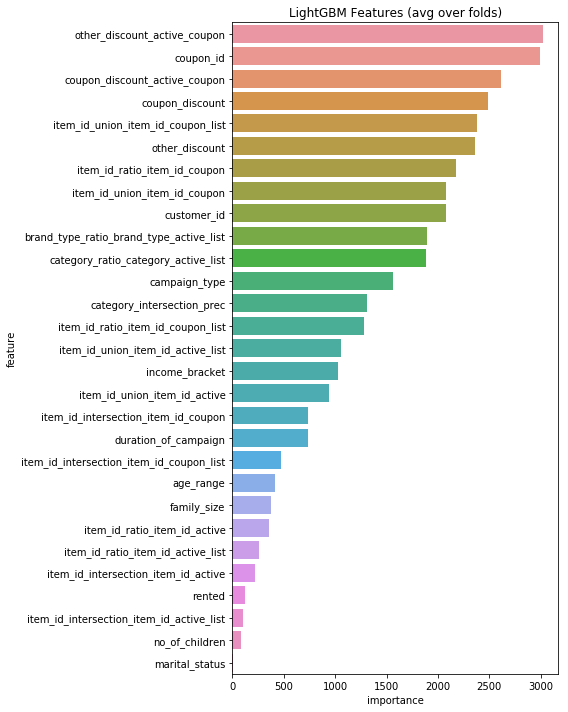

In [37]:
display_importances(feature_importance_df)

In [66]:
lgb_params['n_estimators'] = 7500
clf = LGBMClassifier().set_params(**lgb_params)

X_train = pd.concat([df_train, df_val], axis=0)
trn_x = X_train[all_cols]
trn_y = X_train['redemption_status']

clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y)], 
            eval_metric='logloss', verbose=200  #30
           )

[200]	training's binary_logloss: 0.0417792
[400]	training's binary_logloss: 0.0378439
[600]	training's binary_logloss: 0.0358542
[800]	training's binary_logloss: 0.0346376
[1000]	training's binary_logloss: 0.0338404
[1200]	training's binary_logloss: 0.0332808
[1400]	training's binary_logloss: 0.032844
[1600]	training's binary_logloss: 0.0324765
[1800]	training's binary_logloss: 0.0321771
[2000]	training's binary_logloss: 0.0319375
[2200]	training's binary_logloss: 0.031726
[2400]	training's binary_logloss: 0.0315381
[2600]	training's binary_logloss: 0.0313694
[2800]	training's binary_logloss: 0.0312205
[3000]	training's binary_logloss: 0.0310889
[3200]	training's binary_logloss: 0.0309695
[3400]	training's binary_logloss: 0.0308606
[3600]	training's binary_logloss: 0.0307567
[3800]	training's binary_logloss: 0.0306548
[4000]	training's binary_logloss: 0.0305572
[4200]	training's binary_logloss: 0.0304692
[4400]	training's binary_logloss: 0.0303807
[4600]	training's binary_logloss: 0.03

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               importance_type='split', learning_rate=0.002, max_depth=3,
               metric='logloss', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=7500, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=49, reg_alpha=10, reg_lambda=10,
               silent=True, subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)

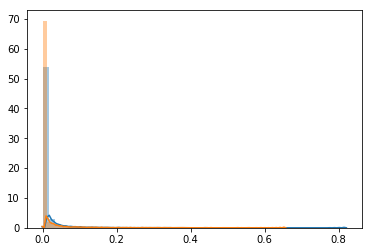

In [67]:
test_preds = clf.predict_proba(df_test[all_cols])[:, 1]
plt.figure()
sns.distplot(test_preds)
sns.distplot(oof_preds)
plt.show()

In [68]:
sub = pd.read_csv('../input/sample_submission_Byiv0dS.csv')
sub['redemption_status'] = test_preds
sub.head()

,id,redemption_status
0,3,0.435795
1,4,0.019887
2,5,0.006240
3,8,0.000522
4,10,0.000908


In [69]:
sub.to_csv('../submission/11.csv', index=False)

In [70]:
sub.head()

,id,redemption_status
0,3,0.435795
1,4,0.019887
2,5,0.006240
3,8,0.000522
4,10,0.000908


In [64]:
temp = pd.read_csv('../submission/11.csv')
temp.head()

,id,redemption_status
0,3,0.635235
1,4,0.012399
2,5,0.015050
3,8,0.000404
4,10,0.000696


In [71]:
num_feats+cat_feats

['duration_of_campaign',
 'other_discount',
 'coupon_discount',
 'item_id_intersection_item_id_coupon',
 'item_id_union_item_id_coupon',
 'item_id_ratio_item_id_coupon',
 'other_discount_active_coupon',
 'coupon_discount_active_coupon',
 'item_id_intersection_item_id_active',
 'item_id_union_item_id_active',
 'item_id_ratio_item_id_active',
 'customer_redemption_status_mean',
 'customer_id',
 'coupon_id',
 'item_id_intersection_item_id_coupon_list',
 'item_id_union_item_id_coupon_list',
 'item_id_ratio_item_id_coupon_list',
 'item_id_intersection_item_id_active_list',
 'item_id_union_item_id_active_list',
 'item_id_ratio_item_id_active_list',
 'age_range',
 'marital_status',
 'rented',
 'family_size',
 'no_of_children',
 'income_bracket',
 'campaign_type']

In [76]:
cat_feats = ['age_range', 'marital_status', 'rented', 'family_size',
       'no_of_children', 'income_bracket', 'campaign_type']
num_feats = ['duration_of_campaign', 'other_discount',
       'coupon_discount',
       'item_id_intersection_item_id_coupon', 
             'item_id_union_item_id_coupon',
       'item_id_ratio_item_id_coupon', 
#             'item_redemption_status_mean',
#             'item_id_active_coupon',
       'other_discount_active_coupon', 'coupon_discount_active_coupon',
       'item_id_intersection_item_id_active', 'item_id_union_item_id_active',
       'item_id_ratio_item_id_active', 'customer_redemption_status_mean','customer_id','coupon_id',
       'item_id_intersection_item_id_coupon_list', 
             'item_id_union_item_id_coupon_list',
       'item_id_ratio_item_id_coupon_list','item_id_intersection_item_id_active_list',
             'item_id_union_item_id_active_list',
       'item_id_ratio_item_id_active_list']
ints_unions = [col for col in df_train.columns if 'intersection' in col  or 'union' in col or 'ratio' in col]

add_feats= ['brand_type_ratio_brand_type_active_list',
'category_ratio_category_active_list',
'category_intersection_prec']
# num_feats = num_feats+add_feats


In [98]:
lgb_params = {
        'random_state':49,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'logloss',
        'learning_rate': 0.002,
        'subsample': .8,
        'colsample_bytree': .4,
        'reg_alpha': 10,
        'reg_lambda': 10,
        'n_estimators': 10000,
        'max_depth': 3
    }


oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                    , df_train['redemption_status'], df_val['redemption_status']
                                                    , num_feats+cat_feats+add_feats,50, **lgb_params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0373362	valid_1's binary_logloss: 0.0627099
[200]	training's binary_logloss: 0.0339524	valid_1's binary_logloss: 0.0577138
[300]	training's binary_logloss: 0.0318338	valid_1's binary_logloss: 0.0543541
[400]	training's binary_logloss: 0.0303717	valid_1's binary_logloss: 0.0520932
[500]	training's binary_logloss: 0.0292755	valid_1's binary_logloss: 0.0504951
[600]	training's binary_logloss: 0.0284167	valid_1's binary_logloss: 0.0492563
[700]	training's binary_logloss: 0.0277462	valid_1's binary_logloss: 0.0482885
[800]	training's binary_logloss: 0.0271965	valid_1's binary_logloss: 0.0475923
[900]	training's binary_logloss: 0.0267468	valid_1's binary_logloss: 0.0470292
[1000]	training's binary_logloss: 0.0263712	valid_1's binary_logloss: 0.0466091
[1100]	training's binary_logloss: 0.0260686	valid_1's binary_logloss: 0.0462337
[1200]	training's binary_logloss: 0.0257968	valid_1's binary_loglos

In [92]:
lgb_params['n_estimators'] = 7500
clf = LGBMClassifier().set_params(**lgb_params)

X_train = pd.concat([df_train, df_val], axis=0)
trn_x = X_train[num_feats+cat_feats+add_feats]
trn_y = X_train['redemption_status']

clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y)], 
            eval_metric='logloss', verbose=200  #30
           )

[200]	training's binary_logloss: 0.0407541
[400]	training's binary_logloss: 0.036584
[600]	training's binary_logloss: 0.0344483
[800]	training's binary_logloss: 0.033113
[1000]	training's binary_logloss: 0.0322144
[1200]	training's binary_logloss: 0.0315826
[1400]	training's binary_logloss: 0.0310944
[1600]	training's binary_logloss: 0.0307072
[1800]	training's binary_logloss: 0.0303657
[2000]	training's binary_logloss: 0.0300842
[2200]	training's binary_logloss: 0.0298568
[2400]	training's binary_logloss: 0.0296577
[2600]	training's binary_logloss: 0.0294884
[2800]	training's binary_logloss: 0.0293311
[3000]	training's binary_logloss: 0.0291867
[3200]	training's binary_logloss: 0.0290569
[3400]	training's binary_logloss: 0.02894
[3600]	training's binary_logloss: 0.0288302
[3800]	training's binary_logloss: 0.0287297
[4000]	training's binary_logloss: 0.0286334
[4200]	training's binary_logloss: 0.0285392
[4400]	training's binary_logloss: 0.0284518
[4600]	training's binary_logloss: 0.0283

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               importance_type='split', learning_rate=0.002, max_depth=3,
               metric='logloss', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=7500, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=49, reg_alpha=10, reg_lambda=10,
               silent=True, subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)

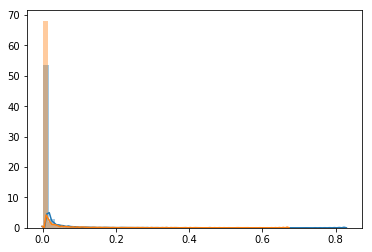

In [93]:
test_preds = clf.predict_proba(df_test[num_feats+cat_feats+add_feats])[:, 1]
plt.figure()
sns.distplot(test_preds)
sns.distplot(oof_preds)
plt.show()

In [94]:
sub = pd.read_csv('../input/sample_submission_Byiv0dS.csv')
sub['redemption_status'] = test_preds
sub.head()

,id,redemption_status
0,3,0.629270
1,4,0.012314
2,5,0.014363
3,8,0.000433
4,10,0.000583


In [95]:
sub.to_csv('../submission/11.csv', index=False)

In [247]:
for s in range(200):
    print(s)
    lgb_params = {
            'random_state':s,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'logloss',
            'learning_rate': 0.002,
            'subsample': .8,
            'colsample_bytree': .4,
            'reg_alpha': 10,
            'reg_lambda': 10,
            'n_estimators': 15000,
            'max_depth': 2
        }


    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        ,num_feats+cat_feats+add_feats,50, **lgb_params)
    

0
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.037591	valid_1's binary_logloss: 0.0632998
[200]	training's binary_logloss: 0.0345022	valid_1's binary_logloss: 0.0586911
[300]	training's binary_logloss: 0.0324802	valid_1's binary_logloss: 0.0556267
[400]	training's binary_logloss: 0.0310948	valid_1's binary_logloss: 0.0533796
[500]	training's binary_logloss: 0.0300355	valid_1's binary_logloss: 0.0517713
[600]	training's binary_logloss: 0.0292325	valid_1's binary_logloss: 0.0505035
[700]	training's binary_logloss: 0.028604	valid_1's binary_logloss: 0.0495142
[800]	training's binary_logloss: 0.0280625	valid_1's binary_logloss: 0.0488059
[900]	training's binary_logloss: 0.0276391	valid_1's binary_logloss: 0.0481877
[1000]	training's binary_logloss: 0.0272723	valid_1's binary_logloss: 0.0477
[1100]	training's binary_logloss: 0.0269648	valid_1's binary_logloss: 0.0472799
[1200]	training's binary_logloss: 0.0266909	valid_1's binary_logloss: 

[10400]	training's binary_logloss: 0.0231498	valid_1's binary_logloss: 0.0437148
[10500]	training's binary_logloss: 0.0231413	valid_1's binary_logloss: 0.0437103
[10600]	training's binary_logloss: 0.0231336	valid_1's binary_logloss: 0.0437058
[10700]	training's binary_logloss: 0.0231259	valid_1's binary_logloss: 0.0437018
Early stopping, best iteration is:
[10724]	training's binary_logloss: 0.0231243	valid_1's binary_logloss: 0.043701
Fold  1 AUC : 0.938915
1
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376163	valid_1's binary_logloss: 0.063449
[200]	training's binary_logloss: 0.0344946	valid_1's binary_logloss: 0.0587349
[300]	training's binary_logloss: 0.0324788	valid_1's binary_logloss: 0.0555857
[400]	training's binary_logloss: 0.0310889	valid_1's binary_logloss: 0.0533982
[500]	training's binary_logloss: 0.0300538	valid_1's binary_logloss: 0.05177
[600]	training's binary_logloss: 0.0292234	valid_1's binary_logloss: 0.0505256
[70

[6500]	training's binary_logloss: 0.0236163	valid_1's binary_logloss: 0.0439276
[6600]	training's binary_logloss: 0.0236004	valid_1's binary_logloss: 0.0439217
[6700]	training's binary_logloss: 0.0235842	valid_1's binary_logloss: 0.0439143
[6800]	training's binary_logloss: 0.0235687	valid_1's binary_logloss: 0.0439069
[6900]	training's binary_logloss: 0.0235532	valid_1's binary_logloss: 0.0439004
[7000]	training's binary_logloss: 0.0235376	valid_1's binary_logloss: 0.043896
[7100]	training's binary_logloss: 0.0235226	valid_1's binary_logloss: 0.0438891
[7200]	training's binary_logloss: 0.023507	valid_1's binary_logloss: 0.0438809
[7300]	training's binary_logloss: 0.0234922	valid_1's binary_logloss: 0.0438726
[7400]	training's binary_logloss: 0.023478	valid_1's binary_logloss: 0.0438663
[7500]	training's binary_logloss: 0.0234638	valid_1's binary_logloss: 0.0438596
[7600]	training's binary_logloss: 0.0234497	valid_1's binary_logloss: 0.0438522
[7700]	training's binary_logloss: 0.0234355

[5900]	training's binary_logloss: 0.0237319	valid_1's binary_logloss: 0.0439916
[6000]	training's binary_logloss: 0.0237129	valid_1's binary_logloss: 0.0439852
[6100]	training's binary_logloss: 0.0236949	valid_1's binary_logloss: 0.0439788
[6200]	training's binary_logloss: 0.0236774	valid_1's binary_logloss: 0.0439735
[6300]	training's binary_logloss: 0.0236607	valid_1's binary_logloss: 0.0439674
[6400]	training's binary_logloss: 0.023644	valid_1's binary_logloss: 0.0439604
[6500]	training's binary_logloss: 0.0236269	valid_1's binary_logloss: 0.0439539
[6600]	training's binary_logloss: 0.0236101	valid_1's binary_logloss: 0.0439472
[6700]	training's binary_logloss: 0.0235932	valid_1's binary_logloss: 0.0439407
[6800]	training's binary_logloss: 0.0235772	valid_1's binary_logloss: 0.0439369
[6900]	training's binary_logloss: 0.0235615	valid_1's binary_logloss: 0.0439313
[7000]	training's binary_logloss: 0.0235465	valid_1's binary_logloss: 0.0439246
[7100]	training's binary_logloss: 0.02353

[5300]	training's binary_logloss: 0.0238416	valid_1's binary_logloss: 0.0439979
[5400]	training's binary_logloss: 0.0238216	valid_1's binary_logloss: 0.0439824
[5500]	training's binary_logloss: 0.0238014	valid_1's binary_logloss: 0.0439712
[5600]	training's binary_logloss: 0.0237818	valid_1's binary_logloss: 0.0439613
[5700]	training's binary_logloss: 0.0237623	valid_1's binary_logloss: 0.0439523
[5800]	training's binary_logloss: 0.0237436	valid_1's binary_logloss: 0.0439457
[5900]	training's binary_logloss: 0.023725	valid_1's binary_logloss: 0.0439392
[6000]	training's binary_logloss: 0.0237072	valid_1's binary_logloss: 0.0439316
[6100]	training's binary_logloss: 0.0236893	valid_1's binary_logloss: 0.0439241
[6200]	training's binary_logloss: 0.0236722	valid_1's binary_logloss: 0.043916
[6300]	training's binary_logloss: 0.0236554	valid_1's binary_logloss: 0.0439101
[6400]	training's binary_logloss: 0.0236383	valid_1's binary_logloss: 0.0439051
[6500]	training's binary_logloss: 0.023621

[4700]	training's binary_logloss: 0.0239637	valid_1's binary_logloss: 0.0441556
[4800]	training's binary_logloss: 0.0239391	valid_1's binary_logloss: 0.0441374
[4900]	training's binary_logloss: 0.0239157	valid_1's binary_logloss: 0.0441189
[5000]	training's binary_logloss: 0.0238923	valid_1's binary_logloss: 0.0441031
[5100]	training's binary_logloss: 0.0238702	valid_1's binary_logloss: 0.0440849
[5200]	training's binary_logloss: 0.0238492	valid_1's binary_logloss: 0.0440708
[5300]	training's binary_logloss: 0.0238284	valid_1's binary_logloss: 0.0440581
[5400]	training's binary_logloss: 0.0238078	valid_1's binary_logloss: 0.0440437
[5500]	training's binary_logloss: 0.0237882	valid_1's binary_logloss: 0.0440308
[5600]	training's binary_logloss: 0.023769	valid_1's binary_logloss: 0.0440161
[5700]	training's binary_logloss: 0.0237493	valid_1's binary_logloss: 0.0440083
[5800]	training's binary_logloss: 0.0237298	valid_1's binary_logloss: 0.0440001
[5900]	training's binary_logloss: 0.02371

[8000]	training's binary_logloss: 0.0233866	valid_1's binary_logloss: 0.0438435
[8100]	training's binary_logloss: 0.0233733	valid_1's binary_logloss: 0.0438375
[8200]	training's binary_logloss: 0.0233602	valid_1's binary_logloss: 0.043831
[8300]	training's binary_logloss: 0.0233476	valid_1's binary_logloss: 0.0438271
[8400]	training's binary_logloss: 0.0233347	valid_1's binary_logloss: 0.0438209
[8500]	training's binary_logloss: 0.0233223	valid_1's binary_logloss: 0.0438152
[8600]	training's binary_logloss: 0.0233099	valid_1's binary_logloss: 0.0438096
[8700]	training's binary_logloss: 0.0232982	valid_1's binary_logloss: 0.0438035
[8800]	training's binary_logloss: 0.0232866	valid_1's binary_logloss: 0.0437978
[8900]	training's binary_logloss: 0.0232758	valid_1's binary_logloss: 0.0437916
[9000]	training's binary_logloss: 0.0232651	valid_1's binary_logloss: 0.0437868
[9100]	training's binary_logloss: 0.0232548	valid_1's binary_logloss: 0.0437813
[9200]	training's binary_logloss: 0.02324

[7300]	training's binary_logloss: 0.0234945	valid_1's binary_logloss: 0.0438475
[7400]	training's binary_logloss: 0.0234793	valid_1's binary_logloss: 0.0438433
[7500]	training's binary_logloss: 0.0234644	valid_1's binary_logloss: 0.0438365
[7600]	training's binary_logloss: 0.0234498	valid_1's binary_logloss: 0.0438294
[7700]	training's binary_logloss: 0.0234361	valid_1's binary_logloss: 0.043826
[7800]	training's binary_logloss: 0.0234223	valid_1's binary_logloss: 0.0438193
[7900]	training's binary_logloss: 0.0234083	valid_1's binary_logloss: 0.0438137
[8000]	training's binary_logloss: 0.0233948	valid_1's binary_logloss: 0.0438092
[8100]	training's binary_logloss: 0.0233814	valid_1's binary_logloss: 0.0438026
[8200]	training's binary_logloss: 0.0233683	valid_1's binary_logloss: 0.043797
[8300]	training's binary_logloss: 0.0233551	valid_1's binary_logloss: 0.0437911
[8400]	training's binary_logloss: 0.0233427	valid_1's binary_logloss: 0.0437872
[8500]	training's binary_logloss: 0.023330

[6700]	training's binary_logloss: 0.0235975	valid_1's binary_logloss: 0.0439447
[6800]	training's binary_logloss: 0.023581	valid_1's binary_logloss: 0.0439364
[6900]	training's binary_logloss: 0.0235657	valid_1's binary_logloss: 0.0439311
[7000]	training's binary_logloss: 0.0235508	valid_1's binary_logloss: 0.0439261
[7100]	training's binary_logloss: 0.0235349	valid_1's binary_logloss: 0.0439192
[7200]	training's binary_logloss: 0.0235194	valid_1's binary_logloss: 0.0439132
[7300]	training's binary_logloss: 0.0235048	valid_1's binary_logloss: 0.0439063
[7400]	training's binary_logloss: 0.0234902	valid_1's binary_logloss: 0.0438995
[7500]	training's binary_logloss: 0.0234756	valid_1's binary_logloss: 0.0438916
[7600]	training's binary_logloss: 0.0234611	valid_1's binary_logloss: 0.0438864
[7700]	training's binary_logloss: 0.023447	valid_1's binary_logloss: 0.0438803
[7800]	training's binary_logloss: 0.0234327	valid_1's binary_logloss: 0.0438737
[7900]	training's binary_logloss: 0.023418

[6000]	training's binary_logloss: 0.0237059	valid_1's binary_logloss: 0.0439899
[6100]	training's binary_logloss: 0.0236881	valid_1's binary_logloss: 0.0439819
[6200]	training's binary_logloss: 0.0236711	valid_1's binary_logloss: 0.0439759
[6300]	training's binary_logloss: 0.0236541	valid_1's binary_logloss: 0.0439678
[6400]	training's binary_logloss: 0.0236375	valid_1's binary_logloss: 0.0439613
[6500]	training's binary_logloss: 0.0236202	valid_1's binary_logloss: 0.0439559
[6600]	training's binary_logloss: 0.0236041	valid_1's binary_logloss: 0.0439498
[6700]	training's binary_logloss: 0.0235881	valid_1's binary_logloss: 0.0439416
[6800]	training's binary_logloss: 0.0235727	valid_1's binary_logloss: 0.0439357
[6900]	training's binary_logloss: 0.0235569	valid_1's binary_logloss: 0.043929
[7000]	training's binary_logloss: 0.0235414	valid_1's binary_logloss: 0.0439217
[7100]	training's binary_logloss: 0.0235253	valid_1's binary_logloss: 0.0439169
[7200]	training's binary_logloss: 0.02351

[5400]	training's binary_logloss: 0.0238204	valid_1's binary_logloss: 0.0440018
[5500]	training's binary_logloss: 0.0238008	valid_1's binary_logloss: 0.0439909
[5600]	training's binary_logloss: 0.0237808	valid_1's binary_logloss: 0.0439784
[5700]	training's binary_logloss: 0.0237613	valid_1's binary_logloss: 0.04397
[5800]	training's binary_logloss: 0.0237427	valid_1's binary_logloss: 0.0439591
[5900]	training's binary_logloss: 0.0237238	valid_1's binary_logloss: 0.043954
[6000]	training's binary_logloss: 0.023706	valid_1's binary_logloss: 0.0439469
[6100]	training's binary_logloss: 0.023688	valid_1's binary_logloss: 0.0439394
[6200]	training's binary_logloss: 0.0236699	valid_1's binary_logloss: 0.0439338
[6300]	training's binary_logloss: 0.0236523	valid_1's binary_logloss: 0.0439263
[6400]	training's binary_logloss: 0.0236351	valid_1's binary_logloss: 0.0439195
[6500]	training's binary_logloss: 0.0236186	valid_1's binary_logloss: 0.0439126
[6600]	training's binary_logloss: 0.0236021	v

[4700]	training's binary_logloss: 0.023969	valid_1's binary_logloss: 0.0440326
[4800]	training's binary_logloss: 0.0239439	valid_1's binary_logloss: 0.0440113
[4900]	training's binary_logloss: 0.02392	valid_1's binary_logloss: 0.043993
[5000]	training's binary_logloss: 0.0238975	valid_1's binary_logloss: 0.0439792
[5100]	training's binary_logloss: 0.0238748	valid_1's binary_logloss: 0.0439644
[5200]	training's binary_logloss: 0.0238536	valid_1's binary_logloss: 0.0439495
[5300]	training's binary_logloss: 0.0238331	valid_1's binary_logloss: 0.0439339
[5400]	training's binary_logloss: 0.0238126	valid_1's binary_logloss: 0.04392
[5500]	training's binary_logloss: 0.0237923	valid_1's binary_logloss: 0.0439094
[5600]	training's binary_logloss: 0.0237725	valid_1's binary_logloss: 0.0438956
[5700]	training's binary_logloss: 0.0237537	valid_1's binary_logloss: 0.0438854
[5800]	training's binary_logloss: 0.0237343	valid_1's binary_logloss: 0.043877
[5900]	training's binary_logloss: 0.0237157	val

[4100]	training's binary_logloss: 0.0241386	valid_1's binary_logloss: 0.0442731
[4200]	training's binary_logloss: 0.0241073	valid_1's binary_logloss: 0.0442403
[4300]	training's binary_logloss: 0.0240773	valid_1's binary_logloss: 0.0442108
[4400]	training's binary_logloss: 0.0240487	valid_1's binary_logloss: 0.0441877
[4500]	training's binary_logloss: 0.0240217	valid_1's binary_logloss: 0.0441645
[4600]	training's binary_logloss: 0.023996	valid_1's binary_logloss: 0.0441388
[4700]	training's binary_logloss: 0.0239703	valid_1's binary_logloss: 0.0441167
[4800]	training's binary_logloss: 0.0239454	valid_1's binary_logloss: 0.0440975
[4900]	training's binary_logloss: 0.0239222	valid_1's binary_logloss: 0.0440812
[5000]	training's binary_logloss: 0.0238993	valid_1's binary_logloss: 0.0440682
[5100]	training's binary_logloss: 0.0238773	valid_1's binary_logloss: 0.0440523
[5200]	training's binary_logloss: 0.0238559	valid_1's binary_logloss: 0.0440347
[5300]	training's binary_logloss: 0.02383

[3500]	training's binary_logloss: 0.0243505	valid_1's binary_logloss: 0.0444158
[3600]	training's binary_logloss: 0.0243112	valid_1's binary_logloss: 0.0443809
[3700]	training's binary_logloss: 0.024274	valid_1's binary_logloss: 0.0443446
[3800]	training's binary_logloss: 0.0242372	valid_1's binary_logloss: 0.0443152
[3900]	training's binary_logloss: 0.024204	valid_1's binary_logloss: 0.0442864
[4000]	training's binary_logloss: 0.02417	valid_1's binary_logloss: 0.0442539
[4100]	training's binary_logloss: 0.0241376	valid_1's binary_logloss: 0.0442272
[4200]	training's binary_logloss: 0.0241069	valid_1's binary_logloss: 0.0441984
[4300]	training's binary_logloss: 0.0240777	valid_1's binary_logloss: 0.0441652
[4400]	training's binary_logloss: 0.0240495	valid_1's binary_logloss: 0.0441373
[4500]	training's binary_logloss: 0.0240219	valid_1's binary_logloss: 0.0441132
[4600]	training's binary_logloss: 0.0239955	valid_1's binary_logloss: 0.0440881
[4700]	training's binary_logloss: 0.0239708	

[13900]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14000]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14100]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14200]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14300]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14400]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14500]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14600]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14700]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14800]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[14900]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
[15000]	training's binary_logloss: 0.0231147	valid_1's binary_logloss: 0.0436363
Did not meet early stopping.

[8900]	training's binary_logloss: 0.0232935	valid_1's binary_logloss: 0.04383
[9000]	training's binary_logloss: 0.0232826	valid_1's binary_logloss: 0.0438245
[9100]	training's binary_logloss: 0.023272	valid_1's binary_logloss: 0.0438182
[9200]	training's binary_logloss: 0.0232619	valid_1's binary_logloss: 0.0438119
[9300]	training's binary_logloss: 0.0232517	valid_1's binary_logloss: 0.0438065
[9400]	training's binary_logloss: 0.023242	valid_1's binary_logloss: 0.0438004
[9500]	training's binary_logloss: 0.0232328	valid_1's binary_logloss: 0.0437952
[9600]	training's binary_logloss: 0.0232226	valid_1's binary_logloss: 0.0437904
[9700]	training's binary_logloss: 0.0232133	valid_1's binary_logloss: 0.0437851
[9800]	training's binary_logloss: 0.0232043	valid_1's binary_logloss: 0.0437795
[9900]	training's binary_logloss: 0.0231952	valid_1's binary_logloss: 0.0437743
[10000]	training's binary_logloss: 0.0231862	valid_1's binary_logloss: 0.0437712
[10100]	training's binary_logloss: 0.023177

[8300]	training's binary_logloss: 0.0233555	valid_1's binary_logloss: 0.0438254
[8400]	training's binary_logloss: 0.0233435	valid_1's binary_logloss: 0.0438204
[8500]	training's binary_logloss: 0.0233318	valid_1's binary_logloss: 0.0438158
[8600]	training's binary_logloss: 0.0233193	valid_1's binary_logloss: 0.0438104
[8700]	training's binary_logloss: 0.0233076	valid_1's binary_logloss: 0.0438055
[8800]	training's binary_logloss: 0.0232961	valid_1's binary_logloss: 0.0437983
[8900]	training's binary_logloss: 0.0232857	valid_1's binary_logloss: 0.0437931
[9000]	training's binary_logloss: 0.0232754	valid_1's binary_logloss: 0.0437863
[9100]	training's binary_logloss: 0.0232648	valid_1's binary_logloss: 0.0437788
[9200]	training's binary_logloss: 0.0232545	valid_1's binary_logloss: 0.0437746
[9300]	training's binary_logloss: 0.0232445	valid_1's binary_logloss: 0.0437689
[9400]	training's binary_logloss: 0.0232348	valid_1's binary_logloss: 0.0437645
[9500]	training's binary_logloss: 0.0232

[7600]	training's binary_logloss: 0.0234567	valid_1's binary_logloss: 0.0438269
[7700]	training's binary_logloss: 0.0234426	valid_1's binary_logloss: 0.0438209
[7800]	training's binary_logloss: 0.0234291	valid_1's binary_logloss: 0.0438138
[7900]	training's binary_logloss: 0.0234156	valid_1's binary_logloss: 0.0438087
[8000]	training's binary_logloss: 0.0234023	valid_1's binary_logloss: 0.043803
[8100]	training's binary_logloss: 0.0233885	valid_1's binary_logloss: 0.0437991
[8200]	training's binary_logloss: 0.0233753	valid_1's binary_logloss: 0.0437921
[8300]	training's binary_logloss: 0.0233624	valid_1's binary_logloss: 0.0437868
[8400]	training's binary_logloss: 0.0233494	valid_1's binary_logloss: 0.0437827
[8500]	training's binary_logloss: 0.0233374	valid_1's binary_logloss: 0.0437782
[8600]	training's binary_logloss: 0.0233256	valid_1's binary_logloss: 0.0437722
[8700]	training's binary_logloss: 0.0233136	valid_1's binary_logloss: 0.043766
[8800]	training's binary_logloss: 0.023302

[7000]	training's binary_logloss: 0.0235316	valid_1's binary_logloss: 0.0438348
[7100]	training's binary_logloss: 0.0235159	valid_1's binary_logloss: 0.0438276
[7200]	training's binary_logloss: 0.0235004	valid_1's binary_logloss: 0.0438204
[7300]	training's binary_logloss: 0.0234852	valid_1's binary_logloss: 0.0438159
[7400]	training's binary_logloss: 0.0234704	valid_1's binary_logloss: 0.0438089
[7500]	training's binary_logloss: 0.0234562	valid_1's binary_logloss: 0.0438028
[7600]	training's binary_logloss: 0.0234418	valid_1's binary_logloss: 0.0437973
[7700]	training's binary_logloss: 0.0234273	valid_1's binary_logloss: 0.0437906
[7800]	training's binary_logloss: 0.0234134	valid_1's binary_logloss: 0.0437833
[7900]	training's binary_logloss: 0.0233999	valid_1's binary_logloss: 0.0437774
[8000]	training's binary_logloss: 0.0233865	valid_1's binary_logloss: 0.0437711
[8100]	training's binary_logloss: 0.0233729	valid_1's binary_logloss: 0.0437653
[8200]	training's binary_logloss: 0.0233

[6400]	training's binary_logloss: 0.0236275	valid_1's binary_logloss: 0.0438467
[6500]	training's binary_logloss: 0.0236109	valid_1's binary_logloss: 0.0438403
[6600]	training's binary_logloss: 0.0235947	valid_1's binary_logloss: 0.0438335
[6700]	training's binary_logloss: 0.0235779	valid_1's binary_logloss: 0.0438266
[6800]	training's binary_logloss: 0.0235621	valid_1's binary_logloss: 0.0438191
[6900]	training's binary_logloss: 0.0235467	valid_1's binary_logloss: 0.0438131
[7000]	training's binary_logloss: 0.0235314	valid_1's binary_logloss: 0.0438061
[7100]	training's binary_logloss: 0.0235166	valid_1's binary_logloss: 0.043801
[7200]	training's binary_logloss: 0.0235023	valid_1's binary_logloss: 0.0437954
[7300]	training's binary_logloss: 0.023487	valid_1's binary_logloss: 0.0437898
[7400]	training's binary_logloss: 0.0234724	valid_1's binary_logloss: 0.0437834
[7500]	training's binary_logloss: 0.0234572	valid_1's binary_logloss: 0.0437768
[7600]	training's binary_logloss: 0.023443

[5700]	training's binary_logloss: 0.0237518	valid_1's binary_logloss: 0.0438853
[5800]	training's binary_logloss: 0.0237336	valid_1's binary_logloss: 0.0438764
[5900]	training's binary_logloss: 0.0237149	valid_1's binary_logloss: 0.0438696
[6000]	training's binary_logloss: 0.0236962	valid_1's binary_logloss: 0.0438619
[6100]	training's binary_logloss: 0.0236788	valid_1's binary_logloss: 0.0438542
[6200]	training's binary_logloss: 0.023661	valid_1's binary_logloss: 0.0438501
[6300]	training's binary_logloss: 0.023644	valid_1's binary_logloss: 0.0438452
[6400]	training's binary_logloss: 0.0236272	valid_1's binary_logloss: 0.0438421
[6500]	training's binary_logloss: 0.0236109	valid_1's binary_logloss: 0.0438361
[6600]	training's binary_logloss: 0.0235947	valid_1's binary_logloss: 0.0438278
[6700]	training's binary_logloss: 0.0235787	valid_1's binary_logloss: 0.0438227
[6800]	training's binary_logloss: 0.0235627	valid_1's binary_logloss: 0.0438167
[6900]	training's binary_logloss: 0.023547

[5100]	training's binary_logloss: 0.0238828	valid_1's binary_logloss: 0.0440093
[5200]	training's binary_logloss: 0.023861	valid_1's binary_logloss: 0.0439969
[5300]	training's binary_logloss: 0.0238407	valid_1's binary_logloss: 0.0439862
[5400]	training's binary_logloss: 0.0238199	valid_1's binary_logloss: 0.0439769
[5500]	training's binary_logloss: 0.0237998	valid_1's binary_logloss: 0.043966
[5600]	training's binary_logloss: 0.0237805	valid_1's binary_logloss: 0.0439549
[5700]	training's binary_logloss: 0.0237619	valid_1's binary_logloss: 0.0439453
[5800]	training's binary_logloss: 0.0237429	valid_1's binary_logloss: 0.0439395
[5900]	training's binary_logloss: 0.0237242	valid_1's binary_logloss: 0.0439322
[6000]	training's binary_logloss: 0.0237061	valid_1's binary_logloss: 0.0439254
[6100]	training's binary_logloss: 0.0236881	valid_1's binary_logloss: 0.0439184
[6200]	training's binary_logloss: 0.02367	valid_1's binary_logloss: 0.0439111
[6300]	training's binary_logloss: 0.0236529	

[4500]	training's binary_logloss: 0.0240226	valid_1's binary_logloss: 0.0441155
[4600]	training's binary_logloss: 0.0239956	valid_1's binary_logloss: 0.0440922
[4700]	training's binary_logloss: 0.0239699	valid_1's binary_logloss: 0.0440697
[4800]	training's binary_logloss: 0.0239453	valid_1's binary_logloss: 0.0440556
[4900]	training's binary_logloss: 0.0239223	valid_1's binary_logloss: 0.0440405
[5000]	training's binary_logloss: 0.0238993	valid_1's binary_logloss: 0.0440211
[5100]	training's binary_logloss: 0.023877	valid_1's binary_logloss: 0.0440025
[5200]	training's binary_logloss: 0.0238551	valid_1's binary_logloss: 0.0439857
[5300]	training's binary_logloss: 0.0238342	valid_1's binary_logloss: 0.043973
[5400]	training's binary_logloss: 0.0238141	valid_1's binary_logloss: 0.0439585
[5500]	training's binary_logloss: 0.0237941	valid_1's binary_logloss: 0.0439432
[5600]	training's binary_logloss: 0.0237749	valid_1's binary_logloss: 0.0439345
[5700]	training's binary_logloss: 0.023756

[4000]	training's binary_logloss: 0.0241649	valid_1's binary_logloss: 0.0442776
[4100]	training's binary_logloss: 0.0241329	valid_1's binary_logloss: 0.0442469
[4200]	training's binary_logloss: 0.0241024	valid_1's binary_logloss: 0.0442159
[4300]	training's binary_logloss: 0.0240733	valid_1's binary_logloss: 0.0441851
[4400]	training's binary_logloss: 0.0240449	valid_1's binary_logloss: 0.0441628
[4500]	training's binary_logloss: 0.0240181	valid_1's binary_logloss: 0.0441387
[4600]	training's binary_logloss: 0.023991	valid_1's binary_logloss: 0.0441147
[4700]	training's binary_logloss: 0.0239662	valid_1's binary_logloss: 0.0440906
[4800]	training's binary_logloss: 0.0239414	valid_1's binary_logloss: 0.0440676
[4900]	training's binary_logloss: 0.0239181	valid_1's binary_logloss: 0.0440526
[5000]	training's binary_logloss: 0.0238955	valid_1's binary_logloss: 0.0440362
[5100]	training's binary_logloss: 0.0238732	valid_1's binary_logloss: 0.0440223
[5200]	training's binary_logloss: 0.02385

[3300]	training's binary_logloss: 0.0244338	valid_1's binary_logloss: 0.0445675
[3400]	training's binary_logloss: 0.0243911	valid_1's binary_logloss: 0.0445197
[3500]	training's binary_logloss: 0.0243515	valid_1's binary_logloss: 0.0444822
[3600]	training's binary_logloss: 0.0243126	valid_1's binary_logloss: 0.0444415
[3700]	training's binary_logloss: 0.0242752	valid_1's binary_logloss: 0.0444037
[3800]	training's binary_logloss: 0.0242396	valid_1's binary_logloss: 0.0443722
[3900]	training's binary_logloss: 0.0242049	valid_1's binary_logloss: 0.04434
[4000]	training's binary_logloss: 0.0241724	valid_1's binary_logloss: 0.0443113
[4100]	training's binary_logloss: 0.0241402	valid_1's binary_logloss: 0.0442781
[4200]	training's binary_logloss: 0.0241084	valid_1's binary_logloss: 0.0442522
[4300]	training's binary_logloss: 0.0240787	valid_1's binary_logloss: 0.044221
[4400]	training's binary_logloss: 0.0240499	valid_1's binary_logloss: 0.0441987
[4500]	training's binary_logloss: 0.0240221

[2600]	training's binary_logloss: 0.0248331	valid_1's binary_logloss: 0.0449336
[2700]	training's binary_logloss: 0.0247658	valid_1's binary_logloss: 0.0448719
[2800]	training's binary_logloss: 0.0247056	valid_1's binary_logloss: 0.0448231
[2900]	training's binary_logloss: 0.0246476	valid_1's binary_logloss: 0.0447883
[3000]	training's binary_logloss: 0.024591	valid_1's binary_logloss: 0.0447379
[3100]	training's binary_logloss: 0.0245393	valid_1's binary_logloss: 0.0447051
[3200]	training's binary_logloss: 0.0244914	valid_1's binary_logloss: 0.0446537
[3300]	training's binary_logloss: 0.0244467	valid_1's binary_logloss: 0.0446054
[3400]	training's binary_logloss: 0.0244033	valid_1's binary_logloss: 0.0445554
[3500]	training's binary_logloss: 0.024364	valid_1's binary_logloss: 0.044515
[3600]	training's binary_logloss: 0.0243249	valid_1's binary_logloss: 0.0444741
[3700]	training's binary_logloss: 0.0242878	valid_1's binary_logloss: 0.0444385
[3800]	training's binary_logloss: 0.0242531

[1900]	training's binary_logloss: 0.0255064	valid_1's binary_logloss: 0.0453367
[2000]	training's binary_logloss: 0.0253869	valid_1's binary_logloss: 0.0452367
[2100]	training's binary_logloss: 0.0252728	valid_1's binary_logloss: 0.0451662
[2200]	training's binary_logloss: 0.025169	valid_1's binary_logloss: 0.0450584
[2300]	training's binary_logloss: 0.0250753	valid_1's binary_logloss: 0.0449538
[2400]	training's binary_logloss: 0.024986	valid_1's binary_logloss: 0.0448864
[2500]	training's binary_logloss: 0.0249053	valid_1's binary_logloss: 0.0447919
[2600]	training's binary_logloss: 0.0248294	valid_1's binary_logloss: 0.0447256
[2700]	training's binary_logloss: 0.0247576	valid_1's binary_logloss: 0.0446569
[2800]	training's binary_logloss: 0.0246924	valid_1's binary_logloss: 0.0446002
[2900]	training's binary_logloss: 0.0246292	valid_1's binary_logloss: 0.0445595
[3000]	training's binary_logloss: 0.0245725	valid_1's binary_logloss: 0.0445205
[3100]	training's binary_logloss: 0.024519

[1300]	training's binary_logloss: 0.0264519	valid_1's binary_logloss: 0.0465686
[1400]	training's binary_logloss: 0.0262482	valid_1's binary_logloss: 0.0463322
[1500]	training's binary_logloss: 0.0260666	valid_1's binary_logloss: 0.0461188
[1600]	training's binary_logloss: 0.0258984	valid_1's binary_logloss: 0.0459356
[1700]	training's binary_logloss: 0.0257483	valid_1's binary_logloss: 0.0458086
[1800]	training's binary_logloss: 0.0256127	valid_1's binary_logloss: 0.0456945
[1900]	training's binary_logloss: 0.0254883	valid_1's binary_logloss: 0.0455782
[2000]	training's binary_logloss: 0.0253665	valid_1's binary_logloss: 0.0454585
[2100]	training's binary_logloss: 0.0252569	valid_1's binary_logloss: 0.045325
[2200]	training's binary_logloss: 0.025157	valid_1's binary_logloss: 0.0452171
[2300]	training's binary_logloss: 0.0250649	valid_1's binary_logloss: 0.0451219
[2400]	training's binary_logloss: 0.0249804	valid_1's binary_logloss: 0.0450293
[2500]	training's binary_logloss: 0.024901

[700]	training's binary_logloss: 0.0285713	valid_1's binary_logloss: 0.0495333
[800]	training's binary_logloss: 0.0280493	valid_1's binary_logloss: 0.0487748
[900]	training's binary_logloss: 0.0276107	valid_1's binary_logloss: 0.0481934
[1000]	training's binary_logloss: 0.0272385	valid_1's binary_logloss: 0.0477345
[1100]	training's binary_logloss: 0.0269249	valid_1's binary_logloss: 0.047312
[1200]	training's binary_logloss: 0.0266585	valid_1's binary_logloss: 0.0469885
[1300]	training's binary_logloss: 0.0264341	valid_1's binary_logloss: 0.0466843
[1400]	training's binary_logloss: 0.0262267	valid_1's binary_logloss: 0.0464499
[1500]	training's binary_logloss: 0.0260428	valid_1's binary_logloss: 0.046248
[1600]	training's binary_logloss: 0.0258796	valid_1's binary_logloss: 0.046091
[1700]	training's binary_logloss: 0.0257432	valid_1's binary_logloss: 0.0459263
[1800]	training's binary_logloss: 0.0256128	valid_1's binary_logloss: 0.0458131
[1900]	training's binary_logloss: 0.0254892	va

28
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0377177	valid_1's binary_logloss: 0.0635003
[200]	training's binary_logloss: 0.0346172	valid_1's binary_logloss: 0.0586906
[300]	training's binary_logloss: 0.0325713	valid_1's binary_logloss: 0.0554776
[400]	training's binary_logloss: 0.0311597	valid_1's binary_logloss: 0.0532699
[500]	training's binary_logloss: 0.0301	valid_1's binary_logloss: 0.0517059
[600]	training's binary_logloss: 0.0292917	valid_1's binary_logloss: 0.0504149
[700]	training's binary_logloss: 0.0286362	valid_1's binary_logloss: 0.0494328
[800]	training's binary_logloss: 0.0280951	valid_1's binary_logloss: 0.0487167
[900]	training's binary_logloss: 0.0276472	valid_1's binary_logloss: 0.0481214
[1000]	training's binary_logloss: 0.0272698	valid_1's binary_logloss: 0.0476381
[1100]	training's binary_logloss: 0.0269568	valid_1's binary_logloss: 0.0472161
[1200]	training's binary_logloss: 0.0266876	valid_1's binary_loglos

[10300]	training's binary_logloss: 0.0231487	valid_1's binary_logloss: 0.0436692
[10400]	training's binary_logloss: 0.0231403	valid_1's binary_logloss: 0.0436658
[10500]	training's binary_logloss: 0.0231323	valid_1's binary_logloss: 0.0436623
[10600]	training's binary_logloss: 0.0231247	valid_1's binary_logloss: 0.0436588
[10700]	training's binary_logloss: 0.0231196	valid_1's binary_logloss: 0.043656
Early stopping, best iteration is:
[10674]	training's binary_logloss: 0.0231198	valid_1's binary_logloss: 0.043656
Fold  1 AUC : 0.938862
29
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376137	valid_1's binary_logloss: 0.0634164
[200]	training's binary_logloss: 0.0345723	valid_1's binary_logloss: 0.0586909
[300]	training's binary_logloss: 0.0325418	valid_1's binary_logloss: 0.0556348
[400]	training's binary_logloss: 0.0311558	valid_1's binary_logloss: 0.0533584
[500]	training's binary_logloss: 0.0301051	valid_1's binary_logloss: 0.051692

[9700]	training's binary_logloss: 0.0232002	valid_1's binary_logloss: 0.0437195
[9800]	training's binary_logloss: 0.0231913	valid_1's binary_logloss: 0.043715
[9900]	training's binary_logloss: 0.0231819	valid_1's binary_logloss: 0.0437099
[10000]	training's binary_logloss: 0.0231736	valid_1's binary_logloss: 0.0437057
[10100]	training's binary_logloss: 0.0231646	valid_1's binary_logloss: 0.0437007
[10200]	training's binary_logloss: 0.0231558	valid_1's binary_logloss: 0.0436974
[10300]	training's binary_logloss: 0.0231475	valid_1's binary_logloss: 0.043693
[10400]	training's binary_logloss: 0.0231394	valid_1's binary_logloss: 0.0436891
[10500]	training's binary_logloss: 0.0231316	valid_1's binary_logloss: 0.0436858
[10600]	training's binary_logloss: 0.0231239	valid_1's binary_logloss: 0.0436816
[10700]	training's binary_logloss: 0.0231162	valid_1's binary_logloss: 0.0436782
Early stopping, best iteration is:
[10729]	training's binary_logloss: 0.0231148	valid_1's binary_logloss: 0.043676

[9100]	training's binary_logloss: 0.0232698	valid_1's binary_logloss: 0.0437966
[9200]	training's binary_logloss: 0.0232599	valid_1's binary_logloss: 0.0437915
[9300]	training's binary_logloss: 0.0232496	valid_1's binary_logloss: 0.0437863
[9400]	training's binary_logloss: 0.0232395	valid_1's binary_logloss: 0.0437815
[9500]	training's binary_logloss: 0.0232303	valid_1's binary_logloss: 0.0437763
[9600]	training's binary_logloss: 0.0232206	valid_1's binary_logloss: 0.0437723
[9700]	training's binary_logloss: 0.023211	valid_1's binary_logloss: 0.0437665
[9800]	training's binary_logloss: 0.0232021	valid_1's binary_logloss: 0.0437616
[9900]	training's binary_logloss: 0.0231927	valid_1's binary_logloss: 0.0437567
[10000]	training's binary_logloss: 0.0231841	valid_1's binary_logloss: 0.043752
[10100]	training's binary_logloss: 0.0231756	valid_1's binary_logloss: 0.0437481
[10200]	training's binary_logloss: 0.0231667	valid_1's binary_logloss: 0.0437428
[10300]	training's binary_logloss: 0.02

[8400]	training's binary_logloss: 0.0233585	valid_1's binary_logloss: 0.0438422
[8500]	training's binary_logloss: 0.0233459	valid_1's binary_logloss: 0.0438366
[8600]	training's binary_logloss: 0.0233339	valid_1's binary_logloss: 0.0438285
[8700]	training's binary_logloss: 0.0233221	valid_1's binary_logloss: 0.0438238
[8800]	training's binary_logloss: 0.0233108	valid_1's binary_logloss: 0.043819
[8900]	training's binary_logloss: 0.0232997	valid_1's binary_logloss: 0.0438136
[9000]	training's binary_logloss: 0.0232893	valid_1's binary_logloss: 0.043808
[9100]	training's binary_logloss: 0.0232792	valid_1's binary_logloss: 0.0438026
[9200]	training's binary_logloss: 0.0232691	valid_1's binary_logloss: 0.0437966
[9300]	training's binary_logloss: 0.0232589	valid_1's binary_logloss: 0.0437912
[9400]	training's binary_logloss: 0.023249	valid_1's binary_logloss: 0.0437856
[9500]	training's binary_logloss: 0.0232394	valid_1's binary_logloss: 0.0437808
[9600]	training's binary_logloss: 0.02323	v

[7700]	training's binary_logloss: 0.0234387	valid_1's binary_logloss: 0.0438512
[7800]	training's binary_logloss: 0.0234252	valid_1's binary_logloss: 0.0438449
[7900]	training's binary_logloss: 0.0234116	valid_1's binary_logloss: 0.043839
[8000]	training's binary_logloss: 0.0233977	valid_1's binary_logloss: 0.0438336
[8100]	training's binary_logloss: 0.0233845	valid_1's binary_logloss: 0.0438282
[8200]	training's binary_logloss: 0.0233712	valid_1's binary_logloss: 0.0438218
[8300]	training's binary_logloss: 0.0233584	valid_1's binary_logloss: 0.0438149
[8400]	training's binary_logloss: 0.0233458	valid_1's binary_logloss: 0.043811
[8500]	training's binary_logloss: 0.0233332	valid_1's binary_logloss: 0.043807
[8600]	training's binary_logloss: 0.0233211	valid_1's binary_logloss: 0.0438013
[8700]	training's binary_logloss: 0.0233095	valid_1's binary_logloss: 0.0437951
[8800]	training's binary_logloss: 0.0232978	valid_1's binary_logloss: 0.0437876
[8900]	training's binary_logloss: 0.0232866

[900]	training's binary_logloss: 0.0276473	valid_1's binary_logloss: 0.0481911
[1000]	training's binary_logloss: 0.0272701	valid_1's binary_logloss: 0.0476997
[1100]	training's binary_logloss: 0.0269479	valid_1's binary_logloss: 0.0472924
[1200]	training's binary_logloss: 0.0266752	valid_1's binary_logloss: 0.046955
[1300]	training's binary_logloss: 0.0264446	valid_1's binary_logloss: 0.0466694
[1400]	training's binary_logloss: 0.0262417	valid_1's binary_logloss: 0.0464123
[1500]	training's binary_logloss: 0.0260608	valid_1's binary_logloss: 0.046187
[1600]	training's binary_logloss: 0.0258924	valid_1's binary_logloss: 0.0460067
[1700]	training's binary_logloss: 0.0257473	valid_1's binary_logloss: 0.0458473
[1800]	training's binary_logloss: 0.0256168	valid_1's binary_logloss: 0.0457249
[1900]	training's binary_logloss: 0.0254942	valid_1's binary_logloss: 0.0456052
[2000]	training's binary_logloss: 0.0253787	valid_1's binary_logloss: 0.0454806
[2100]	training's binary_logloss: 0.0252661

[200]	training's binary_logloss: 0.0343602	valid_1's binary_logloss: 0.0587985
[300]	training's binary_logloss: 0.0324298	valid_1's binary_logloss: 0.0557287
[400]	training's binary_logloss: 0.0310539	valid_1's binary_logloss: 0.053518
[500]	training's binary_logloss: 0.0300251	valid_1's binary_logloss: 0.051887
[600]	training's binary_logloss: 0.0292048	valid_1's binary_logloss: 0.0506889
[700]	training's binary_logloss: 0.0285641	valid_1's binary_logloss: 0.049714
[800]	training's binary_logloss: 0.0280519	valid_1's binary_logloss: 0.0489302
[900]	training's binary_logloss: 0.0276109	valid_1's binary_logloss: 0.0483332
[1000]	training's binary_logloss: 0.0272434	valid_1's binary_logloss: 0.0478466
[1100]	training's binary_logloss: 0.0269353	valid_1's binary_logloss: 0.0474155
[1200]	training's binary_logloss: 0.0266651	valid_1's binary_logloss: 0.0470563
[1300]	training's binary_logloss: 0.0264282	valid_1's binary_logloss: 0.0467731
[1400]	training's binary_logloss: 0.0262283	valid_1

[10500]	training's binary_logloss: 0.0231412	valid_1's binary_logloss: 0.0437584
[10600]	training's binary_logloss: 0.0231335	valid_1's binary_logloss: 0.0437547
[10700]	training's binary_logloss: 0.0231257	valid_1's binary_logloss: 0.0437513
[10800]	training's binary_logloss: 0.0231192	valid_1's binary_logloss: 0.0437478
Early stopping, best iteration is:
[10777]	training's binary_logloss: 0.0231202	valid_1's binary_logloss: 0.0437478
Fold  1 AUC : 0.938893
36
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.037749	valid_1's binary_logloss: 0.0635562
[200]	training's binary_logloss: 0.0345336	valid_1's binary_logloss: 0.0588206
[300]	training's binary_logloss: 0.0325398	valid_1's binary_logloss: 0.0556549
[400]	training's binary_logloss: 0.0311229	valid_1's binary_logloss: 0.0533712
[500]	training's binary_logloss: 0.0300909	valid_1's binary_logloss: 0.0516953
[600]	training's binary_logloss: 0.0292836	valid_1's binary_logloss: 0.0503935

[9800]	training's binary_logloss: 0.0231811	valid_1's binary_logloss: 0.043693
[9900]	training's binary_logloss: 0.0231725	valid_1's binary_logloss: 0.0436884
[10000]	training's binary_logloss: 0.0231632	valid_1's binary_logloss: 0.0436844
[10100]	training's binary_logloss: 0.0231542	valid_1's binary_logloss: 0.0436797
[10200]	training's binary_logloss: 0.0231455	valid_1's binary_logloss: 0.043677
[10300]	training's binary_logloss: 0.0231372	valid_1's binary_logloss: 0.0436729
[10400]	training's binary_logloss: 0.0231288	valid_1's binary_logloss: 0.0436696
[10500]	training's binary_logloss: 0.023121	valid_1's binary_logloss: 0.0436652
[10600]	training's binary_logloss: 0.0231136	valid_1's binary_logloss: 0.0436612
[10700]	training's binary_logloss: 0.0231058	valid_1's binary_logloss: 0.0436565
Early stopping, best iteration is:
[10737]	training's binary_logloss: 0.0231032	valid_1's binary_logloss: 0.0436554
Fold  1 AUC : 0.938768
37
Training until validation scores don't improve for 50

[9200]	training's binary_logloss: 0.0232574	valid_1's binary_logloss: 0.0437961
[9300]	training's binary_logloss: 0.0232478	valid_1's binary_logloss: 0.0437902
[9400]	training's binary_logloss: 0.0232376	valid_1's binary_logloss: 0.0437852
[9500]	training's binary_logloss: 0.0232277	valid_1's binary_logloss: 0.04378
[9600]	training's binary_logloss: 0.0232186	valid_1's binary_logloss: 0.0437746
[9700]	training's binary_logloss: 0.023209	valid_1's binary_logloss: 0.0437699
[9800]	training's binary_logloss: 0.0232001	valid_1's binary_logloss: 0.0437655
[9900]	training's binary_logloss: 0.0231912	valid_1's binary_logloss: 0.0437594
[10000]	training's binary_logloss: 0.0231823	valid_1's binary_logloss: 0.0437545
[10100]	training's binary_logloss: 0.0231737	valid_1's binary_logloss: 0.0437521
[10200]	training's binary_logloss: 0.0231653	valid_1's binary_logloss: 0.043748
[10300]	training's binary_logloss: 0.0231568	valid_1's binary_logloss: 0.0437444
[10400]	training's binary_logloss: 0.023

[8600]	training's binary_logloss: 0.0233086	valid_1's binary_logloss: 0.043749
[8700]	training's binary_logloss: 0.0232969	valid_1's binary_logloss: 0.0437446
[8800]	training's binary_logloss: 0.0232851	valid_1's binary_logloss: 0.0437391
[8900]	training's binary_logloss: 0.0232745	valid_1's binary_logloss: 0.0437338
[9000]	training's binary_logloss: 0.0232642	valid_1's binary_logloss: 0.0437275
[9100]	training's binary_logloss: 0.0232539	valid_1's binary_logloss: 0.0437221
[9200]	training's binary_logloss: 0.0232442	valid_1's binary_logloss: 0.0437173
[9300]	training's binary_logloss: 0.0232337	valid_1's binary_logloss: 0.0437121
[9400]	training's binary_logloss: 0.023224	valid_1's binary_logloss: 0.0437072
[9500]	training's binary_logloss: 0.0232141	valid_1's binary_logloss: 0.043702
[9600]	training's binary_logloss: 0.0232049	valid_1's binary_logloss: 0.0436974
[9700]	training's binary_logloss: 0.0231958	valid_1's binary_logloss: 0.0436916
[9800]	training's binary_logloss: 0.0231869

[8000]	training's binary_logloss: 0.023371	valid_1's binary_logloss: 0.0437445
[8100]	training's binary_logloss: 0.0233568	valid_1's binary_logloss: 0.0437398
[8200]	training's binary_logloss: 0.0233438	valid_1's binary_logloss: 0.0437368
[8300]	training's binary_logloss: 0.0233307	valid_1's binary_logloss: 0.0437322
[8400]	training's binary_logloss: 0.0233181	valid_1's binary_logloss: 0.0437277
[8500]	training's binary_logloss: 0.0233062	valid_1's binary_logloss: 0.0437218
[8600]	training's binary_logloss: 0.0232943	valid_1's binary_logloss: 0.0437155
[8700]	training's binary_logloss: 0.0232829	valid_1's binary_logloss: 0.0437102
[8800]	training's binary_logloss: 0.0232711	valid_1's binary_logloss: 0.0437057
[8900]	training's binary_logloss: 0.0232603	valid_1's binary_logloss: 0.0436997
[9000]	training's binary_logloss: 0.0232499	valid_1's binary_logloss: 0.0436931
[9100]	training's binary_logloss: 0.0232392	valid_1's binary_logloss: 0.0436877
[9200]	training's binary_logloss: 0.02322

[7400]	training's binary_logloss: 0.0234884	valid_1's binary_logloss: 0.0438745
[7500]	training's binary_logloss: 0.0234739	valid_1's binary_logloss: 0.0438692
[7600]	training's binary_logloss: 0.0234594	valid_1's binary_logloss: 0.0438625
[7700]	training's binary_logloss: 0.0234451	valid_1's binary_logloss: 0.0438547
[7800]	training's binary_logloss: 0.0234312	valid_1's binary_logloss: 0.0438485
[7900]	training's binary_logloss: 0.0234177	valid_1's binary_logloss: 0.0438429
[8000]	training's binary_logloss: 0.0234038	valid_1's binary_logloss: 0.0438379
[8100]	training's binary_logloss: 0.0233905	valid_1's binary_logloss: 0.043832
[8200]	training's binary_logloss: 0.0233772	valid_1's binary_logloss: 0.0438276
[8300]	training's binary_logloss: 0.0233647	valid_1's binary_logloss: 0.0438235
[8400]	training's binary_logloss: 0.0233521	valid_1's binary_logloss: 0.043819
[8500]	training's binary_logloss: 0.0233397	valid_1's binary_logloss: 0.0438137
[8600]	training's binary_logloss: 0.023328

[6800]	training's binary_logloss: 0.0235653	valid_1's binary_logloss: 0.0438486
[6900]	training's binary_logloss: 0.0235498	valid_1's binary_logloss: 0.0438438
[7000]	training's binary_logloss: 0.0235345	valid_1's binary_logloss: 0.0438406
[7100]	training's binary_logloss: 0.0235201	valid_1's binary_logloss: 0.043834
[7200]	training's binary_logloss: 0.0235054	valid_1's binary_logloss: 0.0438278
[7300]	training's binary_logloss: 0.0234898	valid_1's binary_logloss: 0.0438214
[7400]	training's binary_logloss: 0.0234752	valid_1's binary_logloss: 0.0438131
[7500]	training's binary_logloss: 0.0234605	valid_1's binary_logloss: 0.0438077
[7600]	training's binary_logloss: 0.0234467	valid_1's binary_logloss: 0.0438021
[7700]	training's binary_logloss: 0.023432	valid_1's binary_logloss: 0.0437964
[7800]	training's binary_logloss: 0.023419	valid_1's binary_logloss: 0.0437892
[7900]	training's binary_logloss: 0.0234054	valid_1's binary_logloss: 0.0437835
[8000]	training's binary_logloss: 0.0233924

[6200]	training's binary_logloss: 0.0236717	valid_1's binary_logloss: 0.0439354
[6300]	training's binary_logloss: 0.0236544	valid_1's binary_logloss: 0.0439283
[6400]	training's binary_logloss: 0.0236374	valid_1's binary_logloss: 0.0439214
[6500]	training's binary_logloss: 0.0236202	valid_1's binary_logloss: 0.0439122
[6600]	training's binary_logloss: 0.0236037	valid_1's binary_logloss: 0.0439071
[6700]	training's binary_logloss: 0.023587	valid_1's binary_logloss: 0.0439009
[6800]	training's binary_logloss: 0.0235712	valid_1's binary_logloss: 0.0438943
[6900]	training's binary_logloss: 0.0235549	valid_1's binary_logloss: 0.043889
[7000]	training's binary_logloss: 0.023539	valid_1's binary_logloss: 0.0438804
[7100]	training's binary_logloss: 0.0235234	valid_1's binary_logloss: 0.043874
[7200]	training's binary_logloss: 0.0235083	valid_1's binary_logloss: 0.0438696
[7300]	training's binary_logloss: 0.0234928	valid_1's binary_logloss: 0.0438633
[7400]	training's binary_logloss: 0.0234779	

[5600]	training's binary_logloss: 0.023782	valid_1's binary_logloss: 0.0440497
[5700]	training's binary_logloss: 0.0237626	valid_1's binary_logloss: 0.0440403
[5800]	training's binary_logloss: 0.0237438	valid_1's binary_logloss: 0.0440324
[5900]	training's binary_logloss: 0.0237258	valid_1's binary_logloss: 0.0440229
[6000]	training's binary_logloss: 0.0237076	valid_1's binary_logloss: 0.0440182
[6100]	training's binary_logloss: 0.0236897	valid_1's binary_logloss: 0.0440079
[6200]	training's binary_logloss: 0.0236715	valid_1's binary_logloss: 0.0440007
[6300]	training's binary_logloss: 0.0236539	valid_1's binary_logloss: 0.0439951
[6400]	training's binary_logloss: 0.0236374	valid_1's binary_logloss: 0.0439866
[6500]	training's binary_logloss: 0.023621	valid_1's binary_logloss: 0.0439813
[6600]	training's binary_logloss: 0.0236047	valid_1's binary_logloss: 0.0439749
[6700]	training's binary_logloss: 0.0235886	valid_1's binary_logloss: 0.0439686
[6800]	training's binary_logloss: 0.023572

[5000]	training's binary_logloss: 0.0238898	valid_1's binary_logloss: 0.0439874
[5100]	training's binary_logloss: 0.0238674	valid_1's binary_logloss: 0.0439736
[5200]	training's binary_logloss: 0.0238458	valid_1's binary_logloss: 0.0439581
[5300]	training's binary_logloss: 0.0238251	valid_1's binary_logloss: 0.0439443
[5400]	training's binary_logloss: 0.0238049	valid_1's binary_logloss: 0.0439341
[5500]	training's binary_logloss: 0.0237854	valid_1's binary_logloss: 0.0439216
[5600]	training's binary_logloss: 0.023766	valid_1's binary_logloss: 0.0439097
[5700]	training's binary_logloss: 0.0237473	valid_1's binary_logloss: 0.0439011
[5800]	training's binary_logloss: 0.0237285	valid_1's binary_logloss: 0.0438913
[5900]	training's binary_logloss: 0.0237098	valid_1's binary_logloss: 0.0438838
[6000]	training's binary_logloss: 0.0236911	valid_1's binary_logloss: 0.0438746
[6100]	training's binary_logloss: 0.0236741	valid_1's binary_logloss: 0.0438709
[6200]	training's binary_logloss: 0.02365

[4400]	training's binary_logloss: 0.0240397	valid_1's binary_logloss: 0.0442027
[4500]	training's binary_logloss: 0.0240117	valid_1's binary_logloss: 0.0441754
[4600]	training's binary_logloss: 0.0239856	valid_1's binary_logloss: 0.0441526
[4700]	training's binary_logloss: 0.0239599	valid_1's binary_logloss: 0.0441252
[4800]	training's binary_logloss: 0.0239355	valid_1's binary_logloss: 0.0441077
[4900]	training's binary_logloss: 0.0239118	valid_1's binary_logloss: 0.0440908
[5000]	training's binary_logloss: 0.0238886	valid_1's binary_logloss: 0.0440741
[5100]	training's binary_logloss: 0.0238662	valid_1's binary_logloss: 0.044058
[5200]	training's binary_logloss: 0.0238451	valid_1's binary_logloss: 0.0440414
[5300]	training's binary_logloss: 0.0238243	valid_1's binary_logloss: 0.0440271
[5400]	training's binary_logloss: 0.0238039	valid_1's binary_logloss: 0.0440131
[5500]	training's binary_logloss: 0.0237842	valid_1's binary_logloss: 0.0440002
[5600]	training's binary_logloss: 0.02376

[3800]	training's binary_logloss: 0.0242519	valid_1's binary_logloss: 0.0443482
[3900]	training's binary_logloss: 0.0242179	valid_1's binary_logloss: 0.0443185
[4000]	training's binary_logloss: 0.0241844	valid_1's binary_logloss: 0.0442912
[4100]	training's binary_logloss: 0.0241523	valid_1's binary_logloss: 0.0442582
[4200]	training's binary_logloss: 0.0241212	valid_1's binary_logloss: 0.0442286
[4300]	training's binary_logloss: 0.024091	valid_1's binary_logloss: 0.044201
[4400]	training's binary_logloss: 0.0240626	valid_1's binary_logloss: 0.0441749
[4500]	training's binary_logloss: 0.0240348	valid_1's binary_logloss: 0.0441477
[4600]	training's binary_logloss: 0.0240084	valid_1's binary_logloss: 0.0441253
[4700]	training's binary_logloss: 0.0239831	valid_1's binary_logloss: 0.0441045
[4800]	training's binary_logloss: 0.023958	valid_1's binary_logloss: 0.0440848
[4900]	training's binary_logloss: 0.0239349	valid_1's binary_logloss: 0.0440681
[5000]	training's binary_logloss: 0.0239117

[3200]	training's binary_logloss: 0.0244752	valid_1's binary_logloss: 0.0445721
[3300]	training's binary_logloss: 0.0244273	valid_1's binary_logloss: 0.0445276
[3400]	training's binary_logloss: 0.0243845	valid_1's binary_logloss: 0.0444879
[3500]	training's binary_logloss: 0.0243442	valid_1's binary_logloss: 0.0444473
[3600]	training's binary_logloss: 0.0243062	valid_1's binary_logloss: 0.0444134
[3700]	training's binary_logloss: 0.0242694	valid_1's binary_logloss: 0.0443751
[3800]	training's binary_logloss: 0.0242337	valid_1's binary_logloss: 0.0443391
[3900]	training's binary_logloss: 0.0241995	valid_1's binary_logloss: 0.0443073
[4000]	training's binary_logloss: 0.0241662	valid_1's binary_logloss: 0.0442719
[4100]	training's binary_logloss: 0.0241347	valid_1's binary_logloss: 0.0442379
[4200]	training's binary_logloss: 0.0241044	valid_1's binary_logloss: 0.0442077
[4300]	training's binary_logloss: 0.0240746	valid_1's binary_logloss: 0.044182
[4400]	training's binary_logloss: 0.02404

[13500]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[13600]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[13700]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[13800]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[13900]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14000]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14100]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14200]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14300]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14400]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14500]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14600]	training's binary_logloss: 0.0231085	valid_1's binary_logloss: 0.0436689
[14700]	training's binary_lo

[1900]	training's binary_logloss: 0.0254659	valid_1's binary_logloss: 0.0456745
[2000]	training's binary_logloss: 0.0253569	valid_1's binary_logloss: 0.0455642
[2100]	training's binary_logloss: 0.0252521	valid_1's binary_logloss: 0.0454549
[2200]	training's binary_logloss: 0.0251522	valid_1's binary_logloss: 0.0453279
[2300]	training's binary_logloss: 0.0250602	valid_1's binary_logloss: 0.0452244
[2400]	training's binary_logloss: 0.024975	valid_1's binary_logloss: 0.045159
[2500]	training's binary_logloss: 0.0248968	valid_1's binary_logloss: 0.0450642
[2600]	training's binary_logloss: 0.0248231	valid_1's binary_logloss: 0.0450038
[2700]	training's binary_logloss: 0.024754	valid_1's binary_logloss: 0.0449256
[2800]	training's binary_logloss: 0.0246914	valid_1's binary_logloss: 0.044857
[2900]	training's binary_logloss: 0.0246326	valid_1's binary_logloss: 0.0448097
[3000]	training's binary_logloss: 0.0245794	valid_1's binary_logloss: 0.0447739
[3100]	training's binary_logloss: 0.0245273	

[1300]	training's binary_logloss: 0.0264105	valid_1's binary_logloss: 0.0468823
[1400]	training's binary_logloss: 0.0262061	valid_1's binary_logloss: 0.0466583
[1500]	training's binary_logloss: 0.0260262	valid_1's binary_logloss: 0.0464813
[1600]	training's binary_logloss: 0.0258695	valid_1's binary_logloss: 0.0463142
[1700]	training's binary_logloss: 0.0257303	valid_1's binary_logloss: 0.0461742
[1800]	training's binary_logloss: 0.0256003	valid_1's binary_logloss: 0.046024
[1900]	training's binary_logloss: 0.0254802	valid_1's binary_logloss: 0.045899
[2000]	training's binary_logloss: 0.025365	valid_1's binary_logloss: 0.0457562
[2100]	training's binary_logloss: 0.0252568	valid_1's binary_logloss: 0.0456162
[2200]	training's binary_logloss: 0.0251578	valid_1's binary_logloss: 0.0455026
[2300]	training's binary_logloss: 0.025065	valid_1's binary_logloss: 0.0453624
[2400]	training's binary_logloss: 0.0249817	valid_1's binary_logloss: 0.0452767
[2500]	training's binary_logloss: 0.0249046	

[11600]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[11700]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[11800]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[11900]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12000]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12100]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12200]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12300]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12400]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12500]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12600]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12700]	training's binary_logloss: 0.0231361	valid_1's binary_logloss: 0.0437574
[12800]	training's binary_lo

[6600]	training's binary_logloss: 0.0235953	valid_1's binary_logloss: 0.0438728
[6700]	training's binary_logloss: 0.0235795	valid_1's binary_logloss: 0.0438678
[6800]	training's binary_logloss: 0.0235638	valid_1's binary_logloss: 0.0438626
[6900]	training's binary_logloss: 0.0235479	valid_1's binary_logloss: 0.043857
[7000]	training's binary_logloss: 0.023533	valid_1's binary_logloss: 0.0438521
[7100]	training's binary_logloss: 0.0235181	valid_1's binary_logloss: 0.0438455
[7200]	training's binary_logloss: 0.0235028	valid_1's binary_logloss: 0.0438385
[7300]	training's binary_logloss: 0.0234875	valid_1's binary_logloss: 0.0438329
[7400]	training's binary_logloss: 0.0234725	valid_1's binary_logloss: 0.0438259
[7500]	training's binary_logloss: 0.023458	valid_1's binary_logloss: 0.0438193
[7600]	training's binary_logloss: 0.0234431	valid_1's binary_logloss: 0.043814
[7700]	training's binary_logloss: 0.0234284	valid_1's binary_logloss: 0.0438078
[7800]	training's binary_logloss: 0.023414	v

[6000]	training's binary_logloss: 0.023699	valid_1's binary_logloss: 0.0439714
[6100]	training's binary_logloss: 0.023681	valid_1's binary_logloss: 0.0439618
[6200]	training's binary_logloss: 0.023664	valid_1's binary_logloss: 0.0439554
[6300]	training's binary_logloss: 0.0236469	valid_1's binary_logloss: 0.0439507
[6400]	training's binary_logloss: 0.0236299	valid_1's binary_logloss: 0.0439442
[6500]	training's binary_logloss: 0.0236134	valid_1's binary_logloss: 0.043939
[6600]	training's binary_logloss: 0.023598	valid_1's binary_logloss: 0.043933
[6700]	training's binary_logloss: 0.0235816	valid_1's binary_logloss: 0.0439242
[6800]	training's binary_logloss: 0.0235657	valid_1's binary_logloss: 0.0439192
[6900]	training's binary_logloss: 0.0235505	valid_1's binary_logloss: 0.0439128
[7000]	training's binary_logloss: 0.0235339	valid_1's binary_logloss: 0.0439069
[7100]	training's binary_logloss: 0.0235179	valid_1's binary_logloss: 0.0438994
[7200]	training's binary_logloss: 0.0235023	va

[5400]	training's binary_logloss: 0.0238166	valid_1's binary_logloss: 0.0439699
[5500]	training's binary_logloss: 0.0237969	valid_1's binary_logloss: 0.0439573
[5600]	training's binary_logloss: 0.0237771	valid_1's binary_logloss: 0.0439435
[5700]	training's binary_logloss: 0.0237586	valid_1's binary_logloss: 0.043934
[5800]	training's binary_logloss: 0.02374	valid_1's binary_logloss: 0.0439223
[5900]	training's binary_logloss: 0.0237219	valid_1's binary_logloss: 0.0439132
[6000]	training's binary_logloss: 0.0237045	valid_1's binary_logloss: 0.0439049
[6100]	training's binary_logloss: 0.0236865	valid_1's binary_logloss: 0.0438981
[6200]	training's binary_logloss: 0.0236698	valid_1's binary_logloss: 0.0438897
[6300]	training's binary_logloss: 0.0236525	valid_1's binary_logloss: 0.043882
[6400]	training's binary_logloss: 0.0236361	valid_1's binary_logloss: 0.0438761
[6500]	training's binary_logloss: 0.0236194	valid_1's binary_logloss: 0.0438708
[6600]	training's binary_logloss: 0.0236024	

[4800]	training's binary_logloss: 0.0239529	valid_1's binary_logloss: 0.0440298
[4900]	training's binary_logloss: 0.023929	valid_1's binary_logloss: 0.0440134
[5000]	training's binary_logloss: 0.023907	valid_1's binary_logloss: 0.0440015
[5100]	training's binary_logloss: 0.0238851	valid_1's binary_logloss: 0.0439852
[5200]	training's binary_logloss: 0.0238641	valid_1's binary_logloss: 0.043969
[5300]	training's binary_logloss: 0.0238433	valid_1's binary_logloss: 0.0439554
[5400]	training's binary_logloss: 0.023823	valid_1's binary_logloss: 0.0439421
[5500]	training's binary_logloss: 0.0238035	valid_1's binary_logloss: 0.0439303
[5600]	training's binary_logloss: 0.0237841	valid_1's binary_logloss: 0.0439201
[5700]	training's binary_logloss: 0.0237648	valid_1's binary_logloss: 0.0439092
[5800]	training's binary_logloss: 0.0237458	valid_1's binary_logloss: 0.0439029
[5900]	training's binary_logloss: 0.0237275	valid_1's binary_logloss: 0.0438953
[6000]	training's binary_logloss: 0.0237102	

[4200]	training's binary_logloss: 0.024116	valid_1's binary_logloss: 0.0442663
[4300]	training's binary_logloss: 0.0240857	valid_1's binary_logloss: 0.0442398
[4400]	training's binary_logloss: 0.0240577	valid_1's binary_logloss: 0.044213
[4500]	training's binary_logloss: 0.0240296	valid_1's binary_logloss: 0.0441896
[4600]	training's binary_logloss: 0.0240033	valid_1's binary_logloss: 0.0441659
[4700]	training's binary_logloss: 0.0239778	valid_1's binary_logloss: 0.0441441
[4800]	training's binary_logloss: 0.0239537	valid_1's binary_logloss: 0.0441246
[4900]	training's binary_logloss: 0.0239302	valid_1's binary_logloss: 0.0441097
[5000]	training's binary_logloss: 0.0239075	valid_1's binary_logloss: 0.0440948
[5100]	training's binary_logloss: 0.0238856	valid_1's binary_logloss: 0.0440809
[5200]	training's binary_logloss: 0.023864	valid_1's binary_logloss: 0.0440648
[5300]	training's binary_logloss: 0.0238436	valid_1's binary_logloss: 0.0440525
[5400]	training's binary_logloss: 0.0238231

[3600]	training's binary_logloss: 0.0243065	valid_1's binary_logloss: 0.0444114
[3700]	training's binary_logloss: 0.0242709	valid_1's binary_logloss: 0.0443809
[3800]	training's binary_logloss: 0.0242357	valid_1's binary_logloss: 0.0443479
[3900]	training's binary_logloss: 0.0242014	valid_1's binary_logloss: 0.0443122
[4000]	training's binary_logloss: 0.0241685	valid_1's binary_logloss: 0.0442804
[4100]	training's binary_logloss: 0.0241372	valid_1's binary_logloss: 0.0442493
[4200]	training's binary_logloss: 0.0241062	valid_1's binary_logloss: 0.0442138
[4300]	training's binary_logloss: 0.0240769	valid_1's binary_logloss: 0.0441857
[4400]	training's binary_logloss: 0.0240487	valid_1's binary_logloss: 0.044161
[4500]	training's binary_logloss: 0.0240206	valid_1's binary_logloss: 0.0441364
[4600]	training's binary_logloss: 0.0239941	valid_1's binary_logloss: 0.0441117
[4700]	training's binary_logloss: 0.0239681	valid_1's binary_logloss: 0.0440885
[4800]	training's binary_logloss: 0.02394

[3000]	training's binary_logloss: 0.0245768	valid_1's binary_logloss: 0.0446612
[3100]	training's binary_logloss: 0.0245258	valid_1's binary_logloss: 0.0446305
[3200]	training's binary_logloss: 0.0244762	valid_1's binary_logloss: 0.0445952
[3300]	training's binary_logloss: 0.0244312	valid_1's binary_logloss: 0.0445474
[3400]	training's binary_logloss: 0.0243893	valid_1's binary_logloss: 0.0445004
[3500]	training's binary_logloss: 0.0243493	valid_1's binary_logloss: 0.0444628
[3600]	training's binary_logloss: 0.0243118	valid_1's binary_logloss: 0.0444263
[3700]	training's binary_logloss: 0.0242747	valid_1's binary_logloss: 0.0443935
[3800]	training's binary_logloss: 0.0242386	valid_1's binary_logloss: 0.044362
[3900]	training's binary_logloss: 0.0242042	valid_1's binary_logloss: 0.04433
[4000]	training's binary_logloss: 0.02417	valid_1's binary_logloss: 0.0442987
[4100]	training's binary_logloss: 0.024139	valid_1's binary_logloss: 0.0442659
[4200]	training's binary_logloss: 0.0241083	va

[2400]	training's binary_logloss: 0.0249934	valid_1's binary_logloss: 0.0447456
[2500]	training's binary_logloss: 0.0249112	valid_1's binary_logloss: 0.0446657
[2600]	training's binary_logloss: 0.0248373	valid_1's binary_logloss: 0.0446051
[2700]	training's binary_logloss: 0.0247643	valid_1's binary_logloss: 0.0445533
[2800]	training's binary_logloss: 0.0246985	valid_1's binary_logloss: 0.044502
[2900]	training's binary_logloss: 0.0246374	valid_1's binary_logloss: 0.0444559
[3000]	training's binary_logloss: 0.0245797	valid_1's binary_logloss: 0.0444136
[3100]	training's binary_logloss: 0.0245275	valid_1's binary_logloss: 0.0443864
[3200]	training's binary_logloss: 0.0244779	valid_1's binary_logloss: 0.0443477
[3300]	training's binary_logloss: 0.0244287	valid_1's binary_logloss: 0.0443317
Early stopping, best iteration is:
[3274]	training's binary_logloss: 0.0244413	valid_1's binary_logloss: 0.0443255
Fold  1 AUC : 0.935518
59
Training until validation scores don't improve for 50 rounds

[9200]	training's binary_logloss: 0.0232488	valid_1's binary_logloss: 0.0437648
[9300]	training's binary_logloss: 0.0232388	valid_1's binary_logloss: 0.043759
[9400]	training's binary_logloss: 0.0232293	valid_1's binary_logloss: 0.0437539
[9500]	training's binary_logloss: 0.0232196	valid_1's binary_logloss: 0.04375
[9600]	training's binary_logloss: 0.0232107	valid_1's binary_logloss: 0.0437455
[9700]	training's binary_logloss: 0.0232018	valid_1's binary_logloss: 0.0437405
[9800]	training's binary_logloss: 0.0231925	valid_1's binary_logloss: 0.0437356
[9900]	training's binary_logloss: 0.0231836	valid_1's binary_logloss: 0.0437315
[10000]	training's binary_logloss: 0.0231751	valid_1's binary_logloss: 0.0437265
[10100]	training's binary_logloss: 0.0231663	valid_1's binary_logloss: 0.0437222
[10200]	training's binary_logloss: 0.0231578	valid_1's binary_logloss: 0.0437175
[10300]	training's binary_logloss: 0.0231496	valid_1's binary_logloss: 0.0437129
[10400]	training's binary_logloss: 0.02

[8600]	training's binary_logloss: 0.02333	valid_1's binary_logloss: 0.0438951
[8700]	training's binary_logloss: 0.0233186	valid_1's binary_logloss: 0.0438879
[8800]	training's binary_logloss: 0.0233069	valid_1's binary_logloss: 0.0438819
[8900]	training's binary_logloss: 0.0232963	valid_1's binary_logloss: 0.0438763
[9000]	training's binary_logloss: 0.0232859	valid_1's binary_logloss: 0.0438697
[9100]	training's binary_logloss: 0.023275	valid_1's binary_logloss: 0.0438639
[9200]	training's binary_logloss: 0.023265	valid_1's binary_logloss: 0.0438575
[9300]	training's binary_logloss: 0.023255	valid_1's binary_logloss: 0.0438523
[9400]	training's binary_logloss: 0.0232452	valid_1's binary_logloss: 0.0438468
[9500]	training's binary_logloss: 0.0232355	valid_1's binary_logloss: 0.0438418
[9600]	training's binary_logloss: 0.0232258	valid_1's binary_logloss: 0.0438366
[9700]	training's binary_logloss: 0.0232168	valid_1's binary_logloss: 0.0438316
[9800]	training's binary_logloss: 0.0232079	v

[8000]	training's binary_logloss: 0.0234006	valid_1's binary_logloss: 0.0438801
[8100]	training's binary_logloss: 0.023387	valid_1's binary_logloss: 0.0438762
[8200]	training's binary_logloss: 0.0233739	valid_1's binary_logloss: 0.0438704
[8300]	training's binary_logloss: 0.0233611	valid_1's binary_logloss: 0.0438647
[8400]	training's binary_logloss: 0.0233485	valid_1's binary_logloss: 0.0438585
[8500]	training's binary_logloss: 0.023336	valid_1's binary_logloss: 0.0438535
[8600]	training's binary_logloss: 0.0233237	valid_1's binary_logloss: 0.0438483
[8700]	training's binary_logloss: 0.0233119	valid_1's binary_logloss: 0.0438415
[8800]	training's binary_logloss: 0.0233004	valid_1's binary_logloss: 0.0438351
[8900]	training's binary_logloss: 0.0232897	valid_1's binary_logloss: 0.0438294
[9000]	training's binary_logloss: 0.0232795	valid_1's binary_logloss: 0.0438219
[9100]	training's binary_logloss: 0.023269	valid_1's binary_logloss: 0.0438151
[9200]	training's binary_logloss: 0.0232591

[7300]	training's binary_logloss: 0.0234901	valid_1's binary_logloss: 0.0438932
[7400]	training's binary_logloss: 0.0234755	valid_1's binary_logloss: 0.0438871
[7500]	training's binary_logloss: 0.0234609	valid_1's binary_logloss: 0.0438818
[7600]	training's binary_logloss: 0.0234463	valid_1's binary_logloss: 0.0438756
[7700]	training's binary_logloss: 0.0234319	valid_1's binary_logloss: 0.0438688
[7800]	training's binary_logloss: 0.0234183	valid_1's binary_logloss: 0.0438637
[7900]	training's binary_logloss: 0.0234047	valid_1's binary_logloss: 0.0438563
[8000]	training's binary_logloss: 0.0233914	valid_1's binary_logloss: 0.0438497
[8100]	training's binary_logloss: 0.0233782	valid_1's binary_logloss: 0.0438437
[8200]	training's binary_logloss: 0.0233651	valid_1's binary_logloss: 0.0438405
[8300]	training's binary_logloss: 0.0233523	valid_1's binary_logloss: 0.0438339
[8400]	training's binary_logloss: 0.0233398	valid_1's binary_logloss: 0.0438302
[8500]	training's binary_logloss: 0.0233

[6700]	training's binary_logloss: 0.0235846	valid_1's binary_logloss: 0.0439242
[6800]	training's binary_logloss: 0.023569	valid_1's binary_logloss: 0.0439187
[6900]	training's binary_logloss: 0.0235532	valid_1's binary_logloss: 0.0439121
[7000]	training's binary_logloss: 0.0235369	valid_1's binary_logloss: 0.0439043
[7100]	training's binary_logloss: 0.0235216	valid_1's binary_logloss: 0.0438972
[7200]	training's binary_logloss: 0.0235065	valid_1's binary_logloss: 0.0438902
[7300]	training's binary_logloss: 0.0234911	valid_1's binary_logloss: 0.0438815
[7400]	training's binary_logloss: 0.023476	valid_1's binary_logloss: 0.0438742
[7500]	training's binary_logloss: 0.0234613	valid_1's binary_logloss: 0.0438693
[7600]	training's binary_logloss: 0.0234463	valid_1's binary_logloss: 0.0438611
[7700]	training's binary_logloss: 0.0234324	valid_1's binary_logloss: 0.0438581
[7800]	training's binary_logloss: 0.0234189	valid_1's binary_logloss: 0.043851
[7900]	training's binary_logloss: 0.0234058

[6200]	training's binary_logloss: 0.0236686	valid_1's binary_logloss: 0.0439715
[6300]	training's binary_logloss: 0.0236513	valid_1's binary_logloss: 0.0439639
[6400]	training's binary_logloss: 0.0236348	valid_1's binary_logloss: 0.0439582
[6500]	training's binary_logloss: 0.0236181	valid_1's binary_logloss: 0.0439527
[6600]	training's binary_logloss: 0.0236004	valid_1's binary_logloss: 0.043946
[6700]	training's binary_logloss: 0.0235844	valid_1's binary_logloss: 0.0439397
[6800]	training's binary_logloss: 0.0235679	valid_1's binary_logloss: 0.0439314
[6900]	training's binary_logloss: 0.0235522	valid_1's binary_logloss: 0.0439271
[7000]	training's binary_logloss: 0.0235363	valid_1's binary_logloss: 0.0439222
[7100]	training's binary_logloss: 0.0235208	valid_1's binary_logloss: 0.0439181
[7200]	training's binary_logloss: 0.0235057	valid_1's binary_logloss: 0.043911
[7300]	training's binary_logloss: 0.0234901	valid_1's binary_logloss: 0.0439061
[7400]	training's binary_logloss: 0.023475

[5600]	training's binary_logloss: 0.0237678	valid_1's binary_logloss: 0.043898
[5700]	training's binary_logloss: 0.0237489	valid_1's binary_logloss: 0.0438885
[5800]	training's binary_logloss: 0.0237296	valid_1's binary_logloss: 0.0438797
[5900]	training's binary_logloss: 0.023711	valid_1's binary_logloss: 0.0438717
[6000]	training's binary_logloss: 0.0236929	valid_1's binary_logloss: 0.0438643
[6100]	training's binary_logloss: 0.0236752	valid_1's binary_logloss: 0.0438596
[6200]	training's binary_logloss: 0.0236577	valid_1's binary_logloss: 0.0438524
[6300]	training's binary_logloss: 0.0236415	valid_1's binary_logloss: 0.0438452
[6400]	training's binary_logloss: 0.0236248	valid_1's binary_logloss: 0.0438414
[6500]	training's binary_logloss: 0.0236086	valid_1's binary_logloss: 0.0438353
[6600]	training's binary_logloss: 0.0235927	valid_1's binary_logloss: 0.0438286
[6700]	training's binary_logloss: 0.0235766	valid_1's binary_logloss: 0.0438234
[6800]	training's binary_logloss: 0.023560

[5000]	training's binary_logloss: 0.0239199	valid_1's binary_logloss: 0.0440832
[5100]	training's binary_logloss: 0.0238975	valid_1's binary_logloss: 0.0440667
[5200]	training's binary_logloss: 0.0238769	valid_1's binary_logloss: 0.0440544
[5300]	training's binary_logloss: 0.0238559	valid_1's binary_logloss: 0.0440382
[5400]	training's binary_logloss: 0.0238361	valid_1's binary_logloss: 0.0440233
[5500]	training's binary_logloss: 0.0238161	valid_1's binary_logloss: 0.0440103
[5600]	training's binary_logloss: 0.0237973	valid_1's binary_logloss: 0.0440022
[5700]	training's binary_logloss: 0.0237782	valid_1's binary_logloss: 0.0439917
[5800]	training's binary_logloss: 0.0237592	valid_1's binary_logloss: 0.0439824
[5900]	training's binary_logloss: 0.0237401	valid_1's binary_logloss: 0.0439758
[6000]	training's binary_logloss: 0.0237223	valid_1's binary_logloss: 0.0439685
[6100]	training's binary_logloss: 0.0237042	valid_1's binary_logloss: 0.0439614
[6200]	training's binary_logloss: 0.0236

[4400]	training's binary_logloss: 0.024052	valid_1's binary_logloss: 0.0441501
[4500]	training's binary_logloss: 0.0240247	valid_1's binary_logloss: 0.0441228
[4600]	training's binary_logloss: 0.0239979	valid_1's binary_logloss: 0.0441007
[4700]	training's binary_logloss: 0.0239716	valid_1's binary_logloss: 0.04408
[4800]	training's binary_logloss: 0.0239469	valid_1's binary_logloss: 0.0440588
[4900]	training's binary_logloss: 0.0239236	valid_1's binary_logloss: 0.0440434
[5000]	training's binary_logloss: 0.0239007	valid_1's binary_logloss: 0.0440281
[5100]	training's binary_logloss: 0.0238786	valid_1's binary_logloss: 0.0440123
[5200]	training's binary_logloss: 0.0238568	valid_1's binary_logloss: 0.0439975
[5300]	training's binary_logloss: 0.023836	valid_1's binary_logloss: 0.0439811
[5400]	training's binary_logloss: 0.0238157	valid_1's binary_logloss: 0.0439688
[5500]	training's binary_logloss: 0.0237958	valid_1's binary_logloss: 0.0439581
[5600]	training's binary_logloss: 0.0237762	

[3800]	training's binary_logloss: 0.0242288	valid_1's binary_logloss: 0.0443427
[3900]	training's binary_logloss: 0.024195	valid_1's binary_logloss: 0.0443128
[4000]	training's binary_logloss: 0.0241611	valid_1's binary_logloss: 0.0442824
[4100]	training's binary_logloss: 0.0241297	valid_1's binary_logloss: 0.0442466
[4200]	training's binary_logloss: 0.0240986	valid_1's binary_logloss: 0.0442127
[4300]	training's binary_logloss: 0.0240688	valid_1's binary_logloss: 0.0441859
[4400]	training's binary_logloss: 0.0240398	valid_1's binary_logloss: 0.0441579
[4500]	training's binary_logloss: 0.0240121	valid_1's binary_logloss: 0.0441345
[4600]	training's binary_logloss: 0.0239854	valid_1's binary_logloss: 0.0441123
[4700]	training's binary_logloss: 0.0239596	valid_1's binary_logloss: 0.0440906
[4800]	training's binary_logloss: 0.0239348	valid_1's binary_logloss: 0.044071
[4900]	training's binary_logloss: 0.0239116	valid_1's binary_logloss: 0.0440561
[5000]	training's binary_logloss: 0.023889

[3200]	training's binary_logloss: 0.0244752	valid_1's binary_logloss: 0.0445134
[3300]	training's binary_logloss: 0.0244274	valid_1's binary_logloss: 0.0444785
[3400]	training's binary_logloss: 0.0243835	valid_1's binary_logloss: 0.0444447
[3500]	training's binary_logloss: 0.0243432	valid_1's binary_logloss: 0.0444191
[3600]	training's binary_logloss: 0.0243046	valid_1's binary_logloss: 0.0443768
[3700]	training's binary_logloss: 0.0242683	valid_1's binary_logloss: 0.0443444
[3800]	training's binary_logloss: 0.0242329	valid_1's binary_logloss: 0.0443092
[3900]	training's binary_logloss: 0.0241986	valid_1's binary_logloss: 0.0442776
[4000]	training's binary_logloss: 0.0241647	valid_1's binary_logloss: 0.0442478
[4100]	training's binary_logloss: 0.0241324	valid_1's binary_logloss: 0.0442138
[4200]	training's binary_logloss: 0.0241027	valid_1's binary_logloss: 0.0441896
[4300]	training's binary_logloss: 0.0240727	valid_1's binary_logloss: 0.0441581
[4400]	training's binary_logloss: 0.0240

[13600]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[13700]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[13800]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[13900]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14000]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14100]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14200]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14300]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14400]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14500]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14600]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14700]	training's binary_logloss: 0.0231079	valid_1's binary_logloss: 0.043648
[14800]	training's binary_logloss: 0.023

[8700]	training's binary_logloss: 0.0233092	valid_1's binary_logloss: 0.0438004
[8800]	training's binary_logloss: 0.0232976	valid_1's binary_logloss: 0.043795
[8900]	training's binary_logloss: 0.0232865	valid_1's binary_logloss: 0.0437896
[9000]	training's binary_logloss: 0.0232762	valid_1's binary_logloss: 0.0437839
[9100]	training's binary_logloss: 0.0232653	valid_1's binary_logloss: 0.0437781
[9200]	training's binary_logloss: 0.0232554	valid_1's binary_logloss: 0.043772
[9300]	training's binary_logloss: 0.0232457	valid_1's binary_logloss: 0.0437676
[9400]	training's binary_logloss: 0.0232349	valid_1's binary_logloss: 0.0437617
[9500]	training's binary_logloss: 0.0232254	valid_1's binary_logloss: 0.0437574
[9600]	training's binary_logloss: 0.0232156	valid_1's binary_logloss: 0.0437536
[9700]	training's binary_logloss: 0.0232067	valid_1's binary_logloss: 0.0437506
[9800]	training's binary_logloss: 0.0231972	valid_1's binary_logloss: 0.0437451
[9900]	training's binary_logloss: 0.023188

[8100]	training's binary_logloss: 0.0234008	valid_1's binary_logloss: 0.0439106
[8200]	training's binary_logloss: 0.0233875	valid_1's binary_logloss: 0.0439052
[8300]	training's binary_logloss: 0.0233744	valid_1's binary_logloss: 0.0438991
[8400]	training's binary_logloss: 0.0233616	valid_1's binary_logloss: 0.0438949
[8500]	training's binary_logloss: 0.0233489	valid_1's binary_logloss: 0.0438871
[8600]	training's binary_logloss: 0.0233369	valid_1's binary_logloss: 0.0438803
[8700]	training's binary_logloss: 0.0233249	valid_1's binary_logloss: 0.0438736
[8800]	training's binary_logloss: 0.023313	valid_1's binary_logloss: 0.0438678
[8900]	training's binary_logloss: 0.0233018	valid_1's binary_logloss: 0.0438624
[9000]	training's binary_logloss: 0.0232912	valid_1's binary_logloss: 0.0438557
[9100]	training's binary_logloss: 0.0232811	valid_1's binary_logloss: 0.043851
[9200]	training's binary_logloss: 0.0232707	valid_1's binary_logloss: 0.0438459
[9300]	training's binary_logloss: 0.023261

[7400]	training's binary_logloss: 0.023479	valid_1's binary_logloss: 0.0437893
[7500]	training's binary_logloss: 0.0234638	valid_1's binary_logloss: 0.0437821
[7600]	training's binary_logloss: 0.0234492	valid_1's binary_logloss: 0.0437755
[7700]	training's binary_logloss: 0.0234344	valid_1's binary_logloss: 0.0437687
[7800]	training's binary_logloss: 0.0234197	valid_1's binary_logloss: 0.0437647
[7900]	training's binary_logloss: 0.0234061	valid_1's binary_logloss: 0.0437596
[8000]	training's binary_logloss: 0.0233927	valid_1's binary_logloss: 0.043754
[8100]	training's binary_logloss: 0.0233797	valid_1's binary_logloss: 0.0437492
[8200]	training's binary_logloss: 0.0233666	valid_1's binary_logloss: 0.043744
[8300]	training's binary_logloss: 0.0233535	valid_1's binary_logloss: 0.0437393
[8400]	training's binary_logloss: 0.0233407	valid_1's binary_logloss: 0.0437357
[8500]	training's binary_logloss: 0.0233284	valid_1's binary_logloss: 0.0437298
[8600]	training's binary_logloss: 0.0233159

[6800]	training's binary_logloss: 0.0235681	valid_1's binary_logloss: 0.0438785
[6900]	training's binary_logloss: 0.0235514	valid_1's binary_logloss: 0.0438726
[7000]	training's binary_logloss: 0.0235355	valid_1's binary_logloss: 0.043866
[7100]	training's binary_logloss: 0.0235201	valid_1's binary_logloss: 0.0438594
[7200]	training's binary_logloss: 0.0235048	valid_1's binary_logloss: 0.0438559
[7300]	training's binary_logloss: 0.0234892	valid_1's binary_logloss: 0.0438484
[7400]	training's binary_logloss: 0.0234743	valid_1's binary_logloss: 0.0438404
[7500]	training's binary_logloss: 0.023459	valid_1's binary_logloss: 0.0438352
[7600]	training's binary_logloss: 0.0234446	valid_1's binary_logloss: 0.0438298
[7700]	training's binary_logloss: 0.0234311	valid_1's binary_logloss: 0.0438228
[7800]	training's binary_logloss: 0.0234174	valid_1's binary_logloss: 0.0438147
[7900]	training's binary_logloss: 0.023404	valid_1's binary_logloss: 0.0438104
[8000]	training's binary_logloss: 0.0233901

[6200]	training's binary_logloss: 0.0236736	valid_1's binary_logloss: 0.04397
[6300]	training's binary_logloss: 0.0236566	valid_1's binary_logloss: 0.0439636
[6400]	training's binary_logloss: 0.0236401	valid_1's binary_logloss: 0.0439577
[6500]	training's binary_logloss: 0.0236237	valid_1's binary_logloss: 0.0439525
[6600]	training's binary_logloss: 0.0236075	valid_1's binary_logloss: 0.0439468
[6700]	training's binary_logloss: 0.0235911	valid_1's binary_logloss: 0.04394
[6800]	training's binary_logloss: 0.0235749	valid_1's binary_logloss: 0.0439333
[6900]	training's binary_logloss: 0.0235586	valid_1's binary_logloss: 0.0439277
[7000]	training's binary_logloss: 0.0235434	valid_1's binary_logloss: 0.043921
[7100]	training's binary_logloss: 0.0235277	valid_1's binary_logloss: 0.0439133
[7200]	training's binary_logloss: 0.0235127	valid_1's binary_logloss: 0.0439048
[7300]	training's binary_logloss: 0.0234973	valid_1's binary_logloss: 0.0439011
[7400]	training's binary_logloss: 0.0234817	v

[5600]	training's binary_logloss: 0.0237795	valid_1's binary_logloss: 0.0439935
[5700]	training's binary_logloss: 0.0237611	valid_1's binary_logloss: 0.0439823
[5800]	training's binary_logloss: 0.0237427	valid_1's binary_logloss: 0.0439732
[5900]	training's binary_logloss: 0.0237239	valid_1's binary_logloss: 0.0439641
[6000]	training's binary_logloss: 0.0237059	valid_1's binary_logloss: 0.0439558
[6100]	training's binary_logloss: 0.0236882	valid_1's binary_logloss: 0.0439498
[6200]	training's binary_logloss: 0.0236711	valid_1's binary_logloss: 0.0439432
[6300]	training's binary_logloss: 0.0236535	valid_1's binary_logloss: 0.0439386
[6400]	training's binary_logloss: 0.0236364	valid_1's binary_logloss: 0.0439302
[6500]	training's binary_logloss: 0.0236199	valid_1's binary_logloss: 0.0439246
[6600]	training's binary_logloss: 0.0236025	valid_1's binary_logloss: 0.043918
[6700]	training's binary_logloss: 0.0235863	valid_1's binary_logloss: 0.0439123
[6800]	training's binary_logloss: 0.02357

[5000]	training's binary_logloss: 0.0239093	valid_1's binary_logloss: 0.0441016
[5100]	training's binary_logloss: 0.0238868	valid_1's binary_logloss: 0.0440835
[5200]	training's binary_logloss: 0.023866	valid_1's binary_logloss: 0.0440685
[5300]	training's binary_logloss: 0.023845	valid_1's binary_logloss: 0.0440549
[5400]	training's binary_logloss: 0.0238243	valid_1's binary_logloss: 0.0440437
[5500]	training's binary_logloss: 0.0238044	valid_1's binary_logloss: 0.0440309
[5600]	training's binary_logloss: 0.023785	valid_1's binary_logloss: 0.0440188
[5700]	training's binary_logloss: 0.0237661	valid_1's binary_logloss: 0.0440075
[5800]	training's binary_logloss: 0.0237473	valid_1's binary_logloss: 0.0439979
[5900]	training's binary_logloss: 0.0237284	valid_1's binary_logloss: 0.0439927
[6000]	training's binary_logloss: 0.0237105	valid_1's binary_logloss: 0.0439865
[6100]	training's binary_logloss: 0.0236926	valid_1's binary_logloss: 0.0439801
[6200]	training's binary_logloss: 0.0236748

[4500]	training's binary_logloss: 0.024031	valid_1's binary_logloss: 0.0441384
[4600]	training's binary_logloss: 0.0240041	valid_1's binary_logloss: 0.0441154
[4700]	training's binary_logloss: 0.0239781	valid_1's binary_logloss: 0.0440906
[4800]	training's binary_logloss: 0.0239541	valid_1's binary_logloss: 0.0440699
[4900]	training's binary_logloss: 0.0239306	valid_1's binary_logloss: 0.0440547
[5000]	training's binary_logloss: 0.0239079	valid_1's binary_logloss: 0.0440406
[5100]	training's binary_logloss: 0.0238856	valid_1's binary_logloss: 0.044024
[5200]	training's binary_logloss: 0.0238639	valid_1's binary_logloss: 0.0440102
[5300]	training's binary_logloss: 0.0238431	valid_1's binary_logloss: 0.0439989
[5400]	training's binary_logloss: 0.0238227	valid_1's binary_logloss: 0.043982
[5500]	training's binary_logloss: 0.0238029	valid_1's binary_logloss: 0.0439683
[5600]	training's binary_logloss: 0.0237838	valid_1's binary_logloss: 0.0439577
[5700]	training's binary_logloss: 0.0237643

[3800]	training's binary_logloss: 0.0242539	valid_1's binary_logloss: 0.0444105
[3900]	training's binary_logloss: 0.0242194	valid_1's binary_logloss: 0.0443795
[4000]	training's binary_logloss: 0.0241856	valid_1's binary_logloss: 0.044348
[4100]	training's binary_logloss: 0.0241534	valid_1's binary_logloss: 0.0443159
[4200]	training's binary_logloss: 0.0241221	valid_1's binary_logloss: 0.044285
[4300]	training's binary_logloss: 0.0240934	valid_1's binary_logloss: 0.0442573
[4400]	training's binary_logloss: 0.0240644	valid_1's binary_logloss: 0.044231
[4500]	training's binary_logloss: 0.0240374	valid_1's binary_logloss: 0.0442048
[4600]	training's binary_logloss: 0.0240114	valid_1's binary_logloss: 0.0441832
[4700]	training's binary_logloss: 0.0239863	valid_1's binary_logloss: 0.0441616
[4800]	training's binary_logloss: 0.0239624	valid_1's binary_logloss: 0.0441472
[4900]	training's binary_logloss: 0.0239387	valid_1's binary_logloss: 0.0441294
[5000]	training's binary_logloss: 0.0239158

[3200]	training's binary_logloss: 0.0244677	valid_1's binary_logloss: 0.0445825
[3300]	training's binary_logloss: 0.0244203	valid_1's binary_logloss: 0.0445484
[3400]	training's binary_logloss: 0.0243785	valid_1's binary_logloss: 0.0445114
[3500]	training's binary_logloss: 0.0243377	valid_1's binary_logloss: 0.044464
[3600]	training's binary_logloss: 0.0242994	valid_1's binary_logloss: 0.0444286
[3700]	training's binary_logloss: 0.0242625	valid_1's binary_logloss: 0.04439
[3800]	training's binary_logloss: 0.0242284	valid_1's binary_logloss: 0.044357
[3900]	training's binary_logloss: 0.0241945	valid_1's binary_logloss: 0.0443309
[4000]	training's binary_logloss: 0.0241612	valid_1's binary_logloss: 0.0442942
[4100]	training's binary_logloss: 0.0241284	valid_1's binary_logloss: 0.0442616
[4200]	training's binary_logloss: 0.0240981	valid_1's binary_logloss: 0.0442311
[4300]	training's binary_logloss: 0.0240688	valid_1's binary_logloss: 0.0441998
[4400]	training's binary_logloss: 0.0240407	

[2600]	training's binary_logloss: 0.024817	valid_1's binary_logloss: 0.0448939
[2700]	training's binary_logloss: 0.024751	valid_1's binary_logloss: 0.0448446
[2800]	training's binary_logloss: 0.0246892	valid_1's binary_logloss: 0.0447753
[2900]	training's binary_logloss: 0.0246312	valid_1's binary_logloss: 0.04472
[3000]	training's binary_logloss: 0.0245747	valid_1's binary_logloss: 0.0446879
[3100]	training's binary_logloss: 0.024523	valid_1's binary_logloss: 0.0446282
[3200]	training's binary_logloss: 0.0244761	valid_1's binary_logloss: 0.04458
[3300]	training's binary_logloss: 0.0244294	valid_1's binary_logloss: 0.0445251
[3400]	training's binary_logloss: 0.0243883	valid_1's binary_logloss: 0.0444872
[3500]	training's binary_logloss: 0.0243485	valid_1's binary_logloss: 0.0444449
[3600]	training's binary_logloss: 0.0243103	valid_1's binary_logloss: 0.0444098
[3700]	training's binary_logloss: 0.0242733	valid_1's binary_logloss: 0.0443759
[3800]	training's binary_logloss: 0.0242378	val

[2100]	training's binary_logloss: 0.0252621	valid_1's binary_logloss: 0.0454754
[2200]	training's binary_logloss: 0.0251614	valid_1's binary_logloss: 0.0453575
[2300]	training's binary_logloss: 0.0250667	valid_1's binary_logloss: 0.0452378
[2400]	training's binary_logloss: 0.0249795	valid_1's binary_logloss: 0.0451334
[2500]	training's binary_logloss: 0.0248993	valid_1's binary_logloss: 0.045054
[2600]	training's binary_logloss: 0.0248273	valid_1's binary_logloss: 0.0449916
[2700]	training's binary_logloss: 0.0247617	valid_1's binary_logloss: 0.044932
[2800]	training's binary_logloss: 0.0246986	valid_1's binary_logloss: 0.0448747
[2900]	training's binary_logloss: 0.0246379	valid_1's binary_logloss: 0.0448282
[3000]	training's binary_logloss: 0.024583	valid_1's binary_logloss: 0.0447784
[3100]	training's binary_logloss: 0.0245312	valid_1's binary_logloss: 0.0447173
[3200]	training's binary_logloss: 0.0244845	valid_1's binary_logloss: 0.0446635
[3300]	training's binary_logloss: 0.02444	v

[1500]	training's binary_logloss: 0.0260321	valid_1's binary_logloss: 0.0462363
[1600]	training's binary_logloss: 0.0258714	valid_1's binary_logloss: 0.0460457
[1700]	training's binary_logloss: 0.0257259	valid_1's binary_logloss: 0.0459073
[1800]	training's binary_logloss: 0.0255973	valid_1's binary_logloss: 0.0457699
[1900]	training's binary_logloss: 0.0254781	valid_1's binary_logloss: 0.0456777
[2000]	training's binary_logloss: 0.0253607	valid_1's binary_logloss: 0.0455243
[2100]	training's binary_logloss: 0.0252488	valid_1's binary_logloss: 0.0454036
[2200]	training's binary_logloss: 0.0251504	valid_1's binary_logloss: 0.045299
[2300]	training's binary_logloss: 0.0250609	valid_1's binary_logloss: 0.0452227
[2400]	training's binary_logloss: 0.0249789	valid_1's binary_logloss: 0.0451449
[2500]	training's binary_logloss: 0.0249012	valid_1's binary_logloss: 0.0450637
[2600]	training's binary_logloss: 0.0248272	valid_1's binary_logloss: 0.0449875
[2700]	training's binary_logloss: 0.02476

[800]	training's binary_logloss: 0.0280338	valid_1's binary_logloss: 0.0488849
[900]	training's binary_logloss: 0.0276042	valid_1's binary_logloss: 0.0482924
[1000]	training's binary_logloss: 0.027235	valid_1's binary_logloss: 0.0478193
[1100]	training's binary_logloss: 0.0269247	valid_1's binary_logloss: 0.0474069
[1200]	training's binary_logloss: 0.0266531	valid_1's binary_logloss: 0.0470698
[1300]	training's binary_logloss: 0.0264245	valid_1's binary_logloss: 0.0467562
[1400]	training's binary_logloss: 0.0262176	valid_1's binary_logloss: 0.0465235
[1500]	training's binary_logloss: 0.0260386	valid_1's binary_logloss: 0.0463064
[1600]	training's binary_logloss: 0.0258759	valid_1's binary_logloss: 0.046115
[1700]	training's binary_logloss: 0.0257302	valid_1's binary_logloss: 0.0459757
[1800]	training's binary_logloss: 0.0256041	valid_1's binary_logloss: 0.0458169
[1900]	training's binary_logloss: 0.025485	valid_1's binary_logloss: 0.0456904
[2000]	training's binary_logloss: 0.0253715	v

84
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374827	valid_1's binary_logloss: 0.0633815
[200]	training's binary_logloss: 0.0344673	valid_1's binary_logloss: 0.0586392
[300]	training's binary_logloss: 0.0324388	valid_1's binary_logloss: 0.0556278
[400]	training's binary_logloss: 0.0310323	valid_1's binary_logloss: 0.0534426
[500]	training's binary_logloss: 0.0300079	valid_1's binary_logloss: 0.0518445
[600]	training's binary_logloss: 0.0291947	valid_1's binary_logloss: 0.0506316
[700]	training's binary_logloss: 0.0285563	valid_1's binary_logloss: 0.0496412
[800]	training's binary_logloss: 0.0280315	valid_1's binary_logloss: 0.04891
[900]	training's binary_logloss: 0.0276025	valid_1's binary_logloss: 0.0483082
[1000]	training's binary_logloss: 0.0272369	valid_1's binary_logloss: 0.0478233
[1100]	training's binary_logloss: 0.026921	valid_1's binary_logloss: 0.0474231
[1200]	training's binary_logloss: 0.0266501	valid_1's binary_loglos

[10400]	training's binary_logloss: 0.0231494	valid_1's binary_logloss: 0.0437838
[10500]	training's binary_logloss: 0.0231415	valid_1's binary_logloss: 0.0437789
[10600]	training's binary_logloss: 0.0231331	valid_1's binary_logloss: 0.0437749
[10700]	training's binary_logloss: 0.023125	valid_1's binary_logloss: 0.0437712
Early stopping, best iteration is:
[10710]	training's binary_logloss: 0.0231244	valid_1's binary_logloss: 0.0437702
Fold  1 AUC : 0.938775
85
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376632	valid_1's binary_logloss: 0.0634254
[200]	training's binary_logloss: 0.0345042	valid_1's binary_logloss: 0.0587167
[300]	training's binary_logloss: 0.0325505	valid_1's binary_logloss: 0.0555466
[400]	training's binary_logloss: 0.0311665	valid_1's binary_logloss: 0.0533356
[500]	training's binary_logloss: 0.0300905	valid_1's binary_logloss: 0.0517847
[600]	training's binary_logloss: 0.0292761	valid_1's binary_logloss: 0.0505142

[9800]	training's binary_logloss: 0.0231924	valid_1's binary_logloss: 0.0437342
[9900]	training's binary_logloss: 0.0231834	valid_1's binary_logloss: 0.0437301
[10000]	training's binary_logloss: 0.0231744	valid_1's binary_logloss: 0.0437265
[10100]	training's binary_logloss: 0.0231656	valid_1's binary_logloss: 0.0437226
[10200]	training's binary_logloss: 0.0231573	valid_1's binary_logloss: 0.0437187
[10300]	training's binary_logloss: 0.0231489	valid_1's binary_logloss: 0.0437152
[10400]	training's binary_logloss: 0.0231406	valid_1's binary_logloss: 0.0437112
[10500]	training's binary_logloss: 0.023132	valid_1's binary_logloss: 0.0437079
[10600]	training's binary_logloss: 0.0231244	valid_1's binary_logloss: 0.043704
[10700]	training's binary_logloss: 0.0231165	valid_1's binary_logloss: 0.0437001
Early stopping, best iteration is:
[10725]	training's binary_logloss: 0.0231146	valid_1's binary_logloss: 0.0436989
Fold  1 AUC : 0.938600
86
Training until validation scores don't improve for 5

[9200]	training's binary_logloss: 0.0232403	valid_1's binary_logloss: 0.0436737
[9300]	training's binary_logloss: 0.0232303	valid_1's binary_logloss: 0.0436691
[9400]	training's binary_logloss: 0.0232209	valid_1's binary_logloss: 0.0436646
[9500]	training's binary_logloss: 0.0232114	valid_1's binary_logloss: 0.0436596
[9600]	training's binary_logloss: 0.0232024	valid_1's binary_logloss: 0.0436553
[9700]	training's binary_logloss: 0.0231933	valid_1's binary_logloss: 0.0436499
[9800]	training's binary_logloss: 0.0231842	valid_1's binary_logloss: 0.0436455
[9900]	training's binary_logloss: 0.0231753	valid_1's binary_logloss: 0.0436411
[10000]	training's binary_logloss: 0.0231664	valid_1's binary_logloss: 0.0436364
[10100]	training's binary_logloss: 0.0231581	valid_1's binary_logloss: 0.0436313
[10200]	training's binary_logloss: 0.0231499	valid_1's binary_logloss: 0.0436272
[10300]	training's binary_logloss: 0.0231418	valid_1's binary_logloss: 0.0436239
[10400]	training's binary_logloss: 0

[8600]	training's binary_logloss: 0.0233191	valid_1's binary_logloss: 0.0438007
[8700]	training's binary_logloss: 0.0233067	valid_1's binary_logloss: 0.0437961
[8800]	training's binary_logloss: 0.0232949	valid_1's binary_logloss: 0.0437892
[8900]	training's binary_logloss: 0.0232842	valid_1's binary_logloss: 0.0437824
[9000]	training's binary_logloss: 0.0232734	valid_1's binary_logloss: 0.0437777
[9100]	training's binary_logloss: 0.0232632	valid_1's binary_logloss: 0.0437731
[9200]	training's binary_logloss: 0.0232525	valid_1's binary_logloss: 0.0437666
[9300]	training's binary_logloss: 0.0232422	valid_1's binary_logloss: 0.0437613
[9400]	training's binary_logloss: 0.0232328	valid_1's binary_logloss: 0.0437553
[9500]	training's binary_logloss: 0.0232228	valid_1's binary_logloss: 0.0437497
[9600]	training's binary_logloss: 0.0232134	valid_1's binary_logloss: 0.0437446
[9700]	training's binary_logloss: 0.0232043	valid_1's binary_logloss: 0.0437384
[9800]	training's binary_logloss: 0.0231

[8000]	training's binary_logloss: 0.0234146	valid_1's binary_logloss: 0.0439027
[8100]	training's binary_logloss: 0.0234011	valid_1's binary_logloss: 0.0438969
[8200]	training's binary_logloss: 0.0233879	valid_1's binary_logloss: 0.0438908
[8300]	training's binary_logloss: 0.0233747	valid_1's binary_logloss: 0.0438875
[8400]	training's binary_logloss: 0.0233622	valid_1's binary_logloss: 0.0438824
[8500]	training's binary_logloss: 0.0233499	valid_1's binary_logloss: 0.0438778
[8600]	training's binary_logloss: 0.023338	valid_1's binary_logloss: 0.0438712
[8700]	training's binary_logloss: 0.0233264	valid_1's binary_logloss: 0.0438658
[8800]	training's binary_logloss: 0.0233156	valid_1's binary_logloss: 0.0438596
[8900]	training's binary_logloss: 0.0233047	valid_1's binary_logloss: 0.0438534
[9000]	training's binary_logloss: 0.0232942	valid_1's binary_logloss: 0.0438473
[9100]	training's binary_logloss: 0.0232837	valid_1's binary_logloss: 0.0438421
[9200]	training's binary_logloss: 0.02327

[7400]	training's binary_logloss: 0.0234841	valid_1's binary_logloss: 0.0438409
[7500]	training's binary_logloss: 0.0234694	valid_1's binary_logloss: 0.0438348
[7600]	training's binary_logloss: 0.0234548	valid_1's binary_logloss: 0.0438281
[7700]	training's binary_logloss: 0.023441	valid_1's binary_logloss: 0.0438222
[7800]	training's binary_logloss: 0.0234267	valid_1's binary_logloss: 0.0438173
[7900]	training's binary_logloss: 0.0234126	valid_1's binary_logloss: 0.0438125
[8000]	training's binary_logloss: 0.0233989	valid_1's binary_logloss: 0.0438054
[8100]	training's binary_logloss: 0.023386	valid_1's binary_logloss: 0.0438017
[8200]	training's binary_logloss: 0.0233734	valid_1's binary_logloss: 0.043797
[8300]	training's binary_logloss: 0.0233608	valid_1's binary_logloss: 0.0437914
[8400]	training's binary_logloss: 0.0233481	valid_1's binary_logloss: 0.0437863
[8500]	training's binary_logloss: 0.0233361	valid_1's binary_logloss: 0.0437803
[8600]	training's binary_logloss: 0.0233241

[6800]	training's binary_logloss: 0.0235819	valid_1's binary_logloss: 0.0439351
[6900]	training's binary_logloss: 0.023566	valid_1's binary_logloss: 0.0439297
[7000]	training's binary_logloss: 0.0235511	valid_1's binary_logloss: 0.0439241
[7100]	training's binary_logloss: 0.0235354	valid_1's binary_logloss: 0.0439148
[7200]	training's binary_logloss: 0.0235187	valid_1's binary_logloss: 0.0439079
[7300]	training's binary_logloss: 0.0235035	valid_1's binary_logloss: 0.0438997
[7400]	training's binary_logloss: 0.0234886	valid_1's binary_logloss: 0.0438925
[7500]	training's binary_logloss: 0.0234739	valid_1's binary_logloss: 0.0438848
[7600]	training's binary_logloss: 0.0234596	valid_1's binary_logloss: 0.0438796
[7700]	training's binary_logloss: 0.0234461	valid_1's binary_logloss: 0.0438736
[7800]	training's binary_logloss: 0.0234322	valid_1's binary_logloss: 0.0438661
[7900]	training's binary_logloss: 0.0234189	valid_1's binary_logloss: 0.0438611
[8000]	training's binary_logloss: 0.02340

[6100]	training's binary_logloss: 0.0236945	valid_1's binary_logloss: 0.043964
[6200]	training's binary_logloss: 0.0236773	valid_1's binary_logloss: 0.043957
[6300]	training's binary_logloss: 0.0236602	valid_1's binary_logloss: 0.0439516
[6400]	training's binary_logloss: 0.0236431	valid_1's binary_logloss: 0.0439423
[6500]	training's binary_logloss: 0.0236263	valid_1's binary_logloss: 0.0439371
[6600]	training's binary_logloss: 0.0236103	valid_1's binary_logloss: 0.0439297
[6700]	training's binary_logloss: 0.023594	valid_1's binary_logloss: 0.0439252
[6800]	training's binary_logloss: 0.0235785	valid_1's binary_logloss: 0.0439188
[6900]	training's binary_logloss: 0.0235629	valid_1's binary_logloss: 0.0439123
[7000]	training's binary_logloss: 0.0235478	valid_1's binary_logloss: 0.0439069
[7100]	training's binary_logloss: 0.0235318	valid_1's binary_logloss: 0.0439003
[7200]	training's binary_logloss: 0.0235165	valid_1's binary_logloss: 0.0438919
[7300]	training's binary_logloss: 0.0235008

[5400]	training's binary_logloss: 0.0238226	valid_1's binary_logloss: 0.0440767
[5500]	training's binary_logloss: 0.0238026	valid_1's binary_logloss: 0.0440636
[5600]	training's binary_logloss: 0.0237832	valid_1's binary_logloss: 0.0440534
[5700]	training's binary_logloss: 0.0237643	valid_1's binary_logloss: 0.0440476
[5800]	training's binary_logloss: 0.0237454	valid_1's binary_logloss: 0.0440392
[5900]	training's binary_logloss: 0.0237268	valid_1's binary_logloss: 0.0440324
[6000]	training's binary_logloss: 0.0237086	valid_1's binary_logloss: 0.0440239
[6100]	training's binary_logloss: 0.0236903	valid_1's binary_logloss: 0.0440157
[6200]	training's binary_logloss: 0.0236732	valid_1's binary_logloss: 0.0440098
[6300]	training's binary_logloss: 0.0236565	valid_1's binary_logloss: 0.0440058
[6400]	training's binary_logloss: 0.02364	valid_1's binary_logloss: 0.0440001
[6500]	training's binary_logloss: 0.0236234	valid_1's binary_logloss: 0.0439925
[6600]	training's binary_logloss: 0.023606

[4800]	training's binary_logloss: 0.0239502	valid_1's binary_logloss: 0.0440895
[4900]	training's binary_logloss: 0.0239266	valid_1's binary_logloss: 0.0440727
[5000]	training's binary_logloss: 0.0239046	valid_1's binary_logloss: 0.0440586
[5100]	training's binary_logloss: 0.0238828	valid_1's binary_logloss: 0.04404
[5200]	training's binary_logloss: 0.0238614	valid_1's binary_logloss: 0.0440253
[5300]	training's binary_logloss: 0.0238404	valid_1's binary_logloss: 0.0440159
[5400]	training's binary_logloss: 0.0238196	valid_1's binary_logloss: 0.0440048
[5500]	training's binary_logloss: 0.023799	valid_1's binary_logloss: 0.0439936
[5600]	training's binary_logloss: 0.0237794	valid_1's binary_logloss: 0.0439835
[5700]	training's binary_logloss: 0.0237604	valid_1's binary_logloss: 0.0439761
[5800]	training's binary_logloss: 0.0237415	valid_1's binary_logloss: 0.0439692
[5900]	training's binary_logloss: 0.023723	valid_1's binary_logloss: 0.0439571
[6000]	training's binary_logloss: 0.0237046	

[4000]	training's binary_logloss: 0.0241884	valid_1's binary_logloss: 0.0444084
[4100]	training's binary_logloss: 0.0241566	valid_1's binary_logloss: 0.0443757
[4200]	training's binary_logloss: 0.0241257	valid_1's binary_logloss: 0.0443456
[4300]	training's binary_logloss: 0.0240954	valid_1's binary_logloss: 0.0443207
[4400]	training's binary_logloss: 0.0240673	valid_1's binary_logloss: 0.0442929
[4500]	training's binary_logloss: 0.0240397	valid_1's binary_logloss: 0.0442668
[4600]	training's binary_logloss: 0.0240135	valid_1's binary_logloss: 0.0442396
[4700]	training's binary_logloss: 0.0239875	valid_1's binary_logloss: 0.0442171
[4800]	training's binary_logloss: 0.0239627	valid_1's binary_logloss: 0.0441935
[4900]	training's binary_logloss: 0.0239381	valid_1's binary_logloss: 0.0441759
[5000]	training's binary_logloss: 0.023915	valid_1's binary_logloss: 0.044162
[5100]	training's binary_logloss: 0.0238926	valid_1's binary_logloss: 0.0441446
[5200]	training's binary_logloss: 0.023870

[3400]	training's binary_logloss: 0.0243932	valid_1's binary_logloss: 0.0444698
[3500]	training's binary_logloss: 0.024354	valid_1's binary_logloss: 0.0444346
[3600]	training's binary_logloss: 0.0243162	valid_1's binary_logloss: 0.0443958
[3700]	training's binary_logloss: 0.024279	valid_1's binary_logloss: 0.0443631
[3800]	training's binary_logloss: 0.0242442	valid_1's binary_logloss: 0.044331
[3900]	training's binary_logloss: 0.0242098	valid_1's binary_logloss: 0.044299
[4000]	training's binary_logloss: 0.0241764	valid_1's binary_logloss: 0.0442644
[4100]	training's binary_logloss: 0.0241442	valid_1's binary_logloss: 0.0442328
[4200]	training's binary_logloss: 0.0241127	valid_1's binary_logloss: 0.0442035
[4300]	training's binary_logloss: 0.0240827	valid_1's binary_logloss: 0.0441751
[4400]	training's binary_logloss: 0.0240544	valid_1's binary_logloss: 0.0441474
[4500]	training's binary_logloss: 0.0240275	valid_1's binary_logloss: 0.0441261
[4600]	training's binary_logloss: 0.0240005	

[2800]	training's binary_logloss: 0.0246887	valid_1's binary_logloss: 0.0447799
[2900]	training's binary_logloss: 0.0246294	valid_1's binary_logloss: 0.0447439
[3000]	training's binary_logloss: 0.0245746	valid_1's binary_logloss: 0.044709
[3100]	training's binary_logloss: 0.0245228	valid_1's binary_logloss: 0.0446668
[3200]	training's binary_logloss: 0.0244754	valid_1's binary_logloss: 0.0446067
[3300]	training's binary_logloss: 0.0244298	valid_1's binary_logloss: 0.0445544
[3400]	training's binary_logloss: 0.024388	valid_1's binary_logloss: 0.0445102
[3500]	training's binary_logloss: 0.0243483	valid_1's binary_logloss: 0.0444681
[3600]	training's binary_logloss: 0.0243109	valid_1's binary_logloss: 0.0444345
[3700]	training's binary_logloss: 0.0242737	valid_1's binary_logloss: 0.0444026
[3800]	training's binary_logloss: 0.0242389	valid_1's binary_logloss: 0.0443687
[3900]	training's binary_logloss: 0.0242046	valid_1's binary_logloss: 0.0443332
[4000]	training's binary_logloss: 0.024171

[2200]	training's binary_logloss: 0.0251648	valid_1's binary_logloss: 0.0455107
[2300]	training's binary_logloss: 0.0250737	valid_1's binary_logloss: 0.0454097
[2400]	training's binary_logloss: 0.0249927	valid_1's binary_logloss: 0.0453197
[2500]	training's binary_logloss: 0.0249159	valid_1's binary_logloss: 0.0452311
[2600]	training's binary_logloss: 0.0248416	valid_1's binary_logloss: 0.0451374
[2700]	training's binary_logloss: 0.0247722	valid_1's binary_logloss: 0.0450522
[2800]	training's binary_logloss: 0.02471	valid_1's binary_logloss: 0.0449673
[2900]	training's binary_logloss: 0.0246529	valid_1's binary_logloss: 0.0448943
[3000]	training's binary_logloss: 0.0246011	valid_1's binary_logloss: 0.0448302
[3100]	training's binary_logloss: 0.0245512	valid_1's binary_logloss: 0.0447705
[3200]	training's binary_logloss: 0.0245041	valid_1's binary_logloss: 0.0447193
[3300]	training's binary_logloss: 0.0244591	valid_1's binary_logloss: 0.0446682
[3400]	training's binary_logloss: 0.024417

[1500]	training's binary_logloss: 0.026025	valid_1's binary_logloss: 0.0461887
[1600]	training's binary_logloss: 0.0258664	valid_1's binary_logloss: 0.0460065
[1700]	training's binary_logloss: 0.0257221	valid_1's binary_logloss: 0.0458674
[1800]	training's binary_logloss: 0.0255906	valid_1's binary_logloss: 0.0457369
[1900]	training's binary_logloss: 0.0254696	valid_1's binary_logloss: 0.0456286
[2000]	training's binary_logloss: 0.025354	valid_1's binary_logloss: 0.0455152
[2100]	training's binary_logloss: 0.0252405	valid_1's binary_logloss: 0.0453621
[2200]	training's binary_logloss: 0.0251384	valid_1's binary_logloss: 0.0452503
[2300]	training's binary_logloss: 0.0250466	valid_1's binary_logloss: 0.045111
[2400]	training's binary_logloss: 0.0249632	valid_1's binary_logloss: 0.0450407
[2500]	training's binary_logloss: 0.024885	valid_1's binary_logloss: 0.0449575
[2600]	training's binary_logloss: 0.0248145	valid_1's binary_logloss: 0.0448958
[2700]	training's binary_logloss: 0.0247473	

[900]	training's binary_logloss: 0.0276162	valid_1's binary_logloss: 0.0481753
[1000]	training's binary_logloss: 0.0272415	valid_1's binary_logloss: 0.04771
[1100]	training's binary_logloss: 0.0269244	valid_1's binary_logloss: 0.0473035
[1200]	training's binary_logloss: 0.0266564	valid_1's binary_logloss: 0.0469446
[1300]	training's binary_logloss: 0.0264208	valid_1's binary_logloss: 0.0466735
[1400]	training's binary_logloss: 0.0262178	valid_1's binary_logloss: 0.0464388
[1500]	training's binary_logloss: 0.026036	valid_1's binary_logloss: 0.0462293
[1600]	training's binary_logloss: 0.0258711	valid_1's binary_logloss: 0.0460628
[1700]	training's binary_logloss: 0.0257268	valid_1's binary_logloss: 0.0459029
[1800]	training's binary_logloss: 0.0255959	valid_1's binary_logloss: 0.0457928
[1900]	training's binary_logloss: 0.0254732	valid_1's binary_logloss: 0.0456486
[2000]	training's binary_logloss: 0.0253567	valid_1's binary_logloss: 0.0455159
[2100]	training's binary_logloss: 0.0252506	

[2900]	training's binary_logloss: 0.0246263	valid_1's binary_logloss: 0.0446361
[3000]	training's binary_logloss: 0.024572	valid_1's binary_logloss: 0.0446024
[3100]	training's binary_logloss: 0.0245196	valid_1's binary_logloss: 0.0445633
[3200]	training's binary_logloss: 0.0244714	valid_1's binary_logloss: 0.04453
[3300]	training's binary_logloss: 0.0244258	valid_1's binary_logloss: 0.0444932
[3400]	training's binary_logloss: 0.0243828	valid_1's binary_logloss: 0.044467
[3500]	training's binary_logloss: 0.0243418	valid_1's binary_logloss: 0.0444218
[3600]	training's binary_logloss: 0.0243037	valid_1's binary_logloss: 0.0443842
[3700]	training's binary_logloss: 0.0242667	valid_1's binary_logloss: 0.0443496
[3800]	training's binary_logloss: 0.0242312	valid_1's binary_logloss: 0.0443162
[3900]	training's binary_logloss: 0.0241969	valid_1's binary_logloss: 0.0442799
[4000]	training's binary_logloss: 0.0241642	valid_1's binary_logloss: 0.0442452
[4100]	training's binary_logloss: 0.0241318	

[2400]	training's binary_logloss: 0.0249948	valid_1's binary_logloss: 0.04499
[2500]	training's binary_logloss: 0.0249146	valid_1's binary_logloss: 0.0449162
[2600]	training's binary_logloss: 0.0248383	valid_1's binary_logloss: 0.0448449
[2700]	training's binary_logloss: 0.0247672	valid_1's binary_logloss: 0.0447786
[2800]	training's binary_logloss: 0.0247008	valid_1's binary_logloss: 0.0447278
[2900]	training's binary_logloss: 0.0246406	valid_1's binary_logloss: 0.0446889
[3000]	training's binary_logloss: 0.0245843	valid_1's binary_logloss: 0.0446419
[3100]	training's binary_logloss: 0.0245313	valid_1's binary_logloss: 0.0446083
[3200]	training's binary_logloss: 0.0244829	valid_1's binary_logloss: 0.0445815
[3300]	training's binary_logloss: 0.0244366	valid_1's binary_logloss: 0.0445524
[3400]	training's binary_logloss: 0.0243924	valid_1's binary_logloss: 0.0445056
[3500]	training's binary_logloss: 0.0243528	valid_1's binary_logloss: 0.0444675
[3600]	training's binary_logloss: 0.024313

[1700]	training's binary_logloss: 0.0257388	valid_1's binary_logloss: 0.0458027
[1800]	training's binary_logloss: 0.0256084	valid_1's binary_logloss: 0.0456711
[1900]	training's binary_logloss: 0.0254839	valid_1's binary_logloss: 0.045549
[2000]	training's binary_logloss: 0.0253673	valid_1's binary_logloss: 0.0454228
[2100]	training's binary_logloss: 0.0252587	valid_1's binary_logloss: 0.0453172
[2200]	training's binary_logloss: 0.0251572	valid_1's binary_logloss: 0.045206
[2300]	training's binary_logloss: 0.0250593	valid_1's binary_logloss: 0.0450867
[2400]	training's binary_logloss: 0.0249731	valid_1's binary_logloss: 0.0450061
[2500]	training's binary_logloss: 0.0248938	valid_1's binary_logloss: 0.0449587
[2600]	training's binary_logloss: 0.0248204	valid_1's binary_logloss: 0.0448831
[2700]	training's binary_logloss: 0.0247503	valid_1's binary_logloss: 0.0448083
[2800]	training's binary_logloss: 0.024687	valid_1's binary_logloss: 0.044748
[2900]	training's binary_logloss: 0.0246289	

[1100]	training's binary_logloss: 0.0269491	valid_1's binary_logloss: 0.047292
[1200]	training's binary_logloss: 0.0266755	valid_1's binary_logloss: 0.0469497
[1300]	training's binary_logloss: 0.0264442	valid_1's binary_logloss: 0.046662
[1400]	training's binary_logloss: 0.026238	valid_1's binary_logloss: 0.0464093
[1500]	training's binary_logloss: 0.0260573	valid_1's binary_logloss: 0.0462023
[1600]	training's binary_logloss: 0.0258947	valid_1's binary_logloss: 0.0460325
[1700]	training's binary_logloss: 0.0257487	valid_1's binary_logloss: 0.0458801
[1800]	training's binary_logloss: 0.0256198	valid_1's binary_logloss: 0.0457326
[1900]	training's binary_logloss: 0.0254986	valid_1's binary_logloss: 0.0456284
[2000]	training's binary_logloss: 0.02538	valid_1's binary_logloss: 0.0454948
[2100]	training's binary_logloss: 0.0252708	valid_1's binary_logloss: 0.0453736
[2200]	training's binary_logloss: 0.0251707	valid_1's binary_logloss: 0.0452819
[2300]	training's binary_logloss: 0.0250764	v

[400]	training's binary_logloss: 0.0310764	valid_1's binary_logloss: 0.0536095
[500]	training's binary_logloss: 0.0300691	valid_1's binary_logloss: 0.0519501
[600]	training's binary_logloss: 0.0292539	valid_1's binary_logloss: 0.0507131
[700]	training's binary_logloss: 0.0286107	valid_1's binary_logloss: 0.0496991
[800]	training's binary_logloss: 0.028074	valid_1's binary_logloss: 0.0489308
[900]	training's binary_logloss: 0.0276311	valid_1's binary_logloss: 0.0483629
[1000]	training's binary_logloss: 0.027269	valid_1's binary_logloss: 0.0478591
[1100]	training's binary_logloss: 0.0269572	valid_1's binary_logloss: 0.0474102
[1200]	training's binary_logloss: 0.0266826	valid_1's binary_logloss: 0.04707
[1300]	training's binary_logloss: 0.0264484	valid_1's binary_logloss: 0.0467946
[1400]	training's binary_logloss: 0.0262457	valid_1's binary_logloss: 0.0465639
[1500]	training's binary_logloss: 0.0260637	valid_1's binary_logloss: 0.0463563
[1600]	training's binary_logloss: 0.0258996	valid_

[10700]	training's binary_logloss: 0.0231276	valid_1's binary_logloss: 0.0437343
[10800]	training's binary_logloss: 0.0231218	valid_1's binary_logloss: 0.043731
Early stopping, best iteration is:
[10794]	training's binary_logloss: 0.0231218	valid_1's binary_logloss: 0.043731
Fold  1 AUC : 0.938905
105
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0376077	valid_1's binary_logloss: 0.0634478
[200]	training's binary_logloss: 0.0345007	valid_1's binary_logloss: 0.0587891
[300]	training's binary_logloss: 0.0324556	valid_1's binary_logloss: 0.0557195
[400]	training's binary_logloss: 0.0310808	valid_1's binary_logloss: 0.0535089
[500]	training's binary_logloss: 0.0300445	valid_1's binary_logloss: 0.0518679
[600]	training's binary_logloss: 0.0292356	valid_1's binary_logloss: 0.0505932
[700]	training's binary_logloss: 0.028576	valid_1's binary_logloss: 0.0496597
[800]	training's binary_logloss: 0.0280484	valid_1's binary_logloss: 0.0489129
[900

[10000]	training's binary_logloss: 0.0231842	valid_1's binary_logloss: 0.0437599
[10100]	training's binary_logloss: 0.0231754	valid_1's binary_logloss: 0.0437555
[10200]	training's binary_logloss: 0.0231672	valid_1's binary_logloss: 0.0437517
[10300]	training's binary_logloss: 0.0231583	valid_1's binary_logloss: 0.0437479
[10400]	training's binary_logloss: 0.0231504	valid_1's binary_logloss: 0.0437441
[10500]	training's binary_logloss: 0.0231418	valid_1's binary_logloss: 0.0437404
[10600]	training's binary_logloss: 0.0231337	valid_1's binary_logloss: 0.0437372
[10700]	training's binary_logloss: 0.023126	valid_1's binary_logloss: 0.0437331
[10800]	training's binary_logloss: 0.0231223	valid_1's binary_logloss: 0.0437307
Early stopping, best iteration is:
[10750]	training's binary_logloss: 0.0231226	valid_1's binary_logloss: 0.0437306
Fold  1 AUC : 0.938747
106
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374865	valid_1's binary_logloss

[9300]	training's binary_logloss: 0.0232306	valid_1's binary_logloss: 0.0436857
[9400]	training's binary_logloss: 0.023221	valid_1's binary_logloss: 0.0436807
[9500]	training's binary_logloss: 0.0232117	valid_1's binary_logloss: 0.0436761
[9600]	training's binary_logloss: 0.0232023	valid_1's binary_logloss: 0.043671
[9700]	training's binary_logloss: 0.0231928	valid_1's binary_logloss: 0.043667
[9800]	training's binary_logloss: 0.0231835	valid_1's binary_logloss: 0.0436605
[9900]	training's binary_logloss: 0.0231745	valid_1's binary_logloss: 0.0436561
[10000]	training's binary_logloss: 0.0231654	valid_1's binary_logloss: 0.0436509
[10100]	training's binary_logloss: 0.0231565	valid_1's binary_logloss: 0.0436467
[10200]	training's binary_logloss: 0.0231477	valid_1's binary_logloss: 0.0436429
[10300]	training's binary_logloss: 0.0231393	valid_1's binary_logloss: 0.0436387
[10400]	training's binary_logloss: 0.023131	valid_1's binary_logloss: 0.0436345
[10500]	training's binary_logloss: 0.02

[8700]	training's binary_logloss: 0.0233139	valid_1's binary_logloss: 0.0437329
[8800]	training's binary_logloss: 0.023303	valid_1's binary_logloss: 0.0437265
[8900]	training's binary_logloss: 0.0232917	valid_1's binary_logloss: 0.0437206
[9000]	training's binary_logloss: 0.0232811	valid_1's binary_logloss: 0.0437143
[9100]	training's binary_logloss: 0.0232713	valid_1's binary_logloss: 0.0437087
[9200]	training's binary_logloss: 0.0232605	valid_1's binary_logloss: 0.0437028
[9300]	training's binary_logloss: 0.0232506	valid_1's binary_logloss: 0.0436973
[9400]	training's binary_logloss: 0.0232405	valid_1's binary_logloss: 0.0436934
[9500]	training's binary_logloss: 0.0232311	valid_1's binary_logloss: 0.043688
[9600]	training's binary_logloss: 0.0232217	valid_1's binary_logloss: 0.0436825
[9700]	training's binary_logloss: 0.0232126	valid_1's binary_logloss: 0.0436772
[9800]	training's binary_logloss: 0.0232036	valid_1's binary_logloss: 0.0436727
[9900]	training's binary_logloss: 0.023195

[8100]	training's binary_logloss: 0.0233913	valid_1's binary_logloss: 0.0438035
[8200]	training's binary_logloss: 0.0233779	valid_1's binary_logloss: 0.043799
[8300]	training's binary_logloss: 0.0233648	valid_1's binary_logloss: 0.043794
[8400]	training's binary_logloss: 0.0233523	valid_1's binary_logloss: 0.0437883
[8500]	training's binary_logloss: 0.0233399	valid_1's binary_logloss: 0.043783
[8600]	training's binary_logloss: 0.0233273	valid_1's binary_logloss: 0.0437796
[8700]	training's binary_logloss: 0.0233156	valid_1's binary_logloss: 0.0437731
[8800]	training's binary_logloss: 0.0233047	valid_1's binary_logloss: 0.0437666
[8900]	training's binary_logloss: 0.0232941	valid_1's binary_logloss: 0.0437607
[9000]	training's binary_logloss: 0.0232832	valid_1's binary_logloss: 0.0437553
[9100]	training's binary_logloss: 0.0232728	valid_1's binary_logloss: 0.0437487
[9200]	training's binary_logloss: 0.0232628	valid_1's binary_logloss: 0.0437431
[9300]	training's binary_logloss: 0.0232527

[7500]	training's binary_logloss: 0.0234678	valid_1's binary_logloss: 0.0438368
[7600]	training's binary_logloss: 0.0234539	valid_1's binary_logloss: 0.0438295
[7700]	training's binary_logloss: 0.0234397	valid_1's binary_logloss: 0.0438244
[7800]	training's binary_logloss: 0.0234256	valid_1's binary_logloss: 0.0438183
[7900]	training's binary_logloss: 0.0234122	valid_1's binary_logloss: 0.0438133
[8000]	training's binary_logloss: 0.0233987	valid_1's binary_logloss: 0.043807
[8100]	training's binary_logloss: 0.0233852	valid_1's binary_logloss: 0.0438027
[8200]	training's binary_logloss: 0.0233718	valid_1's binary_logloss: 0.0437979
[8300]	training's binary_logloss: 0.0233589	valid_1's binary_logloss: 0.043793
[8400]	training's binary_logloss: 0.0233462	valid_1's binary_logloss: 0.0437878
[8500]	training's binary_logloss: 0.0233334	valid_1's binary_logloss: 0.0437821
[8600]	training's binary_logloss: 0.0233217	valid_1's binary_logloss: 0.0437757
[8700]	training's binary_logloss: 0.023309

[6800]	training's binary_logloss: 0.0235742	valid_1's binary_logloss: 0.0439055
[6900]	training's binary_logloss: 0.0235587	valid_1's binary_logloss: 0.0439
[7000]	training's binary_logloss: 0.0235433	valid_1's binary_logloss: 0.0438955
[7100]	training's binary_logloss: 0.0235275	valid_1's binary_logloss: 0.0438888
[7200]	training's binary_logloss: 0.0235124	valid_1's binary_logloss: 0.0438828
[7300]	training's binary_logloss: 0.0234974	valid_1's binary_logloss: 0.0438778
[7400]	training's binary_logloss: 0.0234826	valid_1's binary_logloss: 0.0438715
[7500]	training's binary_logloss: 0.0234676	valid_1's binary_logloss: 0.0438642
[7600]	training's binary_logloss: 0.0234536	valid_1's binary_logloss: 0.0438581
[7700]	training's binary_logloss: 0.0234391	valid_1's binary_logloss: 0.043851
[7800]	training's binary_logloss: 0.0234254	valid_1's binary_logloss: 0.0438438
[7900]	training's binary_logloss: 0.0234117	valid_1's binary_logloss: 0.04384
[8000]	training's binary_logloss: 0.0233971	va

[1800]	training's binary_logloss: 0.0256313	valid_1's binary_logloss: 0.0455125
[1900]	training's binary_logloss: 0.0255022	valid_1's binary_logloss: 0.0454137
[2000]	training's binary_logloss: 0.0253846	valid_1's binary_logloss: 0.0452923
[2100]	training's binary_logloss: 0.025277	valid_1's binary_logloss: 0.0451636
[2200]	training's binary_logloss: 0.025176	valid_1's binary_logloss: 0.0450525
[2300]	training's binary_logloss: 0.0250809	valid_1's binary_logloss: 0.044946
[2400]	training's binary_logloss: 0.0249928	valid_1's binary_logloss: 0.0448561
[2500]	training's binary_logloss: 0.0249134	valid_1's binary_logloss: 0.0447727
[2600]	training's binary_logloss: 0.0248383	valid_1's binary_logloss: 0.0446935
[2700]	training's binary_logloss: 0.0247679	valid_1's binary_logloss: 0.0446404
[2800]	training's binary_logloss: 0.0247038	valid_1's binary_logloss: 0.0445895
[2900]	training's binary_logloss: 0.0246432	valid_1's binary_logloss: 0.0445418
[3000]	training's binary_logloss: 0.0245871

[1200]	training's binary_logloss: 0.0267097	valid_1's binary_logloss: 0.046815
[1300]	training's binary_logloss: 0.0264743	valid_1's binary_logloss: 0.0465316
[1400]	training's binary_logloss: 0.0262678	valid_1's binary_logloss: 0.0462736
[1500]	training's binary_logloss: 0.0260752	valid_1's binary_logloss: 0.0460975
[1600]	training's binary_logloss: 0.0259143	valid_1's binary_logloss: 0.0459137
[1700]	training's binary_logloss: 0.0257657	valid_1's binary_logloss: 0.0457624
[1800]	training's binary_logloss: 0.0256331	valid_1's binary_logloss: 0.0456399
[1900]	training's binary_logloss: 0.0255047	valid_1's binary_logloss: 0.0455004
[2000]	training's binary_logloss: 0.0253908	valid_1's binary_logloss: 0.0453813
[2100]	training's binary_logloss: 0.0252794	valid_1's binary_logloss: 0.0452519
[2200]	training's binary_logloss: 0.0251768	valid_1's binary_logloss: 0.0451351
[2300]	training's binary_logloss: 0.0250849	valid_1's binary_logloss: 0.0450249
[2400]	training's binary_logloss: 0.02499

[500]	training's binary_logloss: 0.0300731	valid_1's binary_logloss: 0.0518059
[600]	training's binary_logloss: 0.0292719	valid_1's binary_logloss: 0.0505252
[700]	training's binary_logloss: 0.0286107	valid_1's binary_logloss: 0.0495759
[800]	training's binary_logloss: 0.0280639	valid_1's binary_logloss: 0.0488527
[900]	training's binary_logloss: 0.0276358	valid_1's binary_logloss: 0.0482327
[1000]	training's binary_logloss: 0.0272666	valid_1's binary_logloss: 0.0477359
[1100]	training's binary_logloss: 0.0269477	valid_1's binary_logloss: 0.0473212
[1200]	training's binary_logloss: 0.0266756	valid_1's binary_logloss: 0.046969
[1300]	training's binary_logloss: 0.0264455	valid_1's binary_logloss: 0.0466759
[1400]	training's binary_logloss: 0.0262399	valid_1's binary_logloss: 0.0464229
[1500]	training's binary_logloss: 0.0260593	valid_1's binary_logloss: 0.0462133
[1600]	training's binary_logloss: 0.0258958	valid_1's binary_logloss: 0.0460407
[1700]	training's binary_logloss: 0.0257457	va

[10800]	training's binary_logloss: 0.02311	valid_1's binary_logloss: 0.0436954
Early stopping, best iteration is:
[10757]	training's binary_logloss: 0.0231106	valid_1's binary_logloss: 0.043695
Fold  1 AUC : 0.938838
114
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374514	valid_1's binary_logloss: 0.0632978
[200]	training's binary_logloss: 0.0343913	valid_1's binary_logloss: 0.0587009
[300]	training's binary_logloss: 0.0324202	valid_1's binary_logloss: 0.055614
[400]	training's binary_logloss: 0.0310508	valid_1's binary_logloss: 0.0534136
[500]	training's binary_logloss: 0.0300317	valid_1's binary_logloss: 0.0517441
[600]	training's binary_logloss: 0.0292204	valid_1's binary_logloss: 0.0505256
[700]	training's binary_logloss: 0.0285608	valid_1's binary_logloss: 0.0495919
[800]	training's binary_logloss: 0.0280466	valid_1's binary_logloss: 0.0488123
[900]	training's binary_logloss: 0.0276249	valid_1's binary_logloss: 0.0481962
[1000]	

[10100]	training's binary_logloss: 0.0231652	valid_1's binary_logloss: 0.0437461
[10200]	training's binary_logloss: 0.0231564	valid_1's binary_logloss: 0.0437412
[10300]	training's binary_logloss: 0.0231477	valid_1's binary_logloss: 0.0437376
[10400]	training's binary_logloss: 0.0231393	valid_1's binary_logloss: 0.0437326
[10500]	training's binary_logloss: 0.023131	valid_1's binary_logloss: 0.0437306
[10600]	training's binary_logloss: 0.023123	valid_1's binary_logloss: 0.0437268
[10700]	training's binary_logloss: 0.0231152	valid_1's binary_logloss: 0.0437229
Early stopping, best iteration is:
[10710]	training's binary_logloss: 0.0231145	valid_1's binary_logloss: 0.0437223
Fold  1 AUC : 0.938932
115
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0375258	valid_1's binary_logloss: 0.0633262
[200]	training's binary_logloss: 0.0345147	valid_1's binary_logloss: 0.0586629
[300]	training's binary_logloss: 0.0324926	valid_1's binary_logloss: 0.0

[9500]	training's binary_logloss: 0.0232152	valid_1's binary_logloss: 0.0437359
[9600]	training's binary_logloss: 0.023206	valid_1's binary_logloss: 0.0437299
[9700]	training's binary_logloss: 0.023197	valid_1's binary_logloss: 0.0437257
[9800]	training's binary_logloss: 0.0231883	valid_1's binary_logloss: 0.0437224
[9900]	training's binary_logloss: 0.023179	valid_1's binary_logloss: 0.0437174
[10000]	training's binary_logloss: 0.02317	valid_1's binary_logloss: 0.0437136
[10100]	training's binary_logloss: 0.0231623	valid_1's binary_logloss: 0.043708
[10200]	training's binary_logloss: 0.0231536	valid_1's binary_logloss: 0.0437043
[10300]	training's binary_logloss: 0.0231448	valid_1's binary_logloss: 0.0436999
[10400]	training's binary_logloss: 0.0231365	valid_1's binary_logloss: 0.043697
[10500]	training's binary_logloss: 0.0231289	valid_1's binary_logloss: 0.0436924
[10600]	training's binary_logloss: 0.0231211	valid_1's binary_logloss: 0.0436889
Early stopping, best iteration is:
[1062

[9000]	training's binary_logloss: 0.0232624	valid_1's binary_logloss: 0.0437317
[9100]	training's binary_logloss: 0.0232515	valid_1's binary_logloss: 0.0437269
[9200]	training's binary_logloss: 0.0232417	valid_1's binary_logloss: 0.0437215
[9300]	training's binary_logloss: 0.0232316	valid_1's binary_logloss: 0.0437161
[9400]	training's binary_logloss: 0.0232212	valid_1's binary_logloss: 0.0437125
[9500]	training's binary_logloss: 0.0232115	valid_1's binary_logloss: 0.0437068
[9600]	training's binary_logloss: 0.023202	valid_1's binary_logloss: 0.0437022
[9700]	training's binary_logloss: 0.0231929	valid_1's binary_logloss: 0.0436987
[9800]	training's binary_logloss: 0.0231839	valid_1's binary_logloss: 0.0436936
[9900]	training's binary_logloss: 0.0231747	valid_1's binary_logloss: 0.0436896
[10000]	training's binary_logloss: 0.0231657	valid_1's binary_logloss: 0.0436853
[10100]	training's binary_logloss: 0.0231569	valid_1's binary_logloss: 0.0436806
[10200]	training's binary_logloss: 0.02

[8400]	training's binary_logloss: 0.0233488	valid_1's binary_logloss: 0.0438532
[8500]	training's binary_logloss: 0.0233365	valid_1's binary_logloss: 0.0438486
[8600]	training's binary_logloss: 0.0233245	valid_1's binary_logloss: 0.0438432
[8700]	training's binary_logloss: 0.023313	valid_1's binary_logloss: 0.0438378
[8800]	training's binary_logloss: 0.0233016	valid_1's binary_logloss: 0.0438321
[8900]	training's binary_logloss: 0.0232904	valid_1's binary_logloss: 0.0438266
[9000]	training's binary_logloss: 0.02328	valid_1's binary_logloss: 0.0438206
[9100]	training's binary_logloss: 0.0232698	valid_1's binary_logloss: 0.043815
[9200]	training's binary_logloss: 0.0232599	valid_1's binary_logloss: 0.0438092
[9300]	training's binary_logloss: 0.0232502	valid_1's binary_logloss: 0.0438026
[9400]	training's binary_logloss: 0.0232403	valid_1's binary_logloss: 0.0437977
[9500]	training's binary_logloss: 0.0232308	valid_1's binary_logloss: 0.0437918
[9600]	training's binary_logloss: 0.0232215	

[7700]	training's binary_logloss: 0.0234463	valid_1's binary_logloss: 0.0439456
[7800]	training's binary_logloss: 0.023432	valid_1's binary_logloss: 0.0439394
[7900]	training's binary_logloss: 0.0234185	valid_1's binary_logloss: 0.043933
[8000]	training's binary_logloss: 0.0234049	valid_1's binary_logloss: 0.0439263
[8100]	training's binary_logloss: 0.0233918	valid_1's binary_logloss: 0.043921
[8200]	training's binary_logloss: 0.0233782	valid_1's binary_logloss: 0.0439174
[8300]	training's binary_logloss: 0.0233649	valid_1's binary_logloss: 0.0439118
[8400]	training's binary_logloss: 0.0233523	valid_1's binary_logloss: 0.0439067
[8500]	training's binary_logloss: 0.0233399	valid_1's binary_logloss: 0.0439004
[8600]	training's binary_logloss: 0.0233275	valid_1's binary_logloss: 0.0438953
[8700]	training's binary_logloss: 0.0233163	valid_1's binary_logloss: 0.0438898
[8800]	training's binary_logloss: 0.0233048	valid_1's binary_logloss: 0.0438842
[8900]	training's binary_logloss: 0.0232938

[7000]	training's binary_logloss: 0.0235438	valid_1's binary_logloss: 0.043904
[7100]	training's binary_logloss: 0.0235279	valid_1's binary_logloss: 0.0438967
[7200]	training's binary_logloss: 0.0235122	valid_1's binary_logloss: 0.043886
[7300]	training's binary_logloss: 0.0234977	valid_1's binary_logloss: 0.0438798
[7400]	training's binary_logloss: 0.0234829	valid_1's binary_logloss: 0.0438729
[7500]	training's binary_logloss: 0.0234684	valid_1's binary_logloss: 0.0438675
[7600]	training's binary_logloss: 0.0234544	valid_1's binary_logloss: 0.0438617
[7700]	training's binary_logloss: 0.0234399	valid_1's binary_logloss: 0.0438544
[7800]	training's binary_logloss: 0.0234263	valid_1's binary_logloss: 0.0438491
[7900]	training's binary_logloss: 0.0234128	valid_1's binary_logloss: 0.0438424
[8000]	training's binary_logloss: 0.0233996	valid_1's binary_logloss: 0.043836
[8100]	training's binary_logloss: 0.0233864	valid_1's binary_logloss: 0.0438302
[8200]	training's binary_logloss: 0.0233734

[6400]	training's binary_logloss: 0.0236253	valid_1's binary_logloss: 0.0438863
[6500]	training's binary_logloss: 0.0236088	valid_1's binary_logloss: 0.04388
[6600]	training's binary_logloss: 0.0235929	valid_1's binary_logloss: 0.0438742
[6700]	training's binary_logloss: 0.0235766	valid_1's binary_logloss: 0.0438697
[6800]	training's binary_logloss: 0.0235614	valid_1's binary_logloss: 0.0438646
[6900]	training's binary_logloss: 0.0235467	valid_1's binary_logloss: 0.0438578
[7000]	training's binary_logloss: 0.0235314	valid_1's binary_logloss: 0.0438512
[7100]	training's binary_logloss: 0.0235158	valid_1's binary_logloss: 0.0438445
[7200]	training's binary_logloss: 0.0235007	valid_1's binary_logloss: 0.0438389
[7300]	training's binary_logloss: 0.0234857	valid_1's binary_logloss: 0.0438309
[7400]	training's binary_logloss: 0.0234711	valid_1's binary_logloss: 0.0438255
[7500]	training's binary_logloss: 0.0234568	valid_1's binary_logloss: 0.0438182
[7600]	training's binary_logloss: 0.023442

[5800]	training's binary_logloss: 0.0237499	valid_1's binary_logloss: 0.0440293
[5900]	training's binary_logloss: 0.0237319	valid_1's binary_logloss: 0.0440228
[6000]	training's binary_logloss: 0.0237133	valid_1's binary_logloss: 0.0440138
[6100]	training's binary_logloss: 0.0236954	valid_1's binary_logloss: 0.0440083
[6200]	training's binary_logloss: 0.023678	valid_1's binary_logloss: 0.044001
[6300]	training's binary_logloss: 0.0236608	valid_1's binary_logloss: 0.0439934
[6400]	training's binary_logloss: 0.0236436	valid_1's binary_logloss: 0.0439848
[6500]	training's binary_logloss: 0.0236262	valid_1's binary_logloss: 0.0439766
[6600]	training's binary_logloss: 0.0236096	valid_1's binary_logloss: 0.0439721
[6700]	training's binary_logloss: 0.0235938	valid_1's binary_logloss: 0.0439641
[6800]	training's binary_logloss: 0.023578	valid_1's binary_logloss: 0.0439567
[6900]	training's binary_logloss: 0.0235624	valid_1's binary_logloss: 0.0439514
[7000]	training's binary_logloss: 0.0235465

[5200]	training's binary_logloss: 0.0238581	valid_1's binary_logloss: 0.0440845
[5300]	training's binary_logloss: 0.0238371	valid_1's binary_logloss: 0.0440715
[5400]	training's binary_logloss: 0.0238165	valid_1's binary_logloss: 0.0440588
[5500]	training's binary_logloss: 0.0237968	valid_1's binary_logloss: 0.0440463
[5600]	training's binary_logloss: 0.0237772	valid_1's binary_logloss: 0.0440371
[5700]	training's binary_logloss: 0.0237579	valid_1's binary_logloss: 0.0440285
[5800]	training's binary_logloss: 0.0237386	valid_1's binary_logloss: 0.0440218
[5900]	training's binary_logloss: 0.0237197	valid_1's binary_logloss: 0.0440149
[6000]	training's binary_logloss: 0.0237017	valid_1's binary_logloss: 0.0440066
[6100]	training's binary_logloss: 0.0236842	valid_1's binary_logloss: 0.0439995
[6200]	training's binary_logloss: 0.0236666	valid_1's binary_logloss: 0.0439911
[6300]	training's binary_logloss: 0.0236495	valid_1's binary_logloss: 0.043986
[6400]	training's binary_logloss: 0.02363

[8900]	training's binary_logloss: 0.0232829	valid_1's binary_logloss: 0.0437183
[9000]	training's binary_logloss: 0.0232724	valid_1's binary_logloss: 0.0437119
[9100]	training's binary_logloss: 0.0232625	valid_1's binary_logloss: 0.0437061
[9200]	training's binary_logloss: 0.0232521	valid_1's binary_logloss: 0.0437007
[9300]	training's binary_logloss: 0.0232418	valid_1's binary_logloss: 0.0436953
[9400]	training's binary_logloss: 0.0232317	valid_1's binary_logloss: 0.0436887
[9500]	training's binary_logloss: 0.0232216	valid_1's binary_logloss: 0.043683
[9600]	training's binary_logloss: 0.0232121	valid_1's binary_logloss: 0.0436776
[9700]	training's binary_logloss: 0.0232027	valid_1's binary_logloss: 0.0436733
[9800]	training's binary_logloss: 0.0231934	valid_1's binary_logloss: 0.043669
[9900]	training's binary_logloss: 0.0231846	valid_1's binary_logloss: 0.0436636
[10000]	training's binary_logloss: 0.0231755	valid_1's binary_logloss: 0.0436587
[10100]	training's binary_logloss: 0.0231

[8300]	training's binary_logloss: 0.0233542	valid_1's binary_logloss: 0.0438212
[8400]	training's binary_logloss: 0.0233416	valid_1's binary_logloss: 0.0438172
[8500]	training's binary_logloss: 0.0233291	valid_1's binary_logloss: 0.0438126
[8600]	training's binary_logloss: 0.0233175	valid_1's binary_logloss: 0.043807
[8700]	training's binary_logloss: 0.0233062	valid_1's binary_logloss: 0.0437999
[8800]	training's binary_logloss: 0.0232942	valid_1's binary_logloss: 0.0437954
[8900]	training's binary_logloss: 0.023283	valid_1's binary_logloss: 0.0437889
[9000]	training's binary_logloss: 0.0232727	valid_1's binary_logloss: 0.0437839
[9100]	training's binary_logloss: 0.0232617	valid_1's binary_logloss: 0.0437788
[9200]	training's binary_logloss: 0.0232516	valid_1's binary_logloss: 0.0437735
[9300]	training's binary_logloss: 0.0232412	valid_1's binary_logloss: 0.0437684
[9400]	training's binary_logloss: 0.0232316	valid_1's binary_logloss: 0.0437625
[9500]	training's binary_logloss: 0.023222

[7700]	training's binary_logloss: 0.0234387	valid_1's binary_logloss: 0.0438589
[7800]	training's binary_logloss: 0.0234244	valid_1's binary_logloss: 0.0438537
[7900]	training's binary_logloss: 0.0234104	valid_1's binary_logloss: 0.0438474
[8000]	training's binary_logloss: 0.023397	valid_1's binary_logloss: 0.0438418
[8100]	training's binary_logloss: 0.0233834	valid_1's binary_logloss: 0.0438364
[8200]	training's binary_logloss: 0.0233699	valid_1's binary_logloss: 0.0438339
[8300]	training's binary_logloss: 0.0233569	valid_1's binary_logloss: 0.0438288
[8400]	training's binary_logloss: 0.0233439	valid_1's binary_logloss: 0.0438227
[8500]	training's binary_logloss: 0.0233315	valid_1's binary_logloss: 0.0438164
[8600]	training's binary_logloss: 0.0233191	valid_1's binary_logloss: 0.0438111
[8700]	training's binary_logloss: 0.0233072	valid_1's binary_logloss: 0.0438062
[8800]	training's binary_logloss: 0.0232958	valid_1's binary_logloss: 0.0438012
[8900]	training's binary_logloss: 0.02328

[7000]	training's binary_logloss: 0.0235323	valid_1's binary_logloss: 0.0437832
[7100]	training's binary_logloss: 0.0235166	valid_1's binary_logloss: 0.0437784
[7200]	training's binary_logloss: 0.0235013	valid_1's binary_logloss: 0.0437729
[7300]	training's binary_logloss: 0.0234863	valid_1's binary_logloss: 0.0437667
[7400]	training's binary_logloss: 0.0234716	valid_1's binary_logloss: 0.0437607
[7500]	training's binary_logloss: 0.0234571	valid_1's binary_logloss: 0.0437542
[7600]	training's binary_logloss: 0.0234433	valid_1's binary_logloss: 0.0437475
[7700]	training's binary_logloss: 0.0234292	valid_1's binary_logloss: 0.0437436
[7800]	training's binary_logloss: 0.0234154	valid_1's binary_logloss: 0.0437369
[7900]	training's binary_logloss: 0.0234015	valid_1's binary_logloss: 0.043731
[8000]	training's binary_logloss: 0.0233873	valid_1's binary_logloss: 0.0437274
[8100]	training's binary_logloss: 0.0233742	valid_1's binary_logloss: 0.0437226
[8200]	training's binary_logloss: 0.02336

[6400]	training's binary_logloss: 0.023621	valid_1's binary_logloss: 0.0438997
[6500]	training's binary_logloss: 0.0236047	valid_1's binary_logloss: 0.0438918
[6600]	training's binary_logloss: 0.0235884	valid_1's binary_logloss: 0.0438869
[6700]	training's binary_logloss: 0.0235725	valid_1's binary_logloss: 0.0438812
[6800]	training's binary_logloss: 0.023557	valid_1's binary_logloss: 0.0438748
[6900]	training's binary_logloss: 0.0235418	valid_1's binary_logloss: 0.0438699
[7000]	training's binary_logloss: 0.0235269	valid_1's binary_logloss: 0.043863
[7100]	training's binary_logloss: 0.0235109	valid_1's binary_logloss: 0.0438566
[7200]	training's binary_logloss: 0.0234957	valid_1's binary_logloss: 0.0438509
[7300]	training's binary_logloss: 0.0234802	valid_1's binary_logloss: 0.0438448
[7400]	training's binary_logloss: 0.023465	valid_1's binary_logloss: 0.0438388
[7500]	training's binary_logloss: 0.0234508	valid_1's binary_logloss: 0.0438342
[7600]	training's binary_logloss: 0.023436	v

[6100]	training's binary_logloss: 0.0236787	valid_1's binary_logloss: 0.0439015
[6200]	training's binary_logloss: 0.0236614	valid_1's binary_logloss: 0.0438987
[6300]	training's binary_logloss: 0.0236439	valid_1's binary_logloss: 0.0438914
[6400]	training's binary_logloss: 0.0236271	valid_1's binary_logloss: 0.0438849
[6500]	training's binary_logloss: 0.0236102	valid_1's binary_logloss: 0.0438769
[6600]	training's binary_logloss: 0.0235946	valid_1's binary_logloss: 0.0438734
[6700]	training's binary_logloss: 0.0235786	valid_1's binary_logloss: 0.043868
[6800]	training's binary_logloss: 0.023563	valid_1's binary_logloss: 0.0438625
[6900]	training's binary_logloss: 0.0235478	valid_1's binary_logloss: 0.0438572
[7000]	training's binary_logloss: 0.0235325	valid_1's binary_logloss: 0.043852
[7100]	training's binary_logloss: 0.0235163	valid_1's binary_logloss: 0.0438458
[7200]	training's binary_logloss: 0.0235012	valid_1's binary_logloss: 0.0438411
[7300]	training's binary_logloss: 0.0234858

[5400]	training's binary_logloss: 0.0238191	valid_1's binary_logloss: 0.0439316
[5500]	training's binary_logloss: 0.0237988	valid_1's binary_logloss: 0.0439171
[5600]	training's binary_logloss: 0.0237801	valid_1's binary_logloss: 0.0439055
[5700]	training's binary_logloss: 0.0237614	valid_1's binary_logloss: 0.0438943
[5800]	training's binary_logloss: 0.0237424	valid_1's binary_logloss: 0.0438855
[5900]	training's binary_logloss: 0.0237233	valid_1's binary_logloss: 0.04388
[6000]	training's binary_logloss: 0.0237053	valid_1's binary_logloss: 0.043871
[6100]	training's binary_logloss: 0.0236873	valid_1's binary_logloss: 0.0438661
[6200]	training's binary_logloss: 0.0236697	valid_1's binary_logloss: 0.0438595
[6300]	training's binary_logloss: 0.0236525	valid_1's binary_logloss: 0.0438535
[6400]	training's binary_logloss: 0.0236351	valid_1's binary_logloss: 0.0438472
[6500]	training's binary_logloss: 0.0236179	valid_1's binary_logloss: 0.0438402
[6600]	training's binary_logloss: 0.0236019

[4800]	training's binary_logloss: 0.0239545	valid_1's binary_logloss: 0.0441184
[4900]	training's binary_logloss: 0.0239311	valid_1's binary_logloss: 0.0440991
[5000]	training's binary_logloss: 0.023908	valid_1's binary_logloss: 0.0440842
[5100]	training's binary_logloss: 0.0238859	valid_1's binary_logloss: 0.0440682
[5200]	training's binary_logloss: 0.0238648	valid_1's binary_logloss: 0.0440504
[5300]	training's binary_logloss: 0.0238438	valid_1's binary_logloss: 0.0440361
[5400]	training's binary_logloss: 0.0238232	valid_1's binary_logloss: 0.0440227
[5500]	training's binary_logloss: 0.023803	valid_1's binary_logloss: 0.0440129
[5600]	training's binary_logloss: 0.0237827	valid_1's binary_logloss: 0.0440057
[5700]	training's binary_logloss: 0.0237634	valid_1's binary_logloss: 0.043995
[5800]	training's binary_logloss: 0.0237438	valid_1's binary_logloss: 0.0439879
[5900]	training's binary_logloss: 0.0237253	valid_1's binary_logloss: 0.0439801
[6000]	training's binary_logloss: 0.0237066

[4100]	training's binary_logloss: 0.024138	valid_1's binary_logloss: 0.0441917
[4200]	training's binary_logloss: 0.0241073	valid_1's binary_logloss: 0.0441642
[4300]	training's binary_logloss: 0.024077	valid_1's binary_logloss: 0.0441359
[4400]	training's binary_logloss: 0.0240486	valid_1's binary_logloss: 0.0441106
[4500]	training's binary_logloss: 0.0240216	valid_1's binary_logloss: 0.0440828
[4600]	training's binary_logloss: 0.0239949	valid_1's binary_logloss: 0.0440608
[4700]	training's binary_logloss: 0.0239693	valid_1's binary_logloss: 0.0440352
[4800]	training's binary_logloss: 0.0239455	valid_1's binary_logloss: 0.0440141
[4900]	training's binary_logloss: 0.0239218	valid_1's binary_logloss: 0.0439997
[5000]	training's binary_logloss: 0.023899	valid_1's binary_logloss: 0.0439808
[5100]	training's binary_logloss: 0.0238767	valid_1's binary_logloss: 0.0439657
[5200]	training's binary_logloss: 0.023855	valid_1's binary_logloss: 0.0439509
[5300]	training's binary_logloss: 0.0238335	

[5600]	training's binary_logloss: 0.0237922	valid_1's binary_logloss: 0.044017
[5700]	training's binary_logloss: 0.0237732	valid_1's binary_logloss: 0.0440089
[5800]	training's binary_logloss: 0.023754	valid_1's binary_logloss: 0.0439995
[5900]	training's binary_logloss: 0.0237359	valid_1's binary_logloss: 0.0439902
[6000]	training's binary_logloss: 0.0237178	valid_1's binary_logloss: 0.043985
[6100]	training's binary_logloss: 0.0236998	valid_1's binary_logloss: 0.0439772
[6200]	training's binary_logloss: 0.0236827	valid_1's binary_logloss: 0.0439687
[6300]	training's binary_logloss: 0.0236652	valid_1's binary_logloss: 0.0439631
[6400]	training's binary_logloss: 0.0236484	valid_1's binary_logloss: 0.0439557
[6500]	training's binary_logloss: 0.0236326	valid_1's binary_logloss: 0.0439476
[6600]	training's binary_logloss: 0.0236166	valid_1's binary_logloss: 0.0439402
[6700]	training's binary_logloss: 0.0236002	valid_1's binary_logloss: 0.0439344
[6800]	training's binary_logloss: 0.0235846

[4900]	training's binary_logloss: 0.0239277	valid_1's binary_logloss: 0.0441172
[5000]	training's binary_logloss: 0.023905	valid_1's binary_logloss: 0.0441003
[5100]	training's binary_logloss: 0.023883	valid_1's binary_logloss: 0.044085
[5200]	training's binary_logloss: 0.023861	valid_1's binary_logloss: 0.0440681
[5300]	training's binary_logloss: 0.0238406	valid_1's binary_logloss: 0.0440537
[5400]	training's binary_logloss: 0.0238198	valid_1's binary_logloss: 0.044043
[5500]	training's binary_logloss: 0.0238001	valid_1's binary_logloss: 0.0440331
[5600]	training's binary_logloss: 0.0237795	valid_1's binary_logloss: 0.0440202
[5700]	training's binary_logloss: 0.0237599	valid_1's binary_logloss: 0.0440106
[5800]	training's binary_logloss: 0.0237398	valid_1's binary_logloss: 0.0440052
[5900]	training's binary_logloss: 0.0237207	valid_1's binary_logloss: 0.0439971
[6000]	training's binary_logloss: 0.0237027	valid_1's binary_logloss: 0.0439873
[6100]	training's binary_logloss: 0.0236846	v

[4200]	training's binary_logloss: 0.0241071	valid_1's binary_logloss: 0.0441871
[4300]	training's binary_logloss: 0.0240777	valid_1's binary_logloss: 0.0441638
[4400]	training's binary_logloss: 0.0240489	valid_1's binary_logloss: 0.0441391
[4500]	training's binary_logloss: 0.024021	valid_1's binary_logloss: 0.044114
[4600]	training's binary_logloss: 0.0239936	valid_1's binary_logloss: 0.0440916
[4700]	training's binary_logloss: 0.0239681	valid_1's binary_logloss: 0.0440722
[4800]	training's binary_logloss: 0.0239433	valid_1's binary_logloss: 0.0440513
[4900]	training's binary_logloss: 0.0239191	valid_1's binary_logloss: 0.0440325
[5000]	training's binary_logloss: 0.0238963	valid_1's binary_logloss: 0.0440192
[5100]	training's binary_logloss: 0.023874	valid_1's binary_logloss: 0.044005
[5200]	training's binary_logloss: 0.0238521	valid_1's binary_logloss: 0.0439879
[5300]	training's binary_logloss: 0.0238314	valid_1's binary_logloss: 0.0439724
[5400]	training's binary_logloss: 0.0238106	

[3500]	training's binary_logloss: 0.0243585	valid_1's binary_logloss: 0.0444514
[3600]	training's binary_logloss: 0.02432	valid_1's binary_logloss: 0.0444132
[3700]	training's binary_logloss: 0.0242832	valid_1's binary_logloss: 0.0443797
[3800]	training's binary_logloss: 0.0242476	valid_1's binary_logloss: 0.0443419
[3900]	training's binary_logloss: 0.0242125	valid_1's binary_logloss: 0.0443116
[4000]	training's binary_logloss: 0.024179	valid_1's binary_logloss: 0.0442783
[4100]	training's binary_logloss: 0.0241465	valid_1's binary_logloss: 0.0442448
[4200]	training's binary_logloss: 0.0241155	valid_1's binary_logloss: 0.0442178
[4300]	training's binary_logloss: 0.0240864	valid_1's binary_logloss: 0.0441906
[4400]	training's binary_logloss: 0.0240587	valid_1's binary_logloss: 0.0441667
[4500]	training's binary_logloss: 0.0240306	valid_1's binary_logloss: 0.0441423
[4600]	training's binary_logloss: 0.024004	valid_1's binary_logloss: 0.0441196
[4700]	training's binary_logloss: 0.0239786	

[2900]	training's binary_logloss: 0.0246379	valid_1's binary_logloss: 0.0448172
[3000]	training's binary_logloss: 0.0245841	valid_1's binary_logloss: 0.0447502
[3100]	training's binary_logloss: 0.0245334	valid_1's binary_logloss: 0.0446892
[3200]	training's binary_logloss: 0.0244866	valid_1's binary_logloss: 0.0446388
[3300]	training's binary_logloss: 0.0244414	valid_1's binary_logloss: 0.0445885
[3400]	training's binary_logloss: 0.0243998	valid_1's binary_logloss: 0.0445466
[3500]	training's binary_logloss: 0.0243587	valid_1's binary_logloss: 0.0445054
[3600]	training's binary_logloss: 0.0243203	valid_1's binary_logloss: 0.0444683
[3700]	training's binary_logloss: 0.0242838	valid_1's binary_logloss: 0.0444347
[3800]	training's binary_logloss: 0.024249	valid_1's binary_logloss: 0.0444059
[3900]	training's binary_logloss: 0.0242139	valid_1's binary_logloss: 0.0443726
[4000]	training's binary_logloss: 0.0241805	valid_1's binary_logloss: 0.0443374
[4100]	training's binary_logloss: 0.02414

[2200]	training's binary_logloss: 0.0251773	valid_1's binary_logloss: 0.0452449
[2300]	training's binary_logloss: 0.0250853	valid_1's binary_logloss: 0.0451412
[2400]	training's binary_logloss: 0.0249992	valid_1's binary_logloss: 0.0450697
[2500]	training's binary_logloss: 0.0249192	valid_1's binary_logloss: 0.0449924
[2600]	training's binary_logloss: 0.0248457	valid_1's binary_logloss: 0.0449119
[2700]	training's binary_logloss: 0.0247776	valid_1's binary_logloss: 0.0448255
[2800]	training's binary_logloss: 0.0247134	valid_1's binary_logloss: 0.0447738
[2900]	training's binary_logloss: 0.0246547	valid_1's binary_logloss: 0.0447414
[3000]	training's binary_logloss: 0.0246003	valid_1's binary_logloss: 0.0447157
[3100]	training's binary_logloss: 0.0245472	valid_1's binary_logloss: 0.0446615
[3200]	training's binary_logloss: 0.0244982	valid_1's binary_logloss: 0.0446129
[3300]	training's binary_logloss: 0.024453	valid_1's binary_logloss: 0.0445565
[3400]	training's binary_logloss: 0.02440

[1500]	training's binary_logloss: 0.02606	valid_1's binary_logloss: 0.0461618
[1600]	training's binary_logloss: 0.025895	valid_1's binary_logloss: 0.045967
[1700]	training's binary_logloss: 0.0257454	valid_1's binary_logloss: 0.0458313
[1800]	training's binary_logloss: 0.0256139	valid_1's binary_logloss: 0.0457011
[1900]	training's binary_logloss: 0.0254889	valid_1's binary_logloss: 0.0455923
[2000]	training's binary_logloss: 0.0253681	valid_1's binary_logloss: 0.0454498
[2100]	training's binary_logloss: 0.0252597	valid_1's binary_logloss: 0.0453289
[2200]	training's binary_logloss: 0.025159	valid_1's binary_logloss: 0.0452366
[2300]	training's binary_logloss: 0.025066	valid_1's binary_logloss: 0.0451452
[2400]	training's binary_logloss: 0.0249839	valid_1's binary_logloss: 0.0450813
[2500]	training's binary_logloss: 0.0249046	valid_1's binary_logloss: 0.0450146
[2600]	training's binary_logloss: 0.0248292	valid_1's binary_logloss: 0.044951
[2700]	training's binary_logloss: 0.0247593	val

[800]	training's binary_logloss: 0.0281345	valid_1's binary_logloss: 0.0486126
[900]	training's binary_logloss: 0.0276833	valid_1's binary_logloss: 0.0480149
[1000]	training's binary_logloss: 0.0273188	valid_1's binary_logloss: 0.0475126
[1100]	training's binary_logloss: 0.0269963	valid_1's binary_logloss: 0.047104
[1200]	training's binary_logloss: 0.0267148	valid_1's binary_logloss: 0.0467555
[1300]	training's binary_logloss: 0.0264784	valid_1's binary_logloss: 0.0464762
[1400]	training's binary_logloss: 0.0262655	valid_1's binary_logloss: 0.0462412
[1500]	training's binary_logloss: 0.0260761	valid_1's binary_logloss: 0.0460492
[1600]	training's binary_logloss: 0.0259096	valid_1's binary_logloss: 0.0458833
[1700]	training's binary_logloss: 0.0257578	valid_1's binary_logloss: 0.045769
[1800]	training's binary_logloss: 0.0256226	valid_1's binary_logloss: 0.0456149
[1900]	training's binary_logloss: 0.0254911	valid_1's binary_logloss: 0.045497
[2000]	training's binary_logloss: 0.0253734	v

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374461	valid_1's binary_logloss: 0.0633379
[200]	training's binary_logloss: 0.0344424	valid_1's binary_logloss: 0.0588012
[300]	training's binary_logloss: 0.0325083	valid_1's binary_logloss: 0.0556775
[400]	training's binary_logloss: 0.0311343	valid_1's binary_logloss: 0.0534106
[500]	training's binary_logloss: 0.0300879	valid_1's binary_logloss: 0.0517745
[600]	training's binary_logloss: 0.0292658	valid_1's binary_logloss: 0.0505294
[700]	training's binary_logloss: 0.0286327	valid_1's binary_logloss: 0.0495171
[800]	training's binary_logloss: 0.0281002	valid_1's binary_logloss: 0.0487602
[900]	training's binary_logloss: 0.0276516	valid_1's binary_logloss: 0.0481723
[1000]	training's binary_logloss: 0.027281	valid_1's binary_logloss: 0.0476925
[1100]	training's binary_logloss: 0.0269619	valid_1's binary_logloss: 0.047282
[1200]	training's binary_logloss: 0.0266844	valid_1's binary_logloss:

[10300]	training's binary_logloss: 0.0231545	valid_1's binary_logloss: 0.0437064
[10400]	training's binary_logloss: 0.0231464	valid_1's binary_logloss: 0.0437032
[10500]	training's binary_logloss: 0.0231384	valid_1's binary_logloss: 0.0436984
[10600]	training's binary_logloss: 0.0231306	valid_1's binary_logloss: 0.0436951
[10700]	training's binary_logloss: 0.0231229	valid_1's binary_logloss: 0.0436912
Early stopping, best iteration is:
[10711]	training's binary_logloss: 0.0231224	valid_1's binary_logloss: 0.0436907
Fold  1 AUC : 0.939010
141
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0374279	valid_1's binary_logloss: 0.0633287
[200]	training's binary_logloss: 0.0342882	valid_1's binary_logloss: 0.0588165
[300]	training's binary_logloss: 0.0323745	valid_1's binary_logloss: 0.0557189
[400]	training's binary_logloss: 0.0310415	valid_1's binary_logloss: 0.0534908
[500]	training's binary_logloss: 0.0300162	valid_1's binary_logloss: 0.051

[3800]	training's binary_logloss: 0.0242499	valid_1's binary_logloss: 0.0443736
[3900]	training's binary_logloss: 0.0242147	valid_1's binary_logloss: 0.0443402
[4000]	training's binary_logloss: 0.0241813	valid_1's binary_logloss: 0.0443134
[4100]	training's binary_logloss: 0.0241488	valid_1's binary_logloss: 0.0442786
[4200]	training's binary_logloss: 0.0241181	valid_1's binary_logloss: 0.044249
[4300]	training's binary_logloss: 0.0240884	valid_1's binary_logloss: 0.0442254
[4400]	training's binary_logloss: 0.02406	valid_1's binary_logloss: 0.0442007
[4500]	training's binary_logloss: 0.0240326	valid_1's binary_logloss: 0.0441742
[4600]	training's binary_logloss: 0.024006	valid_1's binary_logloss: 0.0441496
[4700]	training's binary_logloss: 0.0239805	valid_1's binary_logloss: 0.0441228
[4800]	training's binary_logloss: 0.0239553	valid_1's binary_logloss: 0.0441076
[4900]	training's binary_logloss: 0.0239316	valid_1's binary_logloss: 0.0440927
[5000]	training's binary_logloss: 0.0239084	

[3200]	training's binary_logloss: 0.024485	valid_1's binary_logloss: 0.0445103
[3300]	training's binary_logloss: 0.0244381	valid_1's binary_logloss: 0.0444615
[3400]	training's binary_logloss: 0.0243962	valid_1's binary_logloss: 0.0444147
[3500]	training's binary_logloss: 0.0243559	valid_1's binary_logloss: 0.0443798
[3600]	training's binary_logloss: 0.0243164	valid_1's binary_logloss: 0.0443371
[3700]	training's binary_logloss: 0.0242792	valid_1's binary_logloss: 0.0443098
[3800]	training's binary_logloss: 0.0242446	valid_1's binary_logloss: 0.0442778
[3900]	training's binary_logloss: 0.0242104	valid_1's binary_logloss: 0.0442429
[4000]	training's binary_logloss: 0.0241767	valid_1's binary_logloss: 0.0442085
[4100]	training's binary_logloss: 0.024145	valid_1's binary_logloss: 0.0441763
[4200]	training's binary_logloss: 0.0241141	valid_1's binary_logloss: 0.0441507
[4300]	training's binary_logloss: 0.0240839	valid_1's binary_logloss: 0.0441228
[4400]	training's binary_logloss: 0.024054

[2700]	training's binary_logloss: 0.0247688	valid_1's binary_logloss: 0.0447369
[2800]	training's binary_logloss: 0.0247024	valid_1's binary_logloss: 0.0446787
[2900]	training's binary_logloss: 0.0246403	valid_1's binary_logloss: 0.0446404
[3000]	training's binary_logloss: 0.0245829	valid_1's binary_logloss: 0.0446048
[3100]	training's binary_logloss: 0.0245289	valid_1's binary_logloss: 0.0445634
[3200]	training's binary_logloss: 0.0244811	valid_1's binary_logloss: 0.0445425
[3300]	training's binary_logloss: 0.0244328	valid_1's binary_logloss: 0.0445086
[3400]	training's binary_logloss: 0.0243872	valid_1's binary_logloss: 0.0444837
[3500]	training's binary_logloss: 0.0243463	valid_1's binary_logloss: 0.0444488
[3600]	training's binary_logloss: 0.0243075	valid_1's binary_logloss: 0.044405
[3700]	training's binary_logloss: 0.0242715	valid_1's binary_logloss: 0.0443696
[3800]	training's binary_logloss: 0.0242354	valid_1's binary_logloss: 0.0443328
[3900]	training's binary_logloss: 0.02420

[2100]	training's binary_logloss: 0.0252693	valid_1's binary_logloss: 0.0452229
[2200]	training's binary_logloss: 0.0251672	valid_1's binary_logloss: 0.0451216
[2300]	training's binary_logloss: 0.0250713	valid_1's binary_logloss: 0.0450268
[2400]	training's binary_logloss: 0.0249852	valid_1's binary_logloss: 0.0449535
[2500]	training's binary_logloss: 0.0249068	valid_1's binary_logloss: 0.0448797
[2600]	training's binary_logloss: 0.0248343	valid_1's binary_logloss: 0.0448269
[2700]	training's binary_logloss: 0.0247631	valid_1's binary_logloss: 0.04476
[2800]	training's binary_logloss: 0.0246958	valid_1's binary_logloss: 0.0447002
[2900]	training's binary_logloss: 0.0246337	valid_1's binary_logloss: 0.0446547
[3000]	training's binary_logloss: 0.0245786	valid_1's binary_logloss: 0.0446063
[3100]	training's binary_logloss: 0.0245257	valid_1's binary_logloss: 0.0445698
[3200]	training's binary_logloss: 0.0244769	valid_1's binary_logloss: 0.0445224
[3300]	training's binary_logloss: 0.024431

[1400]	training's binary_logloss: 0.0262586	valid_1's binary_logloss: 0.046143
[1500]	training's binary_logloss: 0.0260659	valid_1's binary_logloss: 0.045955
[1600]	training's binary_logloss: 0.0258978	valid_1's binary_logloss: 0.0457672
[1700]	training's binary_logloss: 0.0257498	valid_1's binary_logloss: 0.0456269
[1800]	training's binary_logloss: 0.0256126	valid_1's binary_logloss: 0.0454956
[1900]	training's binary_logloss: 0.0254882	valid_1's binary_logloss: 0.0453696
[2000]	training's binary_logloss: 0.0253704	valid_1's binary_logloss: 0.0452748
[2100]	training's binary_logloss: 0.0252606	valid_1's binary_logloss: 0.0451599
[2200]	training's binary_logloss: 0.0251572	valid_1's binary_logloss: 0.0450347
[2300]	training's binary_logloss: 0.0250637	valid_1's binary_logloss: 0.0449443
[2400]	training's binary_logloss: 0.0249778	valid_1's binary_logloss: 0.0448583
[2500]	training's binary_logloss: 0.0248968	valid_1's binary_logloss: 0.0447668
[2600]	training's binary_logloss: 0.024821

[11700]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[11800]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[11900]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12000]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12100]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12200]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12300]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12400]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12500]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12600]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12700]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12800]	training's binary_logloss: 0.0231012	valid_1's binary_logloss: 0.043582
[12900]	training's binary_logloss: 0.023

KeyboardInterrupt: 

10500.0

In [ ]:
3
Fold  1 AUC : 0.936154
6
Fold  1 AUC : 0.936105


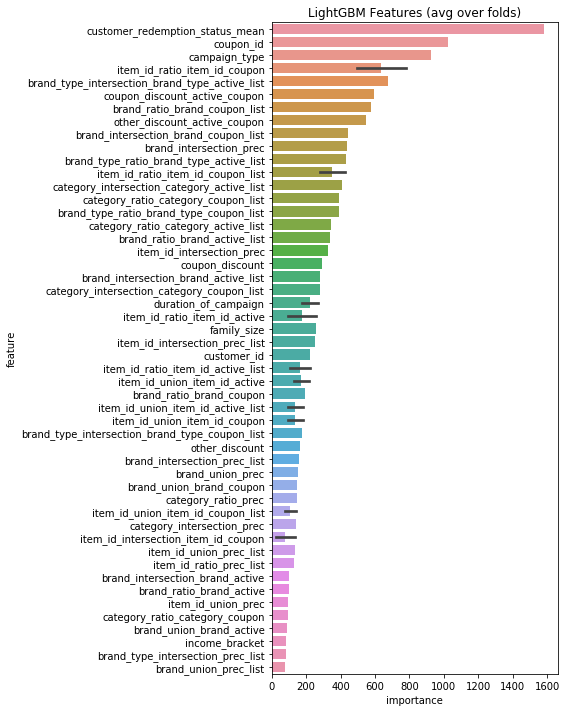

In [101]:
display_importances(feature_importance_df)

In [248]:
oof_preds_list = []
for s in [46,20,53,16,72,98]:
    print(s)
    lgb_params = {
            'random_state':s,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'logloss',
            'learning_rate': 0.002,
            'subsample': .8,
            'colsample_bytree': .4,
            'reg_alpha': 10,
            'reg_lambda': 10,
            'n_estimators': 15000,
            'max_depth': 2
        }


    oof_preds, feature_importance_df, clf = train_model(df_train, df_val
                                                        , df_train['redemption_status'], df_val['redemption_status']
                                                        ,num_feats+cat_feats+add_feats,50, **lgb_params)
    oof_preds_list.append(oof_preds)
    

46
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0375822	valid_1's binary_logloss: 0.063345
[200]	training's binary_logloss: 0.0344468	valid_1's binary_logloss: 0.0586805
[300]	training's binary_logloss: 0.0324432	valid_1's binary_logloss: 0.0556004
[400]	training's binary_logloss: 0.0310762	valid_1's binary_logloss: 0.0533686
[500]	training's binary_logloss: 0.0300595	valid_1's binary_logloss: 0.051732
[600]	training's binary_logloss: 0.0292302	valid_1's binary_logloss: 0.0504898
[700]	training's binary_logloss: 0.0285727	valid_1's binary_logloss: 0.0495695
[800]	training's binary_logloss: 0.0280503	valid_1's binary_logloss: 0.0488194
[900]	training's binary_logloss: 0.0276104	valid_1's binary_logloss: 0.0482523
[1000]	training's binary_logloss: 0.0272456	valid_1's binary_logloss: 0.0477561
[1100]	training's binary_logloss: 0.0269325	valid_1's binary_logloss: 0.0473705
[1200]	training's binary_logloss: 0.0266693	valid_1's binary_loglo

[10300]	training's binary_logloss: 0.0231592	valid_1's binary_logloss: 0.0436806
[10400]	training's binary_logloss: 0.0231505	valid_1's binary_logloss: 0.0436753
[10500]	training's binary_logloss: 0.0231423	valid_1's binary_logloss: 0.0436721
[10600]	training's binary_logloss: 0.0231344	valid_1's binary_logloss: 0.0436681
[10700]	training's binary_logloss: 0.0231265	valid_1's binary_logloss: 0.0436649
Early stopping, best iteration is:
[10737]	training's binary_logloss: 0.0231243	valid_1's binary_logloss: 0.0436637
Fold  1 AUC : 0.939231
20
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.0375145	valid_1's binary_logloss: 0.0633727
[200]	training's binary_logloss: 0.0344404	valid_1's binary_logloss: 0.0586482
[300]	training's binary_logloss: 0.0324576	valid_1's binary_logloss: 0.0555147
[400]	training's binary_logloss: 0.0310586	valid_1's binary_logloss: 0.0532825
[500]	training's binary_logloss: 0.0299877	valid_1's binary_logloss: 0.0517

[9700]	training's binary_logloss: 0.0232061	valid_1's binary_logloss: 0.0437056
[9800]	training's binary_logloss: 0.0231971	valid_1's binary_logloss: 0.0437025
[9900]	training's binary_logloss: 0.023188	valid_1's binary_logloss: 0.0436973
[10000]	training's binary_logloss: 0.0231792	valid_1's binary_logloss: 0.0436938
[10100]	training's binary_logloss: 0.02317	valid_1's binary_logloss: 0.0436897
[10200]	training's binary_logloss: 0.0231616	valid_1's binary_logloss: 0.0436848
[10300]	training's binary_logloss: 0.023153	valid_1's binary_logloss: 0.0436802
[10400]	training's binary_logloss: 0.0231444	valid_1's binary_logloss: 0.0436771
[10500]	training's binary_logloss: 0.0231363	valid_1's binary_logloss: 0.043672
[10600]	training's binary_logloss: 0.0231282	valid_1's binary_logloss: 0.0436682
[10700]	training's binary_logloss: 0.0231209	valid_1's binary_logloss: 0.0436638
Early stopping, best iteration is:
[10741]	training's binary_logloss: 0.023119	valid_1's binary_logloss: 0.0436621
Fo

[9100]	training's binary_logloss: 0.0232598	valid_1's binary_logloss: 0.0437153
[9200]	training's binary_logloss: 0.0232494	valid_1's binary_logloss: 0.04371
[9300]	training's binary_logloss: 0.0232393	valid_1's binary_logloss: 0.0437046
[9400]	training's binary_logloss: 0.0232296	valid_1's binary_logloss: 0.0436988
[9500]	training's binary_logloss: 0.0232202	valid_1's binary_logloss: 0.0436947
[9600]	training's binary_logloss: 0.0232107	valid_1's binary_logloss: 0.0436893
[9700]	training's binary_logloss: 0.0232024	valid_1's binary_logloss: 0.0436854
[9800]	training's binary_logloss: 0.0231932	valid_1's binary_logloss: 0.0436795
[9900]	training's binary_logloss: 0.0231841	valid_1's binary_logloss: 0.0436743
[10000]	training's binary_logloss: 0.0231757	valid_1's binary_logloss: 0.0436695
[10100]	training's binary_logloss: 0.0231671	valid_1's binary_logloss: 0.0436638
[10200]	training's binary_logloss: 0.0231585	valid_1's binary_logloss: 0.0436598
[10300]	training's binary_logloss: 0.02

[8500]	training's binary_logloss: 0.0233374	valid_1's binary_logloss: 0.0437782
[8600]	training's binary_logloss: 0.0233256	valid_1's binary_logloss: 0.0437722
[8700]	training's binary_logloss: 0.0233136	valid_1's binary_logloss: 0.043766
[8800]	training's binary_logloss: 0.0233024	valid_1's binary_logloss: 0.0437601
[8900]	training's binary_logloss: 0.0232912	valid_1's binary_logloss: 0.0437554
[9000]	training's binary_logloss: 0.0232805	valid_1's binary_logloss: 0.0437504
[9100]	training's binary_logloss: 0.0232701	valid_1's binary_logloss: 0.0437439
[9200]	training's binary_logloss: 0.0232596	valid_1's binary_logloss: 0.0437378
[9300]	training's binary_logloss: 0.0232497	valid_1's binary_logloss: 0.0437331
[9400]	training's binary_logloss: 0.0232401	valid_1's binary_logloss: 0.0437274
[9500]	training's binary_logloss: 0.0232303	valid_1's binary_logloss: 0.0437226
[9600]	training's binary_logloss: 0.0232209	valid_1's binary_logloss: 0.0437178
[9700]	training's binary_logloss: 0.02321

[7900]	training's binary_logloss: 0.0234061	valid_1's binary_logloss: 0.0437596
[8000]	training's binary_logloss: 0.0233927	valid_1's binary_logloss: 0.043754
[8100]	training's binary_logloss: 0.0233797	valid_1's binary_logloss: 0.0437492
[8200]	training's binary_logloss: 0.0233666	valid_1's binary_logloss: 0.043744
[8300]	training's binary_logloss: 0.0233535	valid_1's binary_logloss: 0.0437393
[8400]	training's binary_logloss: 0.0233407	valid_1's binary_logloss: 0.0437357
[8500]	training's binary_logloss: 0.0233284	valid_1's binary_logloss: 0.0437298
[8600]	training's binary_logloss: 0.0233159	valid_1's binary_logloss: 0.0437263
[8700]	training's binary_logloss: 0.0233049	valid_1's binary_logloss: 0.0437193
[8800]	training's binary_logloss: 0.0232942	valid_1's binary_logloss: 0.0437144
[8900]	training's binary_logloss: 0.0232829	valid_1's binary_logloss: 0.043707
[9000]	training's binary_logloss: 0.0232717	valid_1's binary_logloss: 0.0437021
[9100]	training's binary_logloss: 0.0232609

[7300]	training's binary_logloss: 0.0234875	valid_1's binary_logloss: 0.0438404
[7400]	training's binary_logloss: 0.0234724	valid_1's binary_logloss: 0.0438322
[7500]	training's binary_logloss: 0.0234583	valid_1's binary_logloss: 0.0438264
[7600]	training's binary_logloss: 0.0234438	valid_1's binary_logloss: 0.0438196
[7700]	training's binary_logloss: 0.0234295	valid_1's binary_logloss: 0.0438123
[7800]	training's binary_logloss: 0.0234151	valid_1's binary_logloss: 0.0438053
[7900]	training's binary_logloss: 0.0234017	valid_1's binary_logloss: 0.0437978
[8000]	training's binary_logloss: 0.0233886	valid_1's binary_logloss: 0.0437929
[8100]	training's binary_logloss: 0.0233751	valid_1's binary_logloss: 0.0437872
[8200]	training's binary_logloss: 0.0233621	valid_1's binary_logloss: 0.0437821
[8300]	training's binary_logloss: 0.0233493	valid_1's binary_logloss: 0.0437762
[8400]	training's binary_logloss: 0.0233366	valid_1's binary_logloss: 0.0437727
[8500]	training's binary_logloss: 0.0233

In [249]:
req_list = []
for i in range(len(oof_preds_list)):
#     if(i==7 or i==9 or i==1 or i==0 or i==5):
#         continue
#     else:
#         req_list.append(oof_preds_list[i])
    req_list.append(oof_preds_list[i])

In [156]:
# oof_preds_list_rank = [pd.Series(x).rank() for x in oof_preds_list]

In [157]:
# req_list_rank = []
# for i in range(len(oof_preds_list_rank)):
#     if(i==7 or i==9 or i==1 or i==0 or i==5):
#         continue
#     else:
#         req_list_rank.append(oof_preds_list_rank[i])

In [241]:
req_list

[array([0.00044765, 0.00098268, 0.00170942, ..., 0.00477292, 0.00064326,
        0.00214196]),
 array([0.00049631, 0.00109303, 0.00162075, ..., 0.00470302, 0.00067829,
        0.0021272 ]),
 array([0.00044037, 0.00096878, 0.00164771, ..., 0.00470836, 0.00062526,
        0.0021115 ]),
 array([0.00044411, 0.0010121 , 0.00175551, ..., 0.00442938, 0.00065337,
        0.0021178 ]),
 array([0.00049454, 0.00105351, 0.0015847 , ..., 0.00455083, 0.00070586,
        0.00206357])]

In [250]:
oof_preds

array([0.00040535, 0.00076737, 0.00161767, ..., 0.00496953, 0.00047968,
       0.00308195])

In [256]:
oof_preds = np.sum(req_list,0)

In [257]:
len(oof_preds)

27938

In [258]:
roc_auc_score(df_val.redemption_status,oof_preds)

0.9391838804192834

In [275]:
roc_auc_score(df_val.redemption_status,req_list[0])

0.9392310063549274

In [259]:
oof_preds

array([0.00238307, 0.00452368, 0.00946918, ..., 0.02999084, 0.00287444,
       0.01859207])

In [260]:
oof_preds

array([0.00238307, 0.00452368, 0.00946918, ..., 0.02999084, 0.00287444,
       0.01859207])

46
[200]	training's binary_logloss: 0.0408288
[400]	training's binary_logloss: 0.0366163
[600]	training's binary_logloss: 0.0344724
[800]	training's binary_logloss: 0.0331421
[1000]	training's binary_logloss: 0.0322479
[1200]	training's binary_logloss: 0.0316119
[1400]	training's binary_logloss: 0.0311324
[1600]	training's binary_logloss: 0.0307434
[1800]	training's binary_logloss: 0.0304064
[2000]	training's binary_logloss: 0.0301285
[2200]	training's binary_logloss: 0.0298945
[2400]	training's binary_logloss: 0.0296908
[2600]	training's binary_logloss: 0.0295198
[2800]	training's binary_logloss: 0.0293588
[3000]	training's binary_logloss: 0.0292137
[3200]	training's binary_logloss: 0.0290778
[3400]	training's binary_logloss: 0.0289573
[3600]	training's binary_logloss: 0.0288427
[3800]	training's binary_logloss: 0.0287425
[4000]	training's binary_logloss: 0.0286491
[4200]	training's binary_logloss: 0.0285572
[4400]	training's binary_logloss: 0.0284729
[4600]	training's binary_logloss:

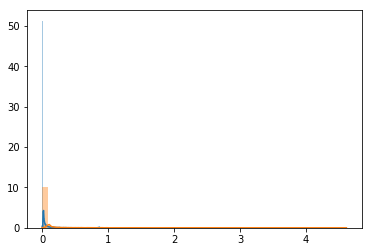

20
[200]	training's binary_logloss: 0.0408273
[400]	training's binary_logloss: 0.0366331
[600]	training's binary_logloss: 0.0344741
[800]	training's binary_logloss: 0.0331584
[1000]	training's binary_logloss: 0.0322635
[1200]	training's binary_logloss: 0.0316254
[1400]	training's binary_logloss: 0.0311257
[1600]	training's binary_logloss: 0.0307414
[1800]	training's binary_logloss: 0.0304048
[2000]	training's binary_logloss: 0.0301228
[2200]	training's binary_logloss: 0.0298844
[2400]	training's binary_logloss: 0.0296822
[2600]	training's binary_logloss: 0.0295047
[2800]	training's binary_logloss: 0.0293367
[3000]	training's binary_logloss: 0.0291894
[3200]	training's binary_logloss: 0.029058
[3400]	training's binary_logloss: 0.028939
[3600]	training's binary_logloss: 0.0288253
[3800]	training's binary_logloss: 0.0287257
[4000]	training's binary_logloss: 0.0286319
[4200]	training's binary_logloss: 0.0285381
[4400]	training's binary_logloss: 0.0284552
[4600]	training's binary_logloss: 0

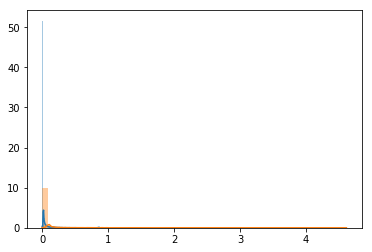

53
[200]	training's binary_logloss: 0.0408766
[400]	training's binary_logloss: 0.0366338
[600]	training's binary_logloss: 0.0344676
[800]	training's binary_logloss: 0.0331346
[1000]	training's binary_logloss: 0.0322354
[1200]	training's binary_logloss: 0.0315973
[1400]	training's binary_logloss: 0.0311141
[1600]	training's binary_logloss: 0.030714
[1800]	training's binary_logloss: 0.030382
[2000]	training's binary_logloss: 0.0301021
[2200]	training's binary_logloss: 0.0298703
[2400]	training's binary_logloss: 0.0296753
[2600]	training's binary_logloss: 0.0294987
[2800]	training's binary_logloss: 0.0293395
[3000]	training's binary_logloss: 0.029195
[3200]	training's binary_logloss: 0.0290619
[3400]	training's binary_logloss: 0.0289418
[3600]	training's binary_logloss: 0.0288348
[3800]	training's binary_logloss: 0.0287328
[4000]	training's binary_logloss: 0.0286353
[4200]	training's binary_logloss: 0.028543
[4400]	training's binary_logloss: 0.0284572
[4600]	training's binary_logloss: 0.0

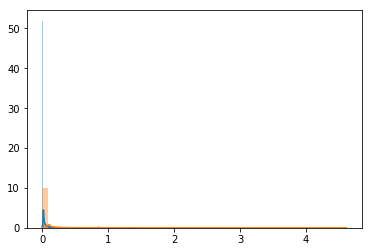

16
[200]	training's binary_logloss: 0.0408199
[400]	training's binary_logloss: 0.0366466
[600]	training's binary_logloss: 0.034469
[800]	training's binary_logloss: 0.0331471
[1000]	training's binary_logloss: 0.0322654
[1200]	training's binary_logloss: 0.0316221
[1400]	training's binary_logloss: 0.0311282
[1600]	training's binary_logloss: 0.030739
[1800]	training's binary_logloss: 0.0303957
[2000]	training's binary_logloss: 0.0301137
[2200]	training's binary_logloss: 0.029872
[2400]	training's binary_logloss: 0.0296739
[2600]	training's binary_logloss: 0.0294947
[2800]	training's binary_logloss: 0.029335
[3000]	training's binary_logloss: 0.0291877
[3200]	training's binary_logloss: 0.0290464
[3400]	training's binary_logloss: 0.0289248
[3600]	training's binary_logloss: 0.0288148
[3800]	training's binary_logloss: 0.0287151
[4000]	training's binary_logloss: 0.0286193
[4200]	training's binary_logloss: 0.0285283
[4400]	training's binary_logloss: 0.0284466
[4600]	training's binary_logloss: 0.0

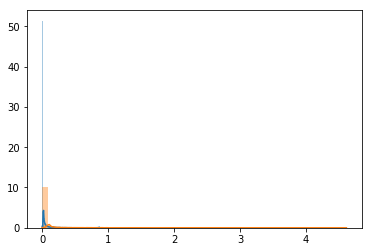

72
[200]	training's binary_logloss: 0.0407665
[400]	training's binary_logloss: 0.0366015
[600]	training's binary_logloss: 0.0344488
[800]	training's binary_logloss: 0.0331231
[1000]	training's binary_logloss: 0.0322395
[1200]	training's binary_logloss: 0.0316105
[1400]	training's binary_logloss: 0.0311309
[1600]	training's binary_logloss: 0.0307285
[1800]	training's binary_logloss: 0.0304029
[2000]	training's binary_logloss: 0.0301119
[2200]	training's binary_logloss: 0.0298727
[2400]	training's binary_logloss: 0.0296689
[2600]	training's binary_logloss: 0.0294809
[2800]	training's binary_logloss: 0.0293203
[3000]	training's binary_logloss: 0.0291755
[3200]	training's binary_logloss: 0.0290448
[3400]	training's binary_logloss: 0.028923
[3600]	training's binary_logloss: 0.0288107
[3800]	training's binary_logloss: 0.0287063
[4000]	training's binary_logloss: 0.0286087
[4200]	training's binary_logloss: 0.0285164
[4400]	training's binary_logloss: 0.0284305
[4600]	training's binary_logloss: 

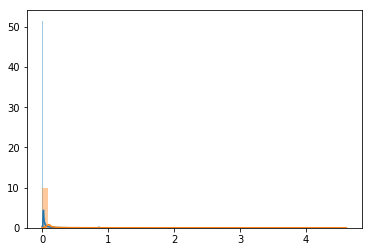

98
[200]	training's binary_logloss: 0.0408084
[400]	training's binary_logloss: 0.0366149
[600]	training's binary_logloss: 0.0344639
[800]	training's binary_logloss: 0.0331436
[1000]	training's binary_logloss: 0.0322438
[1200]	training's binary_logloss: 0.0316097
[1400]	training's binary_logloss: 0.0311178
[1600]	training's binary_logloss: 0.0307304
[1800]	training's binary_logloss: 0.0303927
[2000]	training's binary_logloss: 0.0301064
[2200]	training's binary_logloss: 0.0298742
[2400]	training's binary_logloss: 0.0296798
[2600]	training's binary_logloss: 0.0294984
[2800]	training's binary_logloss: 0.0293387
[3000]	training's binary_logloss: 0.0291909
[3200]	training's binary_logloss: 0.0290607
[3400]	training's binary_logloss: 0.0289378
[3600]	training's binary_logloss: 0.0288267
[3800]	training's binary_logloss: 0.0287266
[4000]	training's binary_logloss: 0.0286324
[4200]	training's binary_logloss: 0.0285385
[4400]	training's binary_logloss: 0.0284512
[4600]	training's binary_logloss:

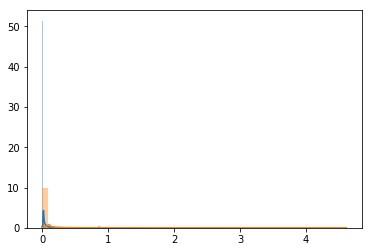

In [265]:
test_preds_list = []
for s in [46,20,53,16,72,98]:
    print(s)
    lgb_params = {
            'random_state':s,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'logloss',
            'learning_rate': 0.002,
            'subsample': .8,
            'colsample_bytree': .4,
            'reg_alpha': 10,
            'reg_lambda': 10,
            'n_estimators': 11000,
            'max_depth': 3
        }

    lgb_params['n_estimators'] = 11000
    clf = LGBMClassifier().set_params(**lgb_params)

    X_train = pd.concat([df_train, df_val], axis=0)
    trn_x = X_train[num_feats+cat_feats+add_feats]
    trn_y = X_train['redemption_status']

    clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y)], 
                eval_metric='logloss', verbose=200  #30
               )
    test_preds = clf.predict_proba(df_test[num_feats+cat_feats+add_feats])[:, 1]
    test_preds_list.append(test_preds)
    plt.figure()
    sns.distplot(test_preds)
    sns.distplot(oof_preds)
    plt.show()
    

In [267]:
num_feats+cat_feats+add_feats

['duration_of_campaign',
 'other_discount',
 'coupon_discount',
 'item_id_intersection_item_id_coupon',
 'item_id_union_item_id_coupon',
 'item_id_ratio_item_id_coupon',
 'other_discount_active_coupon',
 'coupon_discount_active_coupon',
 'item_id_intersection_item_id_active',
 'item_id_union_item_id_active',
 'item_id_ratio_item_id_active',
 'customer_redemption_status_mean',
 'customer_id',
 'coupon_id',
 'item_id_intersection_item_id_coupon_list',
 'item_id_union_item_id_coupon_list',
 'item_id_ratio_item_id_coupon_list',
 'item_id_intersection_item_id_active_list',
 'item_id_union_item_id_active_list',
 'item_id_ratio_item_id_active_list',
 'age_range',
 'marital_status',
 'rented',
 'family_size',
 'no_of_children',
 'income_bracket',
 'campaign_type',
 'brand_type_ratio_brand_type_active_list',
 'category_ratio_category_active_list',
 'category_intersection_prec']

In [268]:
req_list_oreds = []
for i in range(len(test_preds_list)):
#     if(i==7 or i==9 or i==1 or i==0 or i==5):
#         continue
#     else:
#         req_list_oreds.append(test_preds_list[i])
    req_list_oreds.append(test_preds_list[i])

In [269]:
test_preds = np.sum(req_list_oreds,0)
len(test_preds)

50226

In [211]:
sub = pd.read_csv('../input/sample_submission_Byiv0dS.csv')
sub['redemption_status'] = test_preds
sub.head()


,id,redemption_status
0,3,3.059443
1,4,0.063267
2,5,0.068927
3,8,0.002123
4,10,0.002696


In [270]:
sub = pd.read_csv('../input/sample_submission_Byiv0dS.csv')
sub['redemption_status'] = test_preds
sub.head()


,id,redemption_status
0,3,3.601646
1,4,0.075267
2,5,0.080383
3,8,0.002394
4,10,0.002802


In [271]:
sub['redemption_status'] = test_preds


In [272]:
sub.to_csv('../submission/14_avg_seed.csv', index=False)

In [277]:
test_preds = req_list_oreds[0]
len(test_preds)
sub['redemption_status'] = test_preds
sub.head()
sub.to_csv('../submission/14_seed_46.csv', index=False)

In [274]:
sub.head()

,id,redemption_status
0,3,0.616968
1,4,0.012929
2,5,0.013249
3,8,0.000398
4,10,0.000469
